# Using Machine Learning to Estimate Ratings of Bangladeshi Restaurants from Reviews

## Data Exploration and Visualization

### Data and package importation

The dataset I will be working with is sourced from [Mendeley Data](https://data.mendeley.com/datasets/wc87kpk6ks/1), a reputable open-source data repository. 
This particular dataset consists of user reviews extracted from restaurants located in various places in the city of Dhaka

Key information such as the review text, user ratings, and the date of the review post were compiled.

In [1]:
# Import the packages that we will be using
import pandas as pd
import scipy
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
import emoji
import nltk
import timeit
import pydot
import gensim
import os
import tensorflow as tf
import tensorflow_hub as hub
from keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Input ,BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint 
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet


# Ensure that NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

2024-05-21 03:29:34.345551: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/antoinem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# Load the data from a CSV file
rws = pd.read_csv('data.csv')

### Data Vizualization

In the following step, I'm going to change the dataset to better suit my needs by removing columns that are not pertinent to our analysis. Additionally, I will assign more descriptive names to certain columns to enhance clarity and facilitate easier data handling.

In [3]:
# Drop the 'Unnamed: 0' and 'createdAt' columns from the dataframe 
rws = rws.drop(columns=['Unnamed: 0', 'createdAt', 'reviewerName',])

# Rename specific columns to more descriptive names:
rws.rename(columns={'text': 'review', 'ratingvalue': 'rating'}, inplace=True)

# Convert the 'rating' column to numeric
rws['rating'] = pd.to_numeric(rws['rating'], errors='coerce')

# Display the first 5 rows
print(rws.head())

                                              review  rating
0  To tell you the truth, they sell fried chicken...       1
1                                  Crispy was so bad       3
2  The restaurant provided leas items which I ord...       1
3  already send you a picture about my meal. tota...       1
4                                Excellent as before       5


In the following sections, we will explore the dataset in more detail. We'll begin by presenting a series of visualizations that will give us insights into the distribution, trends, and relationships within the data.

Let's dive into the visuals to better understand our dataset.

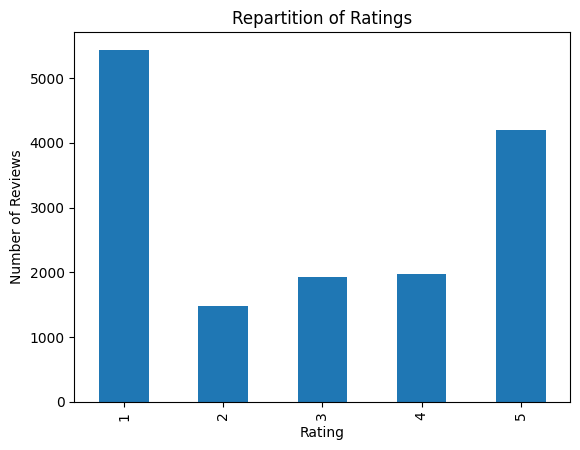

In [4]:
# Define the desired order of ratings
desired_order = [1, 2, 3, 4, 5]

# Calculate the counts of each rating
rating_counts = rws['rating'].value_counts()

# Reindex the rating_counts Series with the desired order
rating_counts = rating_counts.reindex(desired_order)

# Plot the repartition of ratings with the updated x-axis order
rating_counts.plot(kind='bar')

# Set the labels and title
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Repartition of Ratings')

# Show the plot
plt.show()


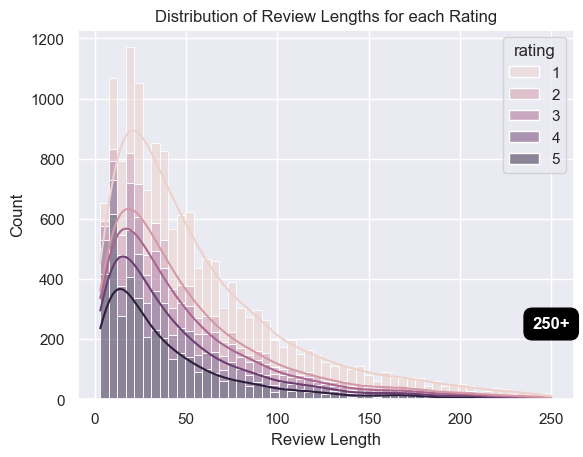

In [5]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set the style of the plot
sns.set(style="darkgrid")

# Calculate the length of reviews
rws['review_length'] = rws['review'].apply(len)

# Filter the review lengths greater than 250
filtered_rws = rws[rws['review_length'] <= 250]

# Plot the distribution of review lengths for each rating
sns.histplot(data=filtered_rws, x="review_length", hue="rating", multiple="stack", kde=True)

# Set the title and labels
plt.title("Distribution of Review Lengths for each Rating")
plt.xlabel("Review Length")
plt.ylabel("Count")

# Add a label for review lengths greater than 250
plt.text(250, 250, '250+', ha='center', va='center', color='white', fontweight='bold', fontsize=12,
         bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.show()

In [6]:
# Define a function to preprocess the reviews
longest_review = rws.loc[rws['review_length'].idxmax(), 'review']

print(longest_review)

When the delivery man arrived at my house, he called me to let me know that he had sent the food upstairs with my guard. I asked him to kindly wait downstairs so that I can send him the money to which he replied said the food has been paid for. I was quite taken aback and said that's not possible because I had opted for COD payment, and he just said "achcha ami dekhtesi" and then he just hung up on my face " I mean? Excuse me? I obviously lost my temper, called him back and asked him what sort of nonsense is this and why he kept the phone on my face. He was dumbfounded and did not say a word. I asked him to wait downstairs while I send the guard with the payment. Once your delivery-man had received the payment, he had the audacity to call me back and ask why I said what I said. To recall the conversation, when he hung up on my face my exact words when I called him back were "apni amar mukher upor keno phone rakhlen? Faizlami peyechen apni? Ami toh bolchi cash eh payment hobe, apni nich

In [7]:
rws.drop('review_length', axis=1, inplace=True)

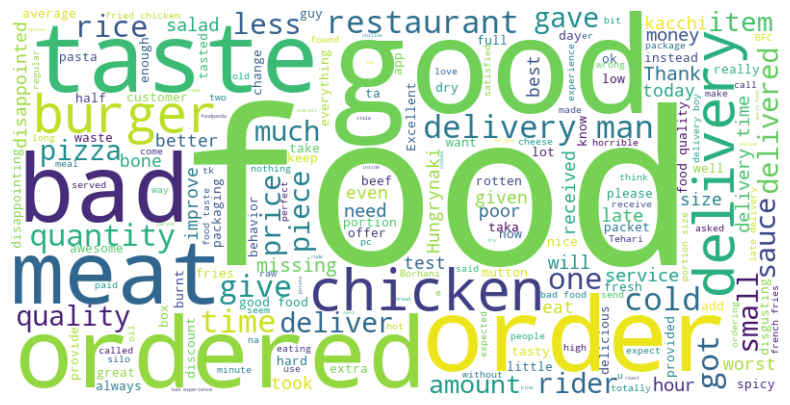

In [8]:
# Concatenate all the reviews into a single string
all_reviews = ' '.join(rws['review'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Plot the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Text Preprocessing and Data Categorization

### Data Categorization

I will create two categories for my reviews: Positive reviews, which are those with a rating strictly greater than 3, and Negative reviews, which include reviews with a rating strictly less than 3.

In [9]:
# Define a function that categorizes the rating
def categorize_rating(rating):
    if rating > 3:
        return 1
    elif rating < 3:
        return 0
    else:
        return 'Neutral'  # This handles ratings exactly equal to 3

# Apply the function to the 'rating' column
rws['rating'] = rws['rating'].apply(categorize_rating)

# Remove rows where the review_category is 'Neutral'
rws = rws[rws['rating'] != 'Neutral']

# Display the DataFrame to verify that 'Neutral' reviews have been removed
print(rws.head())

                                              review rating
0  To tell you the truth, they sell fried chicken...      0
2  The restaurant provided leas items which I ord...      0
3  already send you a picture about my meal. tota...      0
4                                Excellent as before      1
5  They forgot to include the beverages that were...      0


### Vizualization of the Categorization

Let's take a look at our newly categorized data to gain a clearer insight into how our future models will perform.

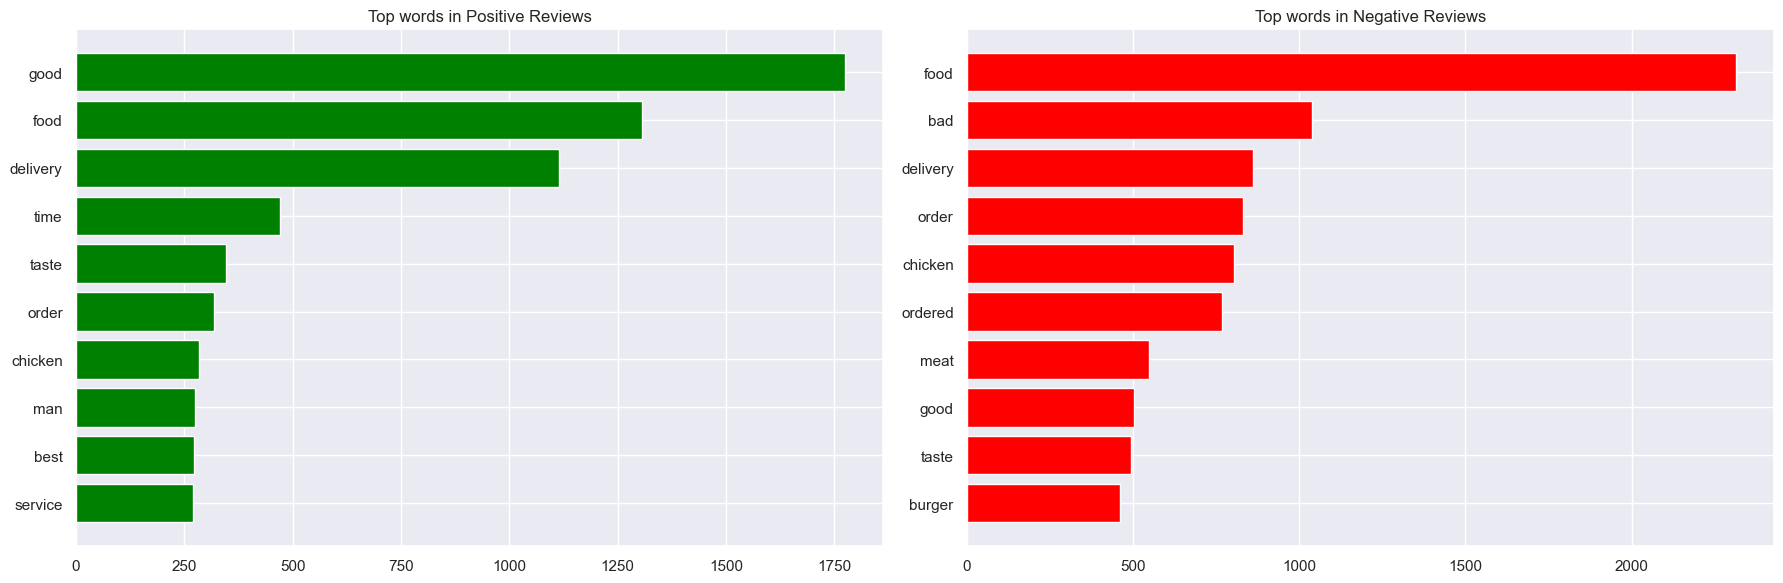

In [10]:
# Tokenize the reviews, remove stopwords, and count the word frequencies for positive and negative reviews separately.

# Function to clean and tokenize text
def clean_tokenize(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return tokens

# Separate positive and negative reviews
positive_reviews = rws[rws['rating'] == 1]['review']
negative_reviews = rws[rws['rating'] == 0]['review']

# Apply the cleaning and tokenization function
positive_tokens = positive_reviews.apply(clean_tokenize).sum()
negative_tokens = negative_reviews.apply(clean_tokenize).sum()

# Count the frequencies of words
positive_freq = Counter(positive_tokens)
negative_freq = Counter(negative_tokens)

# Get the 10 most common words in positive and negative reviews
most_common_positive = positive_freq.most_common(10)
most_common_negative = negative_freq.most_common(10)

# Separate the words and their counts for the plot
positive_words, positive_counts = zip(*most_common_positive)
negative_words, negative_counts = zip(*most_common_negative)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot for positive reviews
ax[0].barh(positive_words, positive_counts, color='green')
ax[0].set_title('Top words in Positive Reviews')
ax[0].invert_yaxis()  # Labels read top-to-bottom

# Plot for negative reviews
ax[1].barh(negative_words, negative_counts, color='red')
ax[1].set_title('Top words in Negative Reviews')
ax[1].invert_yaxis()  # Labels read top-to-bottom

# Display the plot
plt.tight_layout()
plt.show()


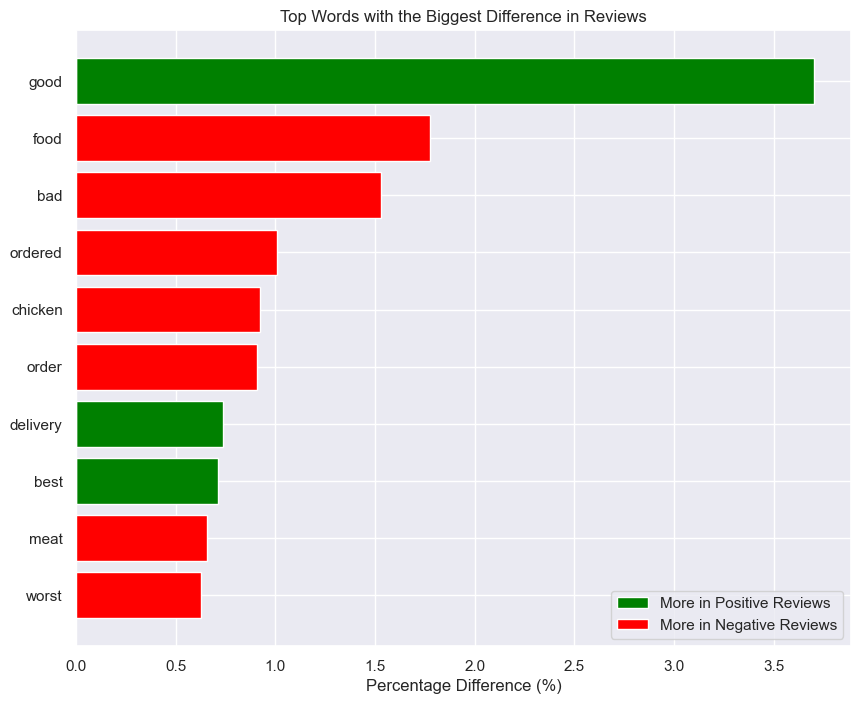

In [11]:
# Calculate the frequency difference for each word
frequency_diff = {word: positive_freq[word] - negative_freq[word] for word in set(positive_freq) | set(negative_freq)}

# Calculate the percentage difference for each word
total_pos_reviews = sum(positive_freq.values())
total_neg_reviews = sum(negative_freq.values())
percentage_diff = {word: (count / total_pos_reviews * 100 if count > 0 else count / total_neg_reviews * 100)
                   for word, count in frequency_diff.items()}

# Sort the words by the biggest absolute percentage difference
sorted_words = sorted(percentage_diff.items(), key=lambda x: abs(x[1]), reverse=True)

# Select the top words with the biggest difference
top_words = sorted_words[:10]  # Adjust the number as needed

# Split words and their percentage difference
words, differences = zip(*top_words)

# Split into positive and negative differences
pos_diffs = [percentage_diff[word] if percentage_diff[word] > 0 else 0 for word in words]
neg_diffs = [-percentage_diff[word] if percentage_diff[word] < 0 else 0 for word in words]

# Plotting
plt.figure(figsize=(10, 8))
y_pos = range(len(words))
plt.barh(y_pos, pos_diffs, color='green', label='More in Positive Reviews')
plt.barh(y_pos, neg_diffs, color='red', label='More in Negative Reviews')
plt.yticks(y_pos, words)
plt.xlabel('Percentage Difference (%)')
plt.title('Top Words with the Biggest Difference in Reviews')
plt.legend()
plt.gca().invert_yaxis()  # Highest percentages on top
plt.show()


### Text Preprocessing and Spliting

I will do text preprocessing in two distinct ways: 

**Large Cleaning Process :** This includes negation handling, emoji removal, lemmatization etc...

**Small Cleaning Process :** This maintaining more of the text's raw form.

*It will be beneficial to evaluate both versions with various models later on.*

Then I will also split the data into training and testing sets.

In [12]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def handle_negation(text):
    if text is None:
        return text
    # Pattern to detect negations followed by an alphanumeric word
    negation_pattern = re.compile(r'\b(not|no|never|none|nothing|nowhere|neither|nobody|cannot)\b[\s]*(\w+)')
    text = negation_pattern.sub(lambda x: f'{x.group(1)}_{x.group(2)}', text)
    return text

def full_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Handle negation
    text = handle_negation(text)
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # POS tagging
    nltk_pos_tagged = nltk.pos_tag(words)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_pos_tagged)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    return ' '.join(lemmatized_words)

def raw_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Tokenize text
    words = word_tokenize(text)
    return ' '.join(words)

In [13]:
# Balance the dataset
# Separate the dataset into positives and negatives
positive_rws = rws[rws['rating'] == 1]
negative_rws = rws[rws['rating'] == 0]

# Downsample the majority class (positive reviews) to match the minority class (negative reviews)
min_count = min(len(positive_rws), len(negative_rws))
balanced_positive = positive_rws.sample(n=min_count, random_state=42)
balanced_negative = negative_rws.sample(n=min_count, random_state=42)

# Combine back to a single balanced dataframe
balanced_rws = pd.concat([balanced_positive, balanced_negative])

# Now perform a stratified split on the balanced dataset
train_rws, test_rws = train_test_split(balanced_rws, test_size=0.2, stratify=balanced_rws['rating'], random_state=42)

# Apply the thorough cleaning to the training and test sets
# Create new DataFrame for cleaned versions including ratings
cleaned_train = pd.DataFrame({
    'review': train_rws['review'].apply(full_clean_text),
    'rating': train_rws['rating']
})
cleaned_test = pd.DataFrame({
    'review': test_rws['review'].apply(full_clean_text),
    'rating': test_rws['rating']
})

# Apply the minimal cleaning to the training and test sets
# Create new DataFrame for raw versions including ratings
raw_train = pd.DataFrame({
    'review': train_rws['review'].apply(raw_clean_text),
    'rating': train_rws['rating']
})
raw_test = pd.DataFrame({
    'review': test_rws['review'].apply(raw_clean_text),
    'rating': test_rws['rating']
})

In [14]:
# Print the first two reviews from the cleaned training set
print("First two reviews from the Cleaned Training Set:")
print(cleaned_train['review'].iloc[0])
print(cleaned_train['review'].iloc[1])
print("\n")

# Print the first two reviews from the cleaned test set
print("First two reviews from the Cleaned Test Set:")
print(cleaned_test['review'].iloc[0])
print(cleaned_test['review'].iloc[1])
print("\n")

# Assuming the same indices can be used for the raw sets, since the split was stratified based on the rating
print("First two reviews from the Raw Training Set:")
print(raw_train['review'].iloc[0])
print(raw_train['review'].iloc[1])
print("\n")

print("First two reviews from the Raw Test Set:")
print(raw_test['review'].iloc[0])
print(raw_test['review'].iloc[1])

First two reviews from the Cleaned Training Set:
bhuna khichuri plenty meatbeef ittaste also good
delivery time


First two reviews from the Cleaned Test Set:
bad food cold soggy bag rip entire soda go waste no_cheese cheeseburger
please continue consistency pizza excellent taste really fresh also whole family could enjoy definitely order


First two reviews from the Raw Training Set:
Bhuna khichuri had plenty of meat ( Beef ) in it.Taste was also good .
delivery time


First two reviews from the Raw Test Set:
It was very bad . The food was cold and soggy . The bag ripped and my entire soda went to waste . And there was no cheese in my cheeseburger
Please continue this consistency ! The pizza is excellent ! It tasted really fresh ! Also my whole family could enjoy it . Definitely ordering again .


In [15]:
# Count the occurrences of each class in the 'rating' column for both training and test sets
count_train = Counter(cleaned_train['rating'])
count_test = Counter(cleaned_test['rating'])
count_raw_train = Counter(raw_train['rating'])
count_raw_test = Counter(raw_test['rating'])

print("Counts for Cleaned Training Set:", count_train)
print("Counts for Cleaned Test Set:", count_test)
print("Counts for Raw Training Set:", count_raw_train)
print("Counts for Raw Test Set:", count_raw_test)


Counts for Cleaned Training Set: Counter({1: 4942, 0: 4942})
Counts for Cleaned Test Set: Counter({0: 1236, 1: 1236})
Counts for Raw Training Set: Counter({1: 4942, 0: 4942})
Counts for Raw Test Set: Counter({0: 1236, 1: 1236})


## Modelling

### Naive Bayes

First, I will be evaluating a Multinomial Naive Bayes model as my baseline

#### Naive Bayes with cleaned data (TF-IDF)

In [16]:
# Convert ratings to numeric codes if they are categorical
cleaned_train['rating'] = cleaned_train['rating'].astype('category').cat.codes
cleaned_test['rating'] = cleaned_test['rating'].astype('category').cat.codes

cX_train = cleaned_train['review']
cy_train = cleaned_train['rating']
cX_test = cleaned_test['review']
cy_test = cleaned_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
cX_train_tfidf = tfidf_vectorizer.fit_transform(cX_train)
cX_test_tfidf = tfidf_vectorizer.transform(cX_test)

# Training a Multinomial Naive Bayes model
model_0cTI = MultinomialNB()
model_0cTI.fit(cX_train_tfidf, cy_train)

# Predicting the ratings
start_time = timeit.default_timer()
cy_pred = model_0cTI.predict(cX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0cTI_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate other metrics
m0cTI_accuracy = accuracy_score(cy_test, cy_pred)
m0cTI_precision = precision_score(cy_test, cy_pred, average='weighted')
m0cTI_recall = recall_score(cy_test, cy_pred, average='weighted')
m0cTI_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0cTI_accuracy:.2%}", f"{m0cTI_precision:.3f}", f"{m0cTI_recall:.3f}", f"{m0cTI_f1:.3f}", f"{m0cTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


Model Performance          Results
         accuracy           78.80%
        precision            0.793
           recall            0.788
         f1_score            0.787
    time/instance 0.000000 seconds


#### Naive Bayes with raw data (TF-IDF)

In [17]:
# Convert ratings to numeric codes if they are categorical
raw_train['rating'] = raw_train['rating'].astype('category').cat.codes
raw_test['rating'] = raw_test['rating'].astype('category').cat.codes

rX_train = raw_train['review']
ry_train = raw_train['rating']
rX_test = raw_test['review']
ry_test = raw_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
rX_train_tfidf = tfidf_vectorizer.fit_transform(rX_train)
rX_test_tfidf = tfidf_vectorizer.transform(rX_test)

# Training a Multinomial Naive Bayes model
model_0rTI = MultinomialNB()
model_0rTI.fit(rX_train_tfidf, ry_train)

# Predicting the ratings
start_time = timeit.default_timer()
ry_pred = model_0rTI.predict(rX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0rTI_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate other metrics
m0rTI_accuracy = accuracy_score(ry_test, ry_pred)
m0rTI_precision = precision_score(ry_test, ry_pred, average='weighted')
m0rTI_recall = recall_score(ry_test, ry_pred, average='weighted')
m0rTI_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0rTI_accuracy:.2%}", f"{m0rTI_precision:.3f}", f"{m0rTI_recall:.3f}", f"{m0rTI_f1:.3f}", f"{m0rTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

Model Performance          Results
         accuracy           78.92%
        precision            0.795
           recall            0.789
         f1_score            0.788
    time/instance 0.000000 seconds


#### Storing Results

In [18]:
# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Time per Instance'])

def store_results(model_name, accuracy, precision, recall, f1_score, time_per_instance):
    # Append the new results to the DataFrame
    results_df.loc[len(results_df)] = {
        'Model': model_name,
        'Accuracy': f"{accuracy:.2%}",
        'Precision': f"{precision:.3f}",
        'Recall': f"{recall:.3f}",
        'F1 Score': f"{f1_score:.3f}",
        'Time per Instance': f"{time_per_instance:.6f} seconds"
    }

# Store the results for the cleaned text model with TF-IDF
store_results('Model_0cTI', m0cTI_accuracy, m0cTI_precision, m0cTI_recall, m0cTI_f1, m0cTI_time_per_instance)

# Store the results for the raw text model with TF-IDF
store_results('Model_0rTI', m0rTI_accuracy, m0rTI_precision, m0rTI_recall, m0rTI_f1, m0rTI_time_per_instance)

# View the consolidated results
print(results_df)


        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds


### FNN

My initial model is a Feedforward Neural Network (FNN) with 2 different vectorization (TF-IDF and Word2Vec)

#### FNN with cleaned data (TF-IDF)

In [19]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(cX_train_tfidf.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [20]:
param_grid = {
    'neurons': [128, 256],  # Starting neurons for the first layer
    'num_layers': [1, 2],  # Varying numbers of layers
    'learning_rate': [0.001, 0.0001],
    'regularization': [0, 0.001]  # Adding regularization to the grid search
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(cX_train_tfidf, cy_train, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6889 - loss: 0.6481
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8279 - loss: 0.4304
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8584 - loss: 0.3601
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8664 - loss: 0.3290
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8878 - loss: 0.2849
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8938 - loss: 0.2652
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9051 - loss: 0.2473
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9060 - loss: 0.2298
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9112 - loss: 0.2216
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9125 - loss: 0.2122
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9195 - loss: 0.2007
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6914 - loss: 0.6443
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8359 - loss: 0.4242
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8547 - loss: 0.3583
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8821 - loss: 0.3050
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8898 - loss: 0.2792
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9068 - loss: 0.2619
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9106 - loss: 0.2359
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9159 - loss: 0.2267
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9147 - loss: 0.2228
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9213 - loss: 0.1964
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9251 - loss: 0.1935
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6835 - loss: 0.6480
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8376 - loss: 0.4207
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8634 - loss: 0.3499
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8838 - loss: 0.3039
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8986 - loss: 0.2683
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9093 - loss: 0.2459
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9162 - loss: 0.2311
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9168 - loss: 0.2218
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9181 - loss: 0.2140
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9278 - loss: 0.1964
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9252 - loss: 0.1892
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6673 - loss: 0.7118
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8002 - loss: 0.5434
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8123 - loss: 0.5191
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8242 - loss: 0.5064
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8279 - loss: 0.4982
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8390 - loss: 0.4872
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8393 - loss: 0.4859
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8485 - loss: 0.4737
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8392 - loss: 0.4907
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8455 - loss: 0.4695
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8495 - loss: 0.4654
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7109 - loss: 0.7119
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7947 - loss: 0.5463
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8284 - loss: 0.5100
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8266 - loss: 0.4972
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8318 - loss: 0.4931
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8368 - loss: 0.4911
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8439 - loss: 0.4790
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8521 - loss: 0.4715
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8473 - loss: 0.4687
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8529 - loss: 0.4650
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8571 - loss: 0.4591
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6957 - loss: 0.7117
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8123 - loss: 0.5375
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8140 - loss: 0.5141
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8347 - loss: 0.4914
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8402 - loss: 0.4820
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8433 - loss: 0.4815
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8471 - loss: 0.4706
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8538 - loss: 0.4691
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8493 - loss: 0.4553
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8599 - loss: 0.4548
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8617 - loss: 0.4543
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6586 - loss: 0.6243
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8370 - loss: 0.3763
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8756 - loss: 0.3106
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8933 - loss: 0.2695
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9088 - loss: 0.2369
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9168 - loss: 0.2238
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9178 - loss: 0.2142
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9131 - loss: 0.2179
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9187 - loss: 0.2031
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9265 - loss: 0.1918
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9158 - loss: 0.1963
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6906 - loss: 0.6196
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8453 - loss: 0.3702
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8768 - loss: 0.3125
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8900 - loss: 0.2760
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9047 - loss: 0.2418
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9134 - loss: 0.2236
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9179 - loss: 0.2044
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9129 - loss: 0.2104
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9224 - loss: 0.1995
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9299 - loss: 0.1951
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9274 - loss: 0.1879
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7096 - loss: 0.6176
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8419 - loss: 0.3695
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8880 - loss: 0.2969
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9061 - loss: 0.2455
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9153 - loss: 0.2248
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9215 - loss: 0.1999
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9175 - loss: 0.2087
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9108 - loss: 0.2097
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9252 - loss: 0.1874
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9200 - loss: 0.1840
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9272 - loss: 0.1861
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accurac

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6956 - loss: 0.7566
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8112 - loss: 0.5280
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8320 - loss: 0.5077
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8577 - loss: 0.4824
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8471 - loss: 0.4853
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8592 - loss: 0.4746
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8591 - loss: 0.4679
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8821 - loss: 0.4351
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8726 - loss: 0.4486
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8790 - loss: 0.4375
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8830 - loss: 0.4378
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6536 - loss: 0.7546
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8171 - loss: 0.5266
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8362 - loss: 0.5033
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8474 - loss: 0.4903
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8555 - loss: 0.4733
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8633 - loss: 0.4780
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8654 - loss: 0.4667
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8707 - loss: 0.4510
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8821 - loss: 0.4412
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8813 - loss: 0.4357
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8877 - loss: 0.4173
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6670 - loss: 0.7532
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8319 - loss: 0.5104
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8412 - loss: 0.4890
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8550 - loss: 0.4860
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8579 - loss: 0.4781
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8686 - loss: 0.4603
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8657 - loss: 0.4494
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8781 - loss: 0.4423
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8756 - loss: 0.4369
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8908 - loss: 0.4293
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8854 - loss: 0.4194
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7121 - loss: 0.6300
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8252 - loss: 0.4098
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8676 - loss: 0.3243
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8892 - loss: 0.2996
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8890 - loss: 0.2714
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9009 - loss: 0.2478
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9100 - loss: 0.2363
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9155 - loss: 0.2209
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9175 - loss: 0.2067
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9157 - loss: 0.2153
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9208 - loss: 0.1958
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7021 - loss: 0.6297
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8342 - loss: 0.4102
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8763 - loss: 0.3213
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8946 - loss: 0.2762
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8975 - loss: 0.2624
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9163 - loss: 0.2244
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9089 - loss: 0.2281
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9208 - loss: 0.2110
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9191 - loss: 0.2040
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9206 - loss: 0.2030
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9223 - loss: 0.1939
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6983 - loss: 0.6298
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8417 - loss: 0.3853
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8786 - loss: 0.3193
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8900 - loss: 0.2870
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8996 - loss: 0.2480
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9106 - loss: 0.2363
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9209 - loss: 0.2090
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9212 - loss: 0.2164
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9224 - loss: 0.1980
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9216 - loss: 0.1951
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9316 - loss: 0.1792
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7223 - loss: 0.7519
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8036 - loss: 0.5398
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8155 - loss: 0.5211
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8257 - loss: 0.5178
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8339 - loss: 0.5032
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8244 - loss: 0.5105
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8286 - loss: 0.5133
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8361 - loss: 0.5046
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8468 - loss: 0.4964
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8385 - loss: 0.4963
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8453 - loss: 0.4903
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7017 - loss: 0.7514
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8023 - loss: 0.5453
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8115 - loss: 0.5290
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8175 - loss: 0.5170
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8336 - loss: 0.5034
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8394 - loss: 0.5050
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8401 - loss: 0.4946
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8420 - loss: 0.4998
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8511 - loss: 0.4895
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8461 - loss: 0.4915
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8528 - loss: 0.4805
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7201 - loss: 0.7499
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8115 - loss: 0.5299
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8306 - loss: 0.5085
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8272 - loss: 0.5133
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8451 - loss: 0.4975
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8418 - loss: 0.4872
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8469 - loss: 0.4836
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8448 - loss: 0.4821
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8476 - loss: 0.4727
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8473 - loss: 0.4852
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8475 - loss: 0.4761
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6958 - loss: 0.5949
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8494 - loss: 0.3640
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8855 - loss: 0.2999
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8909 - loss: 0.2692
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9090 - loss: 0.2347
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9154 - loss: 0.2155
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9076 - loss: 0.2269
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9197 - loss: 0.1998
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9170 - loss: 0.2026
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9159 - loss: 0.2041
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9212 - loss: 0.1860
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7192 - loss: 0.5919
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8547 - loss: 0.3538
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8855 - loss: 0.2856
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9025 - loss: 0.2519
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9087 - loss: 0.2333
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9131 - loss: 0.2278
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9190 - loss: 0.2016
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9182 - loss: 0.2063
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9200 - loss: 0.2022
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9225 - loss: 0.1936
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9202 - loss: 0.1894
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6921 - loss: 0.5926
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8543 - loss: 0.3605
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8968 - loss: 0.2703
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9046 - loss: 0.2463
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9082 - loss: 0.2153
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9136 - loss: 0.2156
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9251 - loss: 0.1984
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9156 - loss: 0.2029
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9177 - loss: 0.2046
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9194 - loss: 0.1940
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9265 - loss: 0.1811
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6556 - loss: 0.8222
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8103 - loss: 0.5381
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8330 - loss: 0.5121
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8389 - loss: 0.5119
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8519 - loss: 0.4872
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8504 - loss: 0.4843
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8603 - loss: 0.4743
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8612 - loss: 0.4659
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8654 - loss: 0.4676
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8713 - loss: 0.4434
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8740 - loss: 0.4400
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6858 - loss: 0.8210
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8244 - loss: 0.5273
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8301 - loss: 0.5215
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8439 - loss: 0.4991
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8538 - loss: 0.4942
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8604 - loss: 0.4805
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8690 - loss: 0.4608
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8763 - loss: 0.4493
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8768 - loss: 0.4503
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8815 - loss: 0.4390
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8853 - loss: 0.4295
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7041 - loss: 0.8167
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8281 - loss: 0.5204
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8458 - loss: 0.5025
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8480 - loss: 0.4910
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8620 - loss: 0.4733
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8564 - loss: 0.4756
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8696 - loss: 0.4520
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8712 - loss: 0.4500
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8788 - loss: 0.4382
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8917 - loss: 0.4202
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8925 - loss: 0.4121
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6237 - loss: 0.6898
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7898 - loss: 0.6736
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8057 - loss: 0.6497
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8261 - loss: 0.6152
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8213 - loss: 0.5836
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8289 - loss: 0.5497
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8264 - loss: 0.5165
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8318 - loss: 0.4862
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8367 - loss: 0.4669
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8409 - loss: 0.4464
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8437 - loss: 0.4323
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6279 - loss: 0.6897
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7900 - loss: 0.6719
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8210 - loss: 0.6469
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8240 - loss: 0.6141
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8379 - loss: 0.5782
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8354 - loss: 0.5472
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8422 - loss: 0.5137
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8467 - loss: 0.4880
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8439 - loss: 0.4637
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8558 - loss: 0.4414
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8522 - loss: 0.4329
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6005 - loss: 0.6904
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7995 - loss: 0.6724
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8159 - loss: 0.6473
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8234 - loss: 0.6144
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8309 - loss: 0.5771
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8338 - loss: 0.5466
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8371 - loss: 0.5115
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8417 - loss: 0.4866
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8515 - loss: 0.4577
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8547 - loss: 0.4380
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8527 - loss: 0.4240
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5783 - loss: 0.8652
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7842 - loss: 0.7116
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7988 - loss: 0.6686
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8018 - loss: 0.6423
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8046 - loss: 0.6165
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8172 - loss: 0.5896
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8068 - loss: 0.5753
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8094 - loss: 0.5600
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8134 - loss: 0.5465
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8098 - loss: 0.5381
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8238 - loss: 0.5245
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6374 - loss: 0.8639
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7961 - loss: 0.7090
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7982 - loss: 0.6670
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8007 - loss: 0.6392
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8079 - loss: 0.6162
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8054 - loss: 0.5957
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8198 - loss: 0.5737
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8144 - loss: 0.5601
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8158 - loss: 0.5479
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8240 - loss: 0.5339
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8268 - loss: 0.5252
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6041 - loss: 0.8644
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7986 - loss: 0.7097
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8081 - loss: 0.6673
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8068 - loss: 0.6391
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8181 - loss: 0.6135
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8126 - loss: 0.5920
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8207 - loss: 0.5715
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8103 - loss: 0.5595
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8175 - loss: 0.5477
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8365 - loss: 0.5242
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8228 - loss: 0.5250
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6049 - loss: 0.6914
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7777 - loss: 0.6737
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8037 - loss: 0.6088
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8268 - loss: 0.5062
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8349 - loss: 0.4377
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8472 - loss: 0.3957
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8585 - loss: 0.3620
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8623 - loss: 0.3529
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8774 - loss: 0.3260
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8725 - loss: 0.3224
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8855 - loss: 0.2988
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5940 - loss: 0.6910
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7874 - loss: 0.6710
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8125 - loss: 0.6011
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8266 - loss: 0.5035
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8503 - loss: 0.4237
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8489 - loss: 0.3970
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8607 - loss: 0.3635
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8708 - loss: 0.3436
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8753 - loss: 0.3290
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8829 - loss: 0.3091
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8830 - loss: 0.2993
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6251 - loss: 0.6906
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7868 - loss: 0.6693
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8072 - loss: 0.5962
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8324 - loss: 0.4880
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8339 - loss: 0.4317
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8523 - loss: 0.3839
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8658 - loss: 0.3527
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8691 - loss: 0.3415
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8761 - loss: 0.3205
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8805 - loss: 0.3116
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8924 - loss: 0.2853
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6229 - loss: 0.9440
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7706 - loss: 0.7702
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7993 - loss: 0.7097
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8071 - loss: 0.6425
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8144 - loss: 0.5846
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8202 - loss: 0.5486
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8339 - loss: 0.5145
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8338 - loss: 0.5022
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8418 - loss: 0.4949
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8418 - loss: 0.4914
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8458 - loss: 0.4852
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5877 - loss: 0.9422
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7805 - loss: 0.7691
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7948 - loss: 0.7102
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8036 - loss: 0.6441
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8213 - loss: 0.5826
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8206 - loss: 0.5450
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8304 - loss: 0.5211
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8442 - loss: 0.5024
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8496 - loss: 0.5017
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8538 - loss: 0.4828
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8519 - loss: 0.4781
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5929 - loss: 0.9440
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7844 - loss: 0.7693
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7988 - loss: 0.7072
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8124 - loss: 0.6369
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8183 - loss: 0.5748
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8193 - loss: 0.5457
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8353 - loss: 0.5142
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8421 - loss: 0.4940
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8516 - loss: 0.4848
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8494 - loss: 0.4756
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8608 - loss: 0.4664
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6303 - loss: 0.6889
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7925 - loss: 0.6643
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8100 - loss: 0.6241
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8221 - loss: 0.5787
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8240 - loss: 0.5346
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8304 - loss: 0.4960
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8311 - loss: 0.4661
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8421 - loss: 0.4384
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8484 - loss: 0.4127
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8477 - loss: 0.4014
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8511 - loss: 0.3849
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6629 - loss: 0.6872
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8072 - loss: 0.6590
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8139 - loss: 0.6203
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8202 - loss: 0.5716
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8344 - loss: 0.5285
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8481 - loss: 0.4856
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8553 - loss: 0.4447
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8498 - loss: 0.4368
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8594 - loss: 0.4053
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8625 - loss: 0.3881
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8577 - loss: 0.3905
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6437 - loss: 0.6883
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7964 - loss: 0.6607
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8183 - loss: 0.6193
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8242 - loss: 0.5723
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8319 - loss: 0.5254
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8447 - loss: 0.4834
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8480 - loss: 0.4503
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8535 - loss: 0.4291
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8512 - loss: 0.4061
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8577 - loss: 0.3916
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8745 - loss: 0.3642
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6267 - loss: 1.0272
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7921 - loss: 0.7254
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8007 - loss: 0.6611
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7956 - loss: 0.6234
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8074 - loss: 0.5908
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8043 - loss: 0.5705
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8175 - loss: 0.5460
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8139 - loss: 0.5382
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8178 - loss: 0.5260
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8257 - loss: 0.5222
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8244 - loss: 0.5136
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6062 - loss: 1.0274
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7810 - loss: 0.7257
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8111 - loss: 0.6559
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8031 - loss: 0.6230
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8143 - loss: 0.5926
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8057 - loss: 0.5713
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8041 - loss: 0.5555
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8171 - loss: 0.5374
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8236 - loss: 0.5251
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8144 - loss: 0.5203
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8263 - loss: 0.5108
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6165 - loss: 1.0266
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7917 - loss: 0.7254
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8129 - loss: 0.6559
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8038 - loss: 0.6187
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8140 - loss: 0.5864
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8212 - loss: 0.5613
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8178 - loss: 0.5483
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8330 - loss: 0.5235
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8315 - loss: 0.5150
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8270 - loss: 0.5152
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8317 - loss: 0.5013
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6410 - loss: 0.6894
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7947 - loss: 0.6432
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8156 - loss: 0.5093
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8373 - loss: 0.4168
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8518 - loss: 0.3716
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8646 - loss: 0.3440
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8767 - loss: 0.3176
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8765 - loss: 0.3091
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8906 - loss: 0.2873
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8976 - loss: 0.2704
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9006 - loss: 0.2596
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6108 - loss: 0.6903
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8034 - loss: 0.6440
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8238 - loss: 0.5057
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8391 - loss: 0.4150
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8529 - loss: 0.3744
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8654 - loss: 0.3438
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8793 - loss: 0.3120
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8868 - loss: 0.2906
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8932 - loss: 0.2762
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9001 - loss: 0.2641
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9065 - loss: 0.2506
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6029 - loss: 0.6898
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7932 - loss: 0.6364
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8240 - loss: 0.4936
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8443 - loss: 0.4032
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8675 - loss: 0.3573
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8738 - loss: 0.3269
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8765 - loss: 0.3174
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8963 - loss: 0.2869
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9017 - loss: 0.2591
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9065 - loss: 0.2609
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9047 - loss: 0.2505
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5838 - loss: 1.1815
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7817 - loss: 0.8224
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7968 - loss: 0.6969
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8096 - loss: 0.5976
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8247 - loss: 0.5467
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8366 - loss: 0.5149
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8350 - loss: 0.5022
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8521 - loss: 0.4824
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8419 - loss: 0.4807
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8576 - loss: 0.4715
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8637 - loss: 0.4594
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6005 - loss: 1.1790
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7885 - loss: 0.8186
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7996 - loss: 0.6863
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8255 - loss: 0.5858
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8366 - loss: 0.5394
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8468 - loss: 0.5090
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8462 - loss: 0.4954
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8517 - loss: 0.4856
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8555 - loss: 0.4738
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8568 - loss: 0.4632
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8701 - loss: 0.4562
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6040 - loss: 1.1787
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7781 - loss: 0.8181
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8046 - loss: 0.6848
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8266 - loss: 0.5756
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8330 - loss: 0.5375
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8422 - loss: 0.5031
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8515 - loss: 0.4835
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8531 - loss: 0.4807
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8567 - loss: 0.4728
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8674 - loss: 0.4557
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8705 - loss: 0.4521
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6425 - loss: 0.9778
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7843 - loss: 0.6794
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7992 - loss: 0.6192
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7967 - loss: 0.5791
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8050 - loss: 0.5504
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8130 - loss: 0.5342
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8209 - loss: 0.5182
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8244 - loss: 0.5051
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8195 - loss: 0.5060
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8273 - loss: 0.4930
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8254 - loss: 0.4990
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/ste

In [21]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.795021 using {'learning_rate': 0.0001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.729663 (0.008268) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.782173 (0.004716) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.737252 (0.006449) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.762242 (0.004033) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.731484 (0.010707) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.774382 (0.005609) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.736645 (0.004464) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.767806 (0.007398) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.787939 (0.008174) with: {'learning_ra

In [22]:
# Extract the best parameters
best_params = grid_result.best_params_

In [23]:
# Create the final model using the best parameters
model_1cTI = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1cTI.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_122 (Dense)               │ (None, 256)            │     1,714,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,714,433 (6.54 MB)

 Trainable params: 1,714,433 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

None


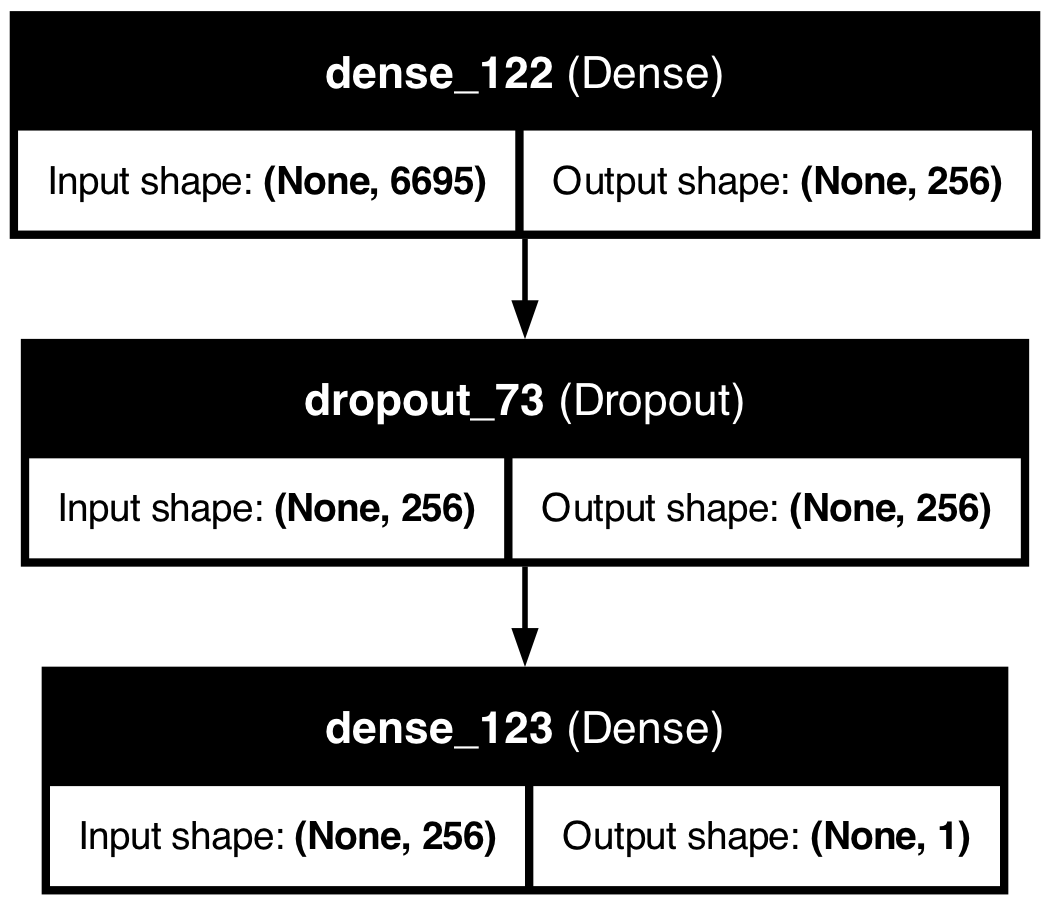

In [24]:
# Generate the plot
plot_model(model_1cTI, show_shapes=True, show_layer_names=True)

In [25]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1cTI_history = model_1cTI.fit(
    cX_train_tfidf, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/300


247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6635 - loss: 1.0050
Epoch 1: val_loss improved from inf to 0.72830, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6640 - loss: 1.0041 - val_accuracy: 0.7678 - val_loss: 0.7283 - learning_rate: 1.0000e-04
Epoch 2/300
246/248 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7998 - loss: 0.7016
Epoch 2: val_loss improved from 0.72830 to 0.65556, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7998 - loss: 0.7014 - val_accuracy: 0.7673 - val_loss: 0.6556 - learning_rate: 1.0000e-04
Epoch 3/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8086 - loss: 0.6376
Epoch 3: val_loss improved from 0.65556 to 0.61718, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8086 - loss: 0.6376 - val_accuracy: 0.7719 - val_loss: 0.6172 - learning_rate: 1.0000e-04
Epoch 4/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc

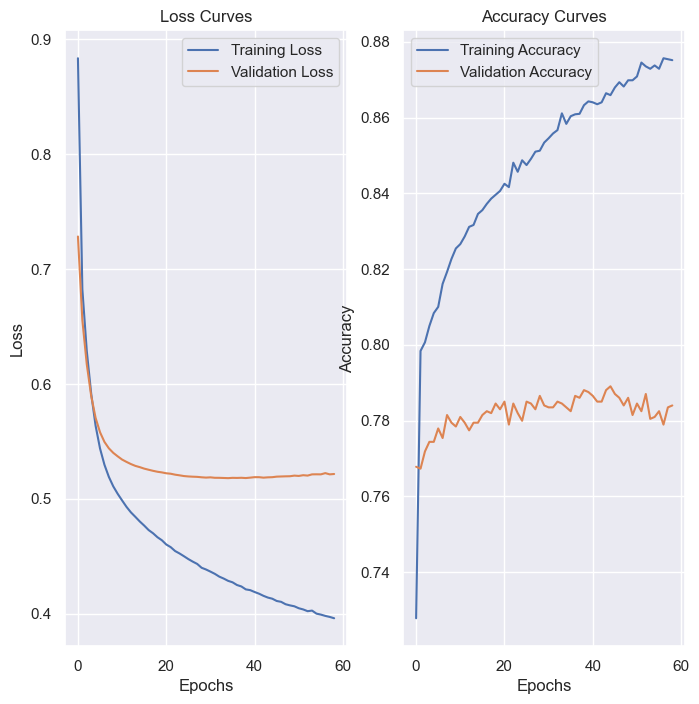

In [26]:
# Create a function to vizuualize the training and validation loss and accuracy
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    Args:
    history: TensorFlow History object.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    
# Use the function with your model's history
plot_loss_curves(model_1cTI_history)

In [27]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_1cTI.predict(cX_test_tfidf)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1cTI_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m1cTI_accuracy = accuracy_score(cy_test, cy_pred)
m1cTI_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1cTI_recall = recall_score(cy_test, cy_pred, average='weighted')
m1cTI_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1cTI_accuracy:.2%}", f"{m1cTI_precision:.3f}", f"{m1cTI_recall:.3f}", f"{m1cTI_f1:.3f}", f"{m1cTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model Performance          Results
         accuracy           78.20%
        precision            0.785
           recall            0.782
         f1_score            0.781
    time/instance 0.000397 seconds


In [28]:
store_results('Model_1cTI', m1cTI_accuracy, m1cTI_precision, m1cTI_recall, m1cTI_f1, m1cTI_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds


#### FNN with raw data (TF-IDF)

In [29]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(rX_train_tfidf.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [30]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(rX_train_tfidf, ry_train, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7007 - loss: 0.6444
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8185 - loss: 0.4296
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8596 - loss: 0.3542
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8731 - loss: 0.3156
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8887 - loss: 0.2789
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8960 - loss: 0.2635
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9041 - loss: 0.2560
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9123 - loss: 0.2324
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9160 - loss: 0.2207
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9237 - loss: 0.2036
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9239 - loss: 0.2059
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7020 - loss: 0.6444
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8280 - loss: 0.4224
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8607 - loss: 0.3446
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8847 - loss: 0.3029
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9002 - loss: 0.2669
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9093 - loss: 0.2469
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9080 - loss: 0.2353
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9137 - loss: 0.2268
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9169 - loss: 0.2182
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9185 - loss: 0.2087
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9245 - loss: 0.1905
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7030 - loss: 0.6435
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8236 - loss: 0.4248
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8636 - loss: 0.3481
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8867 - loss: 0.2993
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9018 - loss: 0.2622
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9010 - loss: 0.2583
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9085 - loss: 0.2435
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9148 - loss: 0.2170
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9254 - loss: 0.1969
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9213 - loss: 0.2066
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9249 - loss: 0.1908
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6987 - loss: 0.7138
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7937 - loss: 0.5404
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8096 - loss: 0.5156
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8188 - loss: 0.5056
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8341 - loss: 0.4859
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8280 - loss: 0.4955
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8444 - loss: 0.4725
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8424 - loss: 0.4780
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8345 - loss: 0.4752
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8437 - loss: 0.4600
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8486 - loss: 0.4593
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7046 - loss: 0.7136
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8084 - loss: 0.5359
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8181 - loss: 0.5134
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8401 - loss: 0.4863
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8235 - loss: 0.5015
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8359 - loss: 0.4885
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8352 - loss: 0.4845
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8472 - loss: 0.4642
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8475 - loss: 0.4676
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8426 - loss: 0.4699
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8479 - loss: 0.4673
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6946 - loss: 0.7148
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8006 - loss: 0.5335
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8110 - loss: 0.5150
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8242 - loss: 0.4959
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8351 - loss: 0.4810
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8371 - loss: 0.4787
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8531 - loss: 0.4632
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8326 - loss: 0.4739
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8490 - loss: 0.4606
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8562 - loss: 0.4495
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8577 - loss: 0.4477
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6771 - loss: 0.6187
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8367 - loss: 0.3782
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8655 - loss: 0.3208
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8995 - loss: 0.2694
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8999 - loss: 0.2588
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9172 - loss: 0.2283
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9223 - loss: 0.2075
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9179 - loss: 0.2083
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9285 - loss: 0.1980
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9264 - loss: 0.1873
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9301 - loss: 0.1821
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6618 - loss: 0.6167
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8493 - loss: 0.3611
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8858 - loss: 0.2940
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9003 - loss: 0.2626
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9130 - loss: 0.2351
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9092 - loss: 0.2228
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9183 - loss: 0.2031
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9272 - loss: 0.1933
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9259 - loss: 0.1855
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9281 - loss: 0.1865
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9292 - loss: 0.1842
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6737 - loss: 0.6175
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8400 - loss: 0.3714
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8755 - loss: 0.2956
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9009 - loss: 0.2518
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9092 - loss: 0.2277
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9159 - loss: 0.2151
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9210 - loss: 0.2013
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9337 - loss: 0.1800
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9293 - loss: 0.1850
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9295 - loss: 0.1790
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9260 - loss: 0.1798
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6437 - loss: 0.7552
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8153 - loss: 0.5186
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8318 - loss: 0.4973
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8457 - loss: 0.4828
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8426 - loss: 0.4813
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8585 - loss: 0.4635
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8635 - loss: 0.4499
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8634 - loss: 0.4565
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8671 - loss: 0.4439
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8692 - loss: 0.4431
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8721 - loss: 0.4343
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6711 - loss: 0.7610
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8139 - loss: 0.5159
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8500 - loss: 0.4815
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8463 - loss: 0.4804
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8610 - loss: 0.4575
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8598 - loss: 0.4591
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8586 - loss: 0.4594
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8736 - loss: 0.4484
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8710 - loss: 0.4340
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8771 - loss: 0.4292
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8833 - loss: 0.4241
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6757 - loss: 0.7530
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8178 - loss: 0.5164
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8393 - loss: 0.4853
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8583 - loss: 0.4674
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8568 - loss: 0.4637
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8605 - loss: 0.4613
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8685 - loss: 0.4498
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8683 - loss: 0.4484
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8693 - loss: 0.4388
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8757 - loss: 0.4240
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8852 - loss: 0.4152
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7056 - loss: 0.6282
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8391 - loss: 0.3985
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8664 - loss: 0.3179
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8898 - loss: 0.2860
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9001 - loss: 0.2601
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9108 - loss: 0.2406
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9210 - loss: 0.2212
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9200 - loss: 0.2101
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9236 - loss: 0.2132
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9219 - loss: 0.2022
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9250 - loss: 0.1945
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7043 - loss: 0.6266
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8264 - loss: 0.4041
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8632 - loss: 0.3262
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8937 - loss: 0.2819
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8935 - loss: 0.2678
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9092 - loss: 0.2313
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9151 - loss: 0.2193
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9208 - loss: 0.2056
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9243 - loss: 0.2028
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9252 - loss: 0.1903
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9261 - loss: 0.1913
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7073 - loss: 0.6256
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8315 - loss: 0.3999
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8710 - loss: 0.3255
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8903 - loss: 0.2786
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9048 - loss: 0.2463
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9151 - loss: 0.2269
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9140 - loss: 0.2188
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9283 - loss: 0.1995
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9201 - loss: 0.2014
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9322 - loss: 0.1767
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9272 - loss: 0.1750
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7016 - loss: 0.7538
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7941 - loss: 0.5419
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8115 - loss: 0.5249
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8327 - loss: 0.5031
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8217 - loss: 0.5091
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8276 - loss: 0.5042
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8288 - loss: 0.4953
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8376 - loss: 0.4920
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8243 - loss: 0.5016
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8461 - loss: 0.4807
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8372 - loss: 0.4932
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7180 - loss: 0.7532
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8005 - loss: 0.5388
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8115 - loss: 0.5174
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8242 - loss: 0.5048
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8283 - loss: 0.4983
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8355 - loss: 0.4966
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8488 - loss: 0.4783
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8345 - loss: 0.4969
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8438 - loss: 0.4772
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8426 - loss: 0.4857
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8447 - loss: 0.4741
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7189 - loss: 0.7520
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8070 - loss: 0.5317
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8162 - loss: 0.5149
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8299 - loss: 0.5009
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8417 - loss: 0.4870
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8391 - loss: 0.4949
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8322 - loss: 0.4909
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8460 - loss: 0.4863
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8487 - loss: 0.4677
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8532 - loss: 0.4627
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8421 - loss: 0.4749
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7076 - loss: 0.5952
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8564 - loss: 0.3484
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8841 - loss: 0.2910
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9019 - loss: 0.2533
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8989 - loss: 0.2527
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9117 - loss: 0.2239
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9153 - loss: 0.2154
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9252 - loss: 0.1945
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9230 - loss: 0.1944
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9277 - loss: 0.1838
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9272 - loss: 0.1760
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6845 - loss: 0.5947
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8432 - loss: 0.3563
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8825 - loss: 0.2850
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9014 - loss: 0.2494
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9109 - loss: 0.2272
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9153 - loss: 0.2193
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9240 - loss: 0.1985
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9230 - loss: 0.1904
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9206 - loss: 0.1826
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9290 - loss: 0.1797
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9321 - loss: 0.1783
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6978 - loss: 0.5910
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8554 - loss: 0.3526
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8940 - loss: 0.2762
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9027 - loss: 0.2486
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9147 - loss: 0.2238
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9176 - loss: 0.2165
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9220 - loss: 0.2011
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9259 - loss: 0.1874
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9233 - loss: 0.1894
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9334 - loss: 0.1739
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9263 - loss: 0.1781
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7074 - loss: 0.8239
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8073 - loss: 0.5260
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8366 - loss: 0.5001
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8413 - loss: 0.4974
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8343 - loss: 0.4870
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8606 - loss: 0.4663
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8587 - loss: 0.4638
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8670 - loss: 0.4511
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8646 - loss: 0.4479
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8746 - loss: 0.4400
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8715 - loss: 0.4315
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7096 - loss: 0.8210
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8190 - loss: 0.5278
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8252 - loss: 0.5199
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8419 - loss: 0.4947
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8537 - loss: 0.4829
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8571 - loss: 0.4691
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8643 - loss: 0.4548
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8716 - loss: 0.4450
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8782 - loss: 0.4334
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8805 - loss: 0.4308
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8752 - loss: 0.4304
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6913 - loss: 0.8178
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8305 - loss: 0.5152
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8353 - loss: 0.5004
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8437 - loss: 0.4879
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8466 - loss: 0.4794
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8641 - loss: 0.4565
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8618 - loss: 0.4576
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8733 - loss: 0.4475
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8739 - loss: 0.4404
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8780 - loss: 0.4221
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8873 - loss: 0.4139
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5946 - loss: 0.6900
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7739 - loss: 0.6707
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7954 - loss: 0.6438
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7998 - loss: 0.6118
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8182 - loss: 0.5741
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8146 - loss: 0.5439
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8232 - loss: 0.5113
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8199 - loss: 0.4885
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8251 - loss: 0.4689
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8370 - loss: 0.4422
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8420 - loss: 0.4271
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5782 - loss: 0.6905
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7644 - loss: 0.6718
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7912 - loss: 0.6464
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8102 - loss: 0.6125
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8167 - loss: 0.5776
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8260 - loss: 0.5443
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8324 - loss: 0.5092
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8375 - loss: 0.4850
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8454 - loss: 0.4577
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8374 - loss: 0.4455
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8440 - loss: 0.4271
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5519 - loss: 0.6910
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7587 - loss: 0.6711
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7860 - loss: 0.6451
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8116 - loss: 0.6085
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8126 - loss: 0.5743
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8173 - loss: 0.5410
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8285 - loss: 0.5060
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8314 - loss: 0.4780
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8401 - loss: 0.4541
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8372 - loss: 0.4387
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8499 - loss: 0.4148
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6210 - loss: 0.8664
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7576 - loss: 0.7123
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7852 - loss: 0.6682
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7940 - loss: 0.6394
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7960 - loss: 0.6164
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7868 - loss: 0.5973
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8006 - loss: 0.5746
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7966 - loss: 0.5668
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8071 - loss: 0.5450
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8000 - loss: 0.5423
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8098 - loss: 0.5295
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5946 - loss: 0.8669
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7750 - loss: 0.7128
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7871 - loss: 0.6694
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7990 - loss: 0.6398
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8008 - loss: 0.6159
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7955 - loss: 0.5963
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8008 - loss: 0.5782
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8067 - loss: 0.5633
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8067 - loss: 0.5487
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8210 - loss: 0.5342
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8111 - loss: 0.5295
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6013 - loss: 0.8658
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7615 - loss: 0.7111
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7844 - loss: 0.6676
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8009 - loss: 0.6393
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8013 - loss: 0.6151
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7955 - loss: 0.5936
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8053 - loss: 0.5761
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8145 - loss: 0.5531
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8142 - loss: 0.5466
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8087 - loss: 0.5374
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8232 - loss: 0.5215
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accurac

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5663 - loss: 0.6916
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7422 - loss: 0.6718
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7904 - loss: 0.6024
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8156 - loss: 0.4960
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8293 - loss: 0.4340
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8429 - loss: 0.3930
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8501 - loss: 0.3660
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8563 - loss: 0.3498
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8640 - loss: 0.3383
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8697 - loss: 0.3272
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8816 - loss: 0.2904
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5890 - loss: 0.6911
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7609 - loss: 0.6698
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8076 - loss: 0.5956
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8268 - loss: 0.4908
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8344 - loss: 0.4255
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8485 - loss: 0.3824
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8534 - loss: 0.3554
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8582 - loss: 0.3621
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8750 - loss: 0.3168
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8692 - loss: 0.3207
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8841 - loss: 0.2878
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6121 - loss: 0.6911
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7503 - loss: 0.6714
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8031 - loss: 0.6005
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8170 - loss: 0.5001
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8342 - loss: 0.4243
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8371 - loss: 0.3945
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8531 - loss: 0.3608
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8743 - loss: 0.3327
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8713 - loss: 0.3220
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8727 - loss: 0.3093
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8815 - loss: 0.2965
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6027 - loss: 0.9455
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7526 - loss: 0.7722
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7785 - loss: 0.7094
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7948 - loss: 0.6400
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8065 - loss: 0.5804
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8220 - loss: 0.5360
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8229 - loss: 0.5226
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8231 - loss: 0.5178
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8369 - loss: 0.4898
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8418 - loss: 0.4816
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8471 - loss: 0.4745
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5808 - loss: 0.9455
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7682 - loss: 0.7719
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7731 - loss: 0.7131
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7903 - loss: 0.6460
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8147 - loss: 0.5799
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8125 - loss: 0.5461
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8316 - loss: 0.5181
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8358 - loss: 0.5047
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8353 - loss: 0.4893
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8468 - loss: 0.4805
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8475 - loss: 0.4795
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5717 - loss: 0.9459
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7674 - loss: 0.7718
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7801 - loss: 0.7083
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7892 - loss: 0.6392
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8194 - loss: 0.5652
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8154 - loss: 0.5390
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8379 - loss: 0.5024
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8367 - loss: 0.4965
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8365 - loss: 0.4858
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8529 - loss: 0.4715
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8503 - loss: 0.4674
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6478 - loss: 0.6877
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7739 - loss: 0.6604
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8003 - loss: 0.6211
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8161 - loss: 0.5697
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8216 - loss: 0.5238
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8255 - loss: 0.4879
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8305 - loss: 0.4599
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8248 - loss: 0.4377
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8319 - loss: 0.4241
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8480 - loss: 0.3927
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8559 - loss: 0.3728
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6379 - loss: 0.6881
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7859 - loss: 0.6606
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8029 - loss: 0.6210
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8154 - loss: 0.5717
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8234 - loss: 0.5271
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8318 - loss: 0.4823
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8355 - loss: 0.4569
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8427 - loss: 0.4329
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8527 - loss: 0.4074
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8578 - loss: 0.3895
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8500 - loss: 0.3794
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6145 - loss: 0.6882
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7905 - loss: 0.6601
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7957 - loss: 0.6207
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8112 - loss: 0.5708
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8262 - loss: 0.5181
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8306 - loss: 0.4823
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8395 - loss: 0.4507
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8482 - loss: 0.4234
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8476 - loss: 0.4062
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8532 - loss: 0.3884
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8616 - loss: 0.3710
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6153 - loss: 1.0297
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7731 - loss: 0.7281
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7741 - loss: 0.6608
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7895 - loss: 0.6229
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7937 - loss: 0.5921
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8039 - loss: 0.5666
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8014 - loss: 0.5518
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8003 - loss: 0.5419
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8087 - loss: 0.5277
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8124 - loss: 0.5158
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8257 - loss: 0.5000
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6390 - loss: 1.0303
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7795 - loss: 0.7288
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7963 - loss: 0.6556
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7926 - loss: 0.6201
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8059 - loss: 0.5872
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8068 - loss: 0.5660
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8125 - loss: 0.5437
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8141 - loss: 0.5310
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8157 - loss: 0.5270
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8190 - loss: 0.5150
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8236 - loss: 0.5025
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5958 - loss: 1.0299
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7700 - loss: 0.7282
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7922 - loss: 0.6570
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7880 - loss: 0.6223
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8007 - loss: 0.5888
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8134 - loss: 0.5655
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8142 - loss: 0.5495
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8212 - loss: 0.5297
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8171 - loss: 0.5205
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8224 - loss: 0.5097
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8264 - loss: 0.5043
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6060 - loss: 0.6902
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7629 - loss: 0.6438
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8159 - loss: 0.4966
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8298 - loss: 0.4202
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8515 - loss: 0.3694
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8636 - loss: 0.3379
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8690 - loss: 0.3221
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8825 - loss: 0.2972
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8802 - loss: 0.2913
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8989 - loss: 0.2693
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8938 - loss: 0.2679
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6030 - loss: 0.6895
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7877 - loss: 0.6360
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8198 - loss: 0.4961
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8431 - loss: 0.4047
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8579 - loss: 0.3589
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8653 - loss: 0.3385
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8754 - loss: 0.3170
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8810 - loss: 0.2965
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8912 - loss: 0.2820
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8937 - loss: 0.2671
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9000 - loss: 0.2626
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6204 - loss: 0.6891
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7791 - loss: 0.6345
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8158 - loss: 0.4928
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8393 - loss: 0.4117
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8500 - loss: 0.3666
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8661 - loss: 0.3355
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8793 - loss: 0.3080
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8911 - loss: 0.2823
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9015 - loss: 0.2672
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9020 - loss: 0.2590
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9033 - loss: 0.2486
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5868 - loss: 1.1840
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7528 - loss: 0.8252
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7862 - loss: 0.6929
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8111 - loss: 0.5896
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8218 - loss: 0.5401
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8282 - loss: 0.5203
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8369 - loss: 0.4954
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8422 - loss: 0.4864
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8473 - loss: 0.4726
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8395 - loss: 0.4775
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8510 - loss: 0.4628
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6080 - loss: 1.1828
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7810 - loss: 0.8230
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7924 - loss: 0.6872
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8109 - loss: 0.5805
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8240 - loss: 0.5394
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8443 - loss: 0.5036
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8432 - loss: 0.4940
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8485 - loss: 0.4817
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8562 - loss: 0.4621
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8566 - loss: 0.4608
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8594 - loss: 0.4519
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6081 - loss: 1.1838
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7764 - loss: 0.8239
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7864 - loss: 0.6891
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8071 - loss: 0.5868
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8244 - loss: 0.5390
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8384 - loss: 0.5040
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8363 - loss: 0.4944
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8464 - loss: 0.4738
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8640 - loss: 0.4568
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8625 - loss: 0.4595
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8609 - loss: 0.4535
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6467 - loss: 0.8407
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7668 - loss: 0.6831
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7877 - loss: 0.6403
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7878 - loss: 0.6077
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7940 - loss: 0.5769
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8018 - loss: 0.5570
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7990 - loss: 0.5439
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8057 - loss: 0.5283
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8125 - loss: 0.5163
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8130 - loss: 0.5140
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8105 - loss: 0.5091
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy

In [31]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.795224 using {'learning_rate': 0.0001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.737554 (0.010081) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.779542 (0.002795) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.743322 (0.007469) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.773573 (0.003598) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.735025 (0.010938) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.780757 (0.005385) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.745447 (0.005112) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.772764 (0.002352) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.791582 (0.001275) with: {'learning_ra

In [32]:
# Extract the best parameters
best_params = grid_result.best_params_

In [33]:
# Create the final model using the best parameters
model_1rTI = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1rTI.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_246 (Dense)               │ (None, 128)            │       805,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,377 (3.07 MB)

 Trainable params: 805,377 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

None


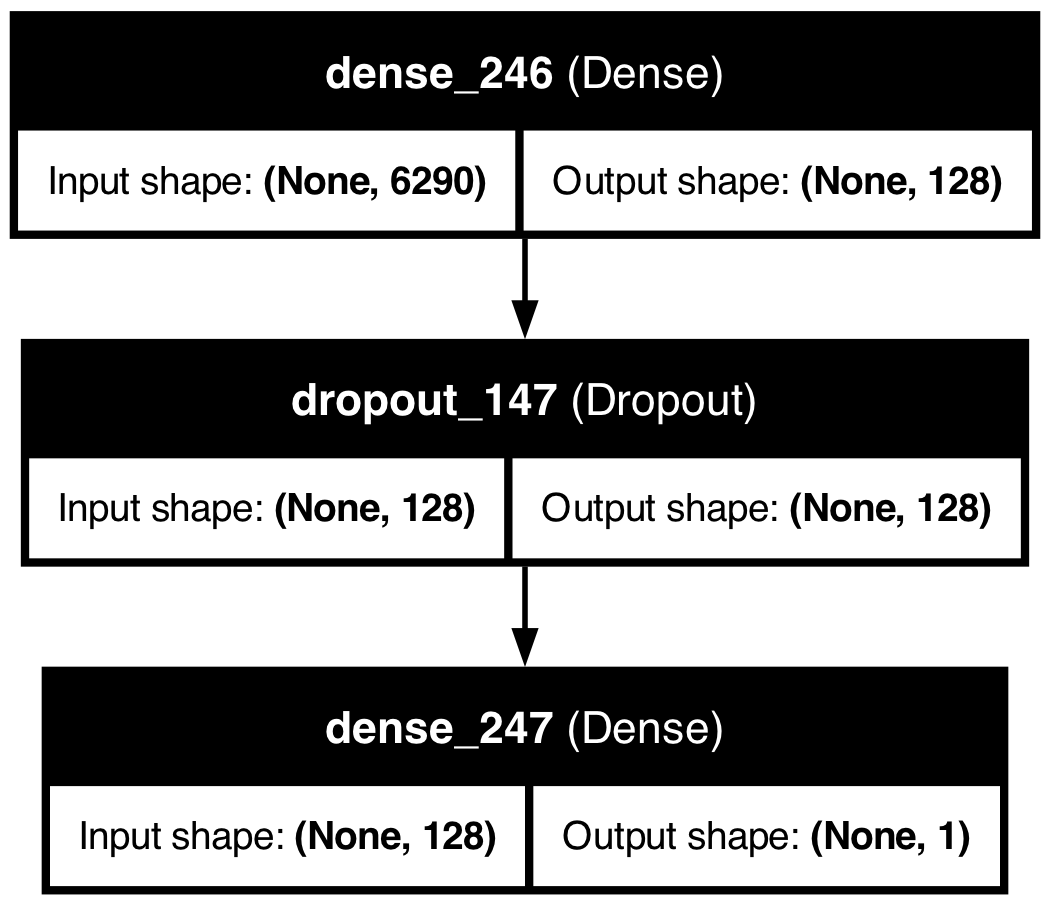

In [34]:
# Generate the plot
plot_model(model_1rTI, show_shapes=True, show_layer_names=True)

Epoch 1/300
240/248 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5934 - loss: 0.8578
Epoch 1: val_loss improved from inf to 0.71421, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5962 - loss: 0.8555 - val_accuracy: 0.7481 - val_loss: 0.7142 - learning_rate: 1.0000e-04
Epoch 2/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7672 - loss: 0.6987
Epoch 2: val_loss improved from 0.71421 to 0.66905, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7673 - loss: 0.6987 - val_accuracy: 0.7709 - val_loss: 0.6691 - learning_rate: 1.0000e-04
Epoch 3/300
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7913 - loss: 0.6565
Epoch 3: val_loss improved from 0.66905 to 0.64100, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7913 - loss: 0.6565 - val_accuracy: 0.7699 - val_loss: 0.6410 - learning_rate: 1.0000e-04
Epoch 4/300
244/248 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

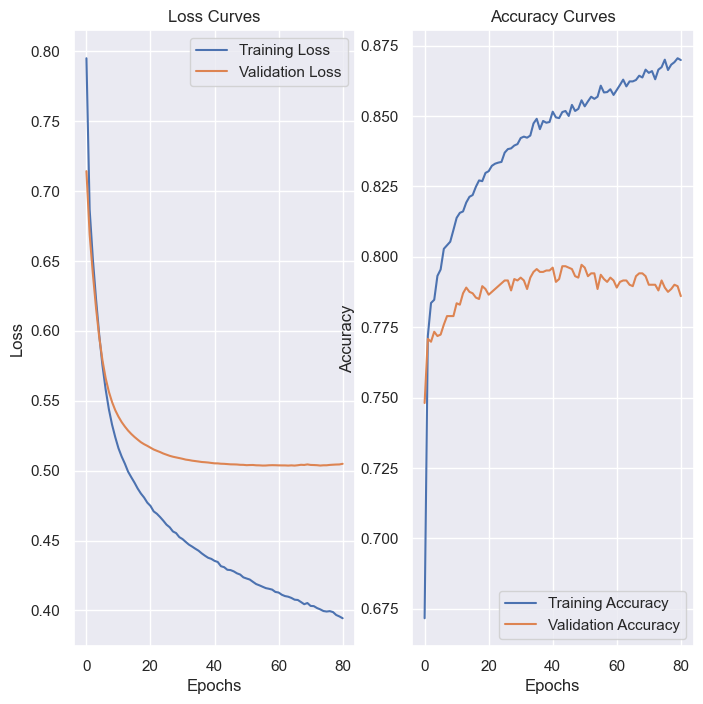

In [35]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1rTI_history = model_1rTI.fit(
    rX_train_tfidf, ry_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_1rTI_history)

In [36]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_1rTI.predict(rX_test_tfidf)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1rTI_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m1rTI_accuracy = accuracy_score(ry_test, ry_pred)
m1rTI_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1rTI_recall = recall_score(ry_test, ry_pred, average='weighted')
m1rTI_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1rTI_accuracy:.2%}", f"{m1rTI_precision:.3f}", f"{m1rTI_recall:.3f}", f"{m1rTI_f1:.3f}", f"{m1rTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model Performance          Results
         accuracy           79.49%
        precision            0.797
           recall            0.795
         f1_score            0.795
    time/instance 0.000296 seconds


In [37]:
store_results('Model_1rTI', m1rTI_accuracy, m1rTI_precision, m1rTI_recall, m1rTI_f1, m1rTI_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3  Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds


#### Word2Vec Vectorization

In [38]:
# Tokenize reviews
cleaned_train['tokenized_reviews'] = cleaned_train['review'].apply(gensim.utils.simple_preprocess)
cleaned_test['tokenized_reviews'] = cleaned_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_c = Word2Vec(sentences=cleaned_train['tokenized_reviews'], vector_size=250, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
cX_train_vec = vectorize_reviews(cleaned_train['tokenized_reviews'], word2vec_model_c)
cX_test_vec = vectorize_reviews(cleaned_test['tokenized_reviews'], word2vec_model_c)

In [39]:
# Tokenize reviews
raw_train['tokenized_reviews'] = raw_train['review'].apply(gensim.utils.simple_preprocess)
raw_test['tokenized_reviews'] = raw_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_r = Word2Vec(sentences=raw_train['tokenized_reviews'], vector_size=250, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
rX_train_vec = vectorize_reviews(raw_train['tokenized_reviews'], word2vec_model_r)
rX_test_vec = vectorize_reviews(raw_test['tokenized_reviews'], word2vec_model_r)

#### FNN with cleaned data (Word2Vec)

In [40]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(cX_train_vec.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [41]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(cX_train_vec, cy_train, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5122 - loss: 0.6958
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5572 - loss: 0.6829
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5514 - loss: 0.6824
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5926 - loss: 0.6720
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5998 - loss: 0.6656
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6050 - loss: 0.6616
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6080 - loss: 0.6592
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6241 - loss: 0.6503
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6366 - loss: 0.6398
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6368 - loss: 0.6388
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6547 - loss: 0.6247
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5171 - loss: 0.6954
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5346 - loss: 0.6883
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5495 - loss: 0.6859
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5727 - loss: 0.6792
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6073 - loss: 0.6691
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6036 - loss: 0.6637
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6186 - loss: 0.6593
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6267 - loss: 0.6532
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6405 - loss: 0.6448
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6445 - loss: 0.6394
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6442 - loss: 0.6296
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5083 - loss: 0.6957
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5438 - loss: 0.6861  
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5609 - loss: 0.6804  
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5970 - loss: 0.6715
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6042 - loss: 0.6670
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6289 - loss: 0.6585
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6230 - loss: 0.6529
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6358 - loss: 0.6424
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6344 - loss: 0.6368  
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6536 - loss: 0.6325
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6705 - loss: 0.6222
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - ac

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5196 - loss: 0.8180
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5207 - loss: 0.7352
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5442 - loss: 0.7126  
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5498 - loss: 0.7050  
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5573 - loss: 0.6988
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5567 - loss: 0.6963
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5504 - loss: 0.6956
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5412 - loss: 0.6938
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.5533 - loss: 0.6935
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5435 - loss: 0.6930  
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5490 - loss: 0.6923
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5032 - loss: 0.8170
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5232 - loss: 0.7347
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5462 - loss: 0.7129  
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.5218 - loss: 0.7077
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.5439 - loss: 0.6981
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.5412 - loss: 0.6976
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.5444 - loss: 0.6962
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.5525 - loss: 0.6929
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.5492 - loss: 0.6933
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.5410 - loss: 0.6935
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.5419 - loss: 0.6939
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 9

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5080 - loss: 0.8121
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5439 - loss: 0.7283
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5253 - loss: 0.7123  
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5498 - loss: 0.7020  
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5396 - loss: 0.7000
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5413 - loss: 0.6958  
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.5515 - loss: 0.6922
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.5458 - loss: 0.6943
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.5487 - loss: 0.6930
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.5603 - loss: 0.6891
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.5469 - loss: 0.6914
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5243 - loss: 0.6937
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5300 - loss: 0.6926
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5556 - loss: 0.6843
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5786 - loss: 0.6793
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6030 - loss: 0.6705
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6070 - loss: 0.6623
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6181 - loss: 0.6500
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6421 - loss: 0.6412
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6326 - loss: 0.6298
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6426 - loss: 0.6346
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6521 - loss: 0.6199
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5153 - loss: 0.6943
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5171 - loss: 0.6923
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5584 - loss: 0.6850
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5806 - loss: 0.6779
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5985 - loss: 0.6712
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6057 - loss: 0.6657
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6352 - loss: 0.6477
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6308 - loss: 0.6443
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6315 - loss: 0.6438
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6563 - loss: 0.6219
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6523 - loss: 0.6172
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5148 - loss: 0.6937
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5088 - loss: 0.6955
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5572 - loss: 0.6856
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5826 - loss: 0.6781
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5960 - loss: 0.6702
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6058 - loss: 0.6588
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6338 - loss: 0.6427
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6406 - loss: 0.6329
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6344 - loss: 0.6345
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6553 - loss: 0.6211
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6680 - loss: 0.6119
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5118 - loss: 0.8739
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5269 - loss: 0.7392
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5152 - loss: 0.7113
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4974 - loss: 0.7016
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5027 - loss: 0.6973
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5139 - loss: 0.6953
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5153 - loss: 0.6939
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5065 - loss: 0.6936
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5093 - loss: 0.6933
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5200 - loss: 0.6932
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5021 - loss: 0.6935
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4917 - loss: 0.8704
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5089 - loss: 0.7351
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5103 - loss: 0.7081
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5152 - loss: 0.6982
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5045 - loss: 0.6962
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5215 - loss: 0.6938
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5159 - loss: 0.6937
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5089 - loss: 0.6940
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5133 - loss: 0.6937
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5013 - loss: 0.6940
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5014 - loss: 0.6937
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5130 - loss: 0.8772
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5112 - loss: 0.7434
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4999 - loss: 0.7132
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5124 - loss: 0.7025
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4965 - loss: 0.6975
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5046 - loss: 0.6958
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5033 - loss: 0.6954
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5137 - loss: 0.6944
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5079 - loss: 0.6934
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5011 - loss: 0.6937
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5076 - loss: 0.6941
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5123 - loss: 0.6953
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5529 - loss: 0.6825
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5741 - loss: 0.6792
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5959 - loss: 0.6688
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6168 - loss: 0.6611
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6085 - loss: 0.6560
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6326 - loss: 0.6501
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6369 - loss: 0.6400
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6213 - loss: 0.6473
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6380 - loss: 0.6296
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6495 - loss: 0.6288
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5048 - loss: 0.6962
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5639 - loss: 0.6833
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5862 - loss: 0.6747
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6005 - loss: 0.6704
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6166 - loss: 0.6604
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6319 - loss: 0.6539
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6165 - loss: 0.6490
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6306 - loss: 0.6454
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6448 - loss: 0.6332
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6448 - loss: 0.6358
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6532 - loss: 0.6227
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5132 - loss: 0.6955
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5400 - loss: 0.6870
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5784 - loss: 0.6802
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5951 - loss: 0.6687
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6010 - loss: 0.6604
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6406 - loss: 0.6464
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6221 - loss: 0.6467
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6297 - loss: 0.6402
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6460 - loss: 0.6337
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6619 - loss: 0.6282
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6640 - loss: 0.6206
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4995 - loss: 0.8712
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5360 - loss: 0.7372
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5367 - loss: 0.7134
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5458 - loss: 0.7037
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5435 - loss: 0.6998
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5395 - loss: 0.6971
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5430 - loss: 0.6958
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5249 - loss: 0.6962
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5452 - loss: 0.6945
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5439 - loss: 0.6942
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5457 - loss: 0.6927
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5002 - loss: 0.8667
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5352 - loss: 0.7388
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5225 - loss: 0.7129
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5321 - loss: 0.7054
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5201 - loss: 0.7006
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5466 - loss: 0.6957
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5324 - loss: 0.6944
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5472 - loss: 0.6929
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5456 - loss: 0.6939
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5577 - loss: 0.6916
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5470 - loss: 0.6922
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5242 - loss: 0.8622
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5222 - loss: 0.7358
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5372 - loss: 0.7138
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5400 - loss: 0.7018
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5430 - loss: 0.6978
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5363 - loss: 0.6971
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5331 - loss: 0.6956
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5516 - loss: 0.6931
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5347 - loss: 0.6946
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5580 - loss: 0.6916
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5450 - loss: 0.6935
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5075 - loss: 0.6966
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5441 - loss: 0.6888
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5724 - loss: 0.6797
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5888 - loss: 0.6720
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6128 - loss: 0.6570
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6215 - loss: 0.6490
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6369 - loss: 0.6386
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6408 - loss: 0.6288
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6498 - loss: 0.6252
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6592 - loss: 0.6144
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6628 - loss: 0.6146
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4971 - loss: 0.6972
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5255 - loss: 0.6917
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5482 - loss: 0.6865
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5938 - loss: 0.6742
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6039 - loss: 0.6662
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6209 - loss: 0.6561
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6333 - loss: 0.6420
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6505 - loss: 0.6257
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6611 - loss: 0.6199
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6677 - loss: 0.6146
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6546 - loss: 0.6170
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5093 - loss: 0.6954
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5296 - loss: 0.6914
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5628 - loss: 0.6844
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5934 - loss: 0.6730
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6100 - loss: 0.6558
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6336 - loss: 0.6411
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6375 - loss: 0.6334
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6609 - loss: 0.6230
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6629 - loss: 0.6170
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6715 - loss: 0.6118
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6700 - loss: 0.6050
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5006 - loss: 0.9754
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5135 - loss: 0.7465
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5130 - loss: 0.7095
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5091 - loss: 0.6994
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5076 - loss: 0.6955
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5148 - loss: 0.6949
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5223 - loss: 0.6944
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5119 - loss: 0.6946
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5098 - loss: 0.6940
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4960 - loss: 0.6938
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5057 - loss: 0.6942
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5151 - loss: 0.9738
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5142 - loss: 0.7441
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5195 - loss: 0.7073
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5188 - loss: 0.6981
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5216 - loss: 0.6949
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5083 - loss: 0.6950
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5168 - loss: 0.6938
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5242 - loss: 0.6940
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5134 - loss: 0.6939
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5115 - loss: 0.6933
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5235 - loss: 0.6935
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5055 - loss: 0.9787
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5104 - loss: 0.7449
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4995 - loss: 0.7102
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4917 - loss: 0.6992
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4993 - loss: 0.6960
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5043 - loss: 0.6943
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5094 - loss: 0.6945
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5093 - loss: 0.6938
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5075 - loss: 0.6938
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5132 - loss: 0.6931
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5030 - loss: 0.6938
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4992 - loss: 0.6949
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4973 - loss: 0.6942
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5195 - loss: 0.6920
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5264 - loss: 0.6916
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5403 - loss: 0.6907
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5461 - loss: 0.6892
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5273 - loss: 0.6894
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5508 - loss: 0.6882
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5796 - loss: 0.6844
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5630 - loss: 0.6851
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5804 - loss: 0.6847
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4830 - loss: 0.6963
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5230 - loss: 0.6922
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5306 - loss: 0.6899
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5291 - loss: 0.6915
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5299 - loss: 0.6900
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5560 - loss: 0.6891
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5385 - loss: 0.6881
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5665 - loss: 0.6857
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5698 - loss: 0.6859
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5791 - loss: 0.6826
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5909 - loss: 0.6827
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4985 - loss: 0.6956
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5060 - loss: 0.6934
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5266 - loss: 0.6912
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5390 - loss: 0.6908
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5526 - loss: 0.6885
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5470 - loss: 0.6887
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5642 - loss: 0.6872  
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5679 - loss: 0.6860
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5905 - loss: 0.6838
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5841 - loss: 0.6825  
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5929 - loss: 0.6801
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accu

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.5075 - loss: 0.8574
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5217 - loss: 0.8295
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5113 - loss: 0.8097
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5240 - loss: 0.7915
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5298 - loss: 0.7778
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5359 - loss: 0.7688
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5416 - loss: 0.7597
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5395 - loss: 0.7533
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5504 - loss: 0.7467
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5462 - loss: 0.7427
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5468 - loss: 0.7397
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5036 - loss: 0.8554
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5099 - loss: 0.8228
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5031 - loss: 0.8015
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5248 - loss: 0.7831
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5339 - loss: 0.7683
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5388 - loss: 0.7584
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5407 - loss: 0.7500
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5454 - loss: 0.7444
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5482 - loss: 0.7381
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5597 - loss: 0.7334
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5579 - loss: 0.7301
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4984 - loss: 0.8580
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5123 - loss: 0.8296
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5208 - loss: 0.8079
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5105 - loss: 0.7933
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5151 - loss: 0.7798
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5305 - loss: 0.7677
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5298 - loss: 0.7594
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5296 - loss: 0.7543  
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5505 - loss: 0.7469
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5583 - loss: 0.7426   
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5530 - loss: 0.7386  
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5028 - loss: 0.6933
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5067 - loss: 0.6927
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5175 - loss: 0.6929
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5294 - loss: 0.6917
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5352 - loss: 0.6904
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5505 - loss: 0.6893
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5524 - loss: 0.6884
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5689 - loss: 0.6860
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5498 - loss: 0.6872
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5671 - loss: 0.6844
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5632 - loss: 0.6835
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5017 - loss: 0.6944
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5125 - loss: 0.6933
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5240 - loss: 0.6919
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5414 - loss: 0.6907
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5220 - loss: 0.6908
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5383 - loss: 0.6897
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5444 - loss: 0.6901
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5506 - loss: 0.6873
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5749 - loss: 0.6862
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5675 - loss: 0.6856
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5760 - loss: 0.6837
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5156 - loss: 0.6925
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5077 - loss: 0.6929
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5363 - loss: 0.6913
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5302 - loss: 0.6905
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5341 - loss: 0.6906
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5385 - loss: 0.6891
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5572 - loss: 0.6881
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5526 - loss: 0.6878
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5636 - loss: 0.6855
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5714 - loss: 0.6838
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5875 - loss: 0.6814
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5049 - loss: 0.9368
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5113 - loss: 0.8930
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5265 - loss: 0.8586
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5204 - loss: 0.8330
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5148 - loss: 0.8122
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5284 - loss: 0.7946
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5184 - loss: 0.7806
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5278 - loss: 0.7690
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5213 - loss: 0.7598
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5231 - loss: 0.7517
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5198 - loss: 0.7447
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4962 - loss: 0.9375
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5101 - loss: 0.8954
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5047 - loss: 0.8614
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5217 - loss: 0.8352
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5184 - loss: 0.8135
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5275 - loss: 0.7963
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5364 - loss: 0.7821
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5190 - loss: 0.7708
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5315 - loss: 0.7599
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5298 - loss: 0.7518
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5274 - loss: 0.7445
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5042 - loss: 0.9375
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5006 - loss: 0.8975
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5200 - loss: 0.8635
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5251 - loss: 0.8372
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5264 - loss: 0.8162
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5206 - loss: 0.7990
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5289 - loss: 0.7845
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5257 - loss: 0.7730
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5166 - loss: 0.7637
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5336 - loss: 0.7546
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5328 - loss: 0.7475
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4784 - loss: 0.6959
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5156 - loss: 0.6928
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5329 - loss: 0.6902
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5522 - loss: 0.6887
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5575 - loss: 0.6871
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5590 - loss: 0.6853
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5769 - loss: 0.6844
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5930 - loss: 0.6801
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5928 - loss: 0.6798
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5833 - loss: 0.6799
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5928 - loss: 0.6781
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5109 - loss: 0.6935
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5138 - loss: 0.6932
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5371 - loss: 0.6908
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5331 - loss: 0.6895
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5530 - loss: 0.6859
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5516 - loss: 0.6877
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5779 - loss: 0.6852
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5845 - loss: 0.6829
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5712 - loss: 0.6831
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5881 - loss: 0.6794
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6053 - loss: 0.6774
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5103 - loss: 0.6938
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5108 - loss: 0.6918
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5305 - loss: 0.6907
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5396 - loss: 0.6887
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5531 - loss: 0.6867
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5680 - loss: 0.6848
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5877 - loss: 0.6839
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5683 - loss: 0.6840
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5793 - loss: 0.6826
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6021 - loss: 0.6788
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6112 - loss: 0.6774
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4942 - loss: 0.9320
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5135 - loss: 0.8803
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5265 - loss: 0.8415
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5311 - loss: 0.8156
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5262 - loss: 0.7969
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5348 - loss: 0.7814
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5418 - loss: 0.7695
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5567 - loss: 0.7591
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5551 - loss: 0.7523
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5502 - loss: 0.7462
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5586 - loss: 0.7400
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4847 - loss: 0.9338
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5160 - loss: 0.8830
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5270 - loss: 0.8455
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5428 - loss: 0.8187
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5231 - loss: 0.8001
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5444 - loss: 0.7838
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5437 - loss: 0.7726
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5505 - loss: 0.7618
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5567 - loss: 0.7546
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5644 - loss: 0.7479
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5740 - loss: 0.7409
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5020 - loss: 0.9331
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5009 - loss: 0.8830
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5355 - loss: 0.8439
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5278 - loss: 0.8174
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5467 - loss: 0.7972
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5327 - loss: 0.7837
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5326 - loss: 0.7715
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5661 - loss: 0.7607
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5607 - loss: 0.7528
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5664 - loss: 0.7459
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5601 - loss: 0.7400
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4938 - loss: 0.6941
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5116 - loss: 0.6930
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5250 - loss: 0.6922
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5397 - loss: 0.6896
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5524 - loss: 0.6880
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5504 - loss: 0.6882
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5467 - loss: 0.6859
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5537 - loss: 0.6866
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5898 - loss: 0.6794
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5832 - loss: 0.6762
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5970 - loss: 0.6740
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5130 - loss: 0.6931
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5122 - loss: 0.6924
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5261 - loss: 0.6911
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5347 - loss: 0.6897
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5336 - loss: 0.6907
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5569 - loss: 0.6862
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5617 - loss: 0.6871
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5812 - loss: 0.6811
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5984 - loss: 0.6767
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5956 - loss: 0.6770
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5939 - loss: 0.6745
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5048 - loss: 0.6933
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4963 - loss: 0.6944
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5390 - loss: 0.6912
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5191 - loss: 0.6911
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5652 - loss: 0.6877
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5609 - loss: 0.6868
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5641 - loss: 0.6842
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5710 - loss: 0.6817
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6026 - loss: 0.6786
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6127 - loss: 0.6737
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6097 - loss: 0.6723
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5083 - loss: 1.0950
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5016 - loss: 1.0088
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5257 - loss: 0.9430
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5256 - loss: 0.8927
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5226 - loss: 0.8565
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5162 - loss: 0.8279
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5442 - loss: 0.8036
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5229 - loss: 0.7868
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5262 - loss: 0.7720
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5404 - loss: 0.7598
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5314 - loss: 0.7511
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5065 - loss: 1.0930
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4948 - loss: 1.0035
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5173 - loss: 0.9339
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5101 - loss: 0.8848
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5131 - loss: 0.8463
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5256 - loss: 0.8166
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5110 - loss: 0.7944
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5196 - loss: 0.7771
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5298 - loss: 0.7623
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5328 - loss: 0.7513
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5303 - loss: 0.7428
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5086 - loss: 1.0909
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5039 - loss: 1.0024
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5373 - loss: 0.9353
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5262 - loss: 0.8864
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5158 - loss: 0.8496
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5291 - loss: 0.8195
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5340 - loss: 0.7974
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5395 - loss: 0.7803
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5291 - loss: 0.7663
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 0.7554
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5323 - loss: 0.7458
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5179 - loss: 0.6951
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5696 - loss: 0.6779
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6041 - loss: 0.6661
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6085 - loss: 0.6580
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6328 - loss: 0.6411
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6427 - loss: 0.6361
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6523 - loss: 0.6261
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6495 - loss: 0.6251
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6599 - loss: 0.6162
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6682 - loss: 0.6109
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6612 - loss: 0.6150
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

In [42]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.713679 using {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.711149 (0.006231) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.580636 (0.043861) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.683929 (0.029178) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.500607 (0.001195) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.713679 (0.009823) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.555947 (0.014053) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.712364 (0.008422) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.496763 (0.011991) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.639317 (0.006771) with: {'learning_rate': 

In [43]:
# Extract the best parameters
best_params = grid_result.best_params_

In [44]:
# Create the final model using the best parameters
model_1cWV = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1cWV.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_370 (Dense)               │ (None, 256)            │        64,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_221 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_371 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,513 (252.00 KB)

 Trainable params: 64,513 (252.00 KB)

 Non-trainable params: 0 (0.00 B)

None


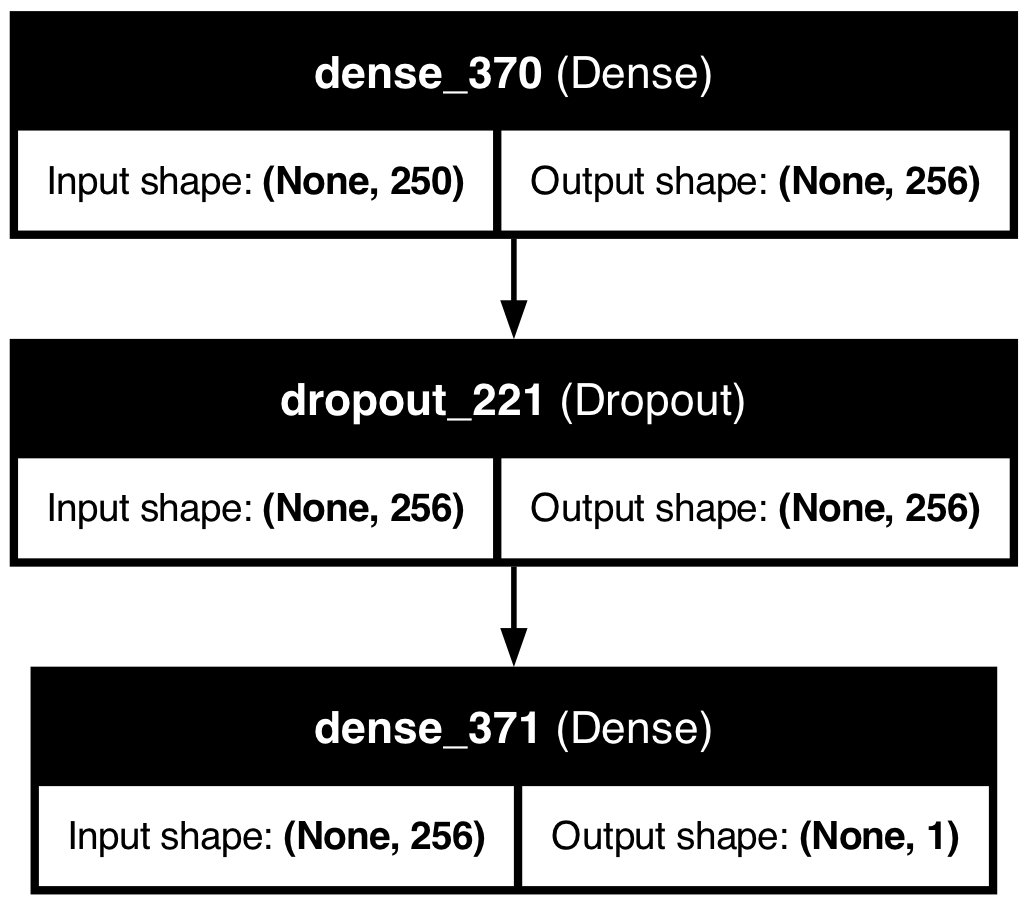

In [45]:
# Generate the plot
plot_model(model_1cWV, show_shapes=True, show_layer_names=True)

Epoch 1/300
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5118 - loss: 0.6960
Epoch 1: val_loss improved from inf to 0.67955, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5119 - loss: 0.6959 - val_accuracy: 0.6287 - val_loss: 0.6795 - learning_rate: 0.0010
Epoch 2/300
235/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5589 - loss: 0.6847
Epoch 2: val_loss improved from 0.67955 to 0.67210, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5595 - loss: 0.6845 - val_accuracy: 0.5837 - val_loss: 0.6721 - learning_rate: 0.0010
Epoch 3/300
243/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5841 - loss: 0.6738
Epoch 3: val_loss improved from 0.67210 to 0.66171, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5842 - loss: 0.6738 - val_accuracy: 0.6464 - val_loss: 0.6617 - learning_rate: 0.0010
Epoch 4/300
227/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

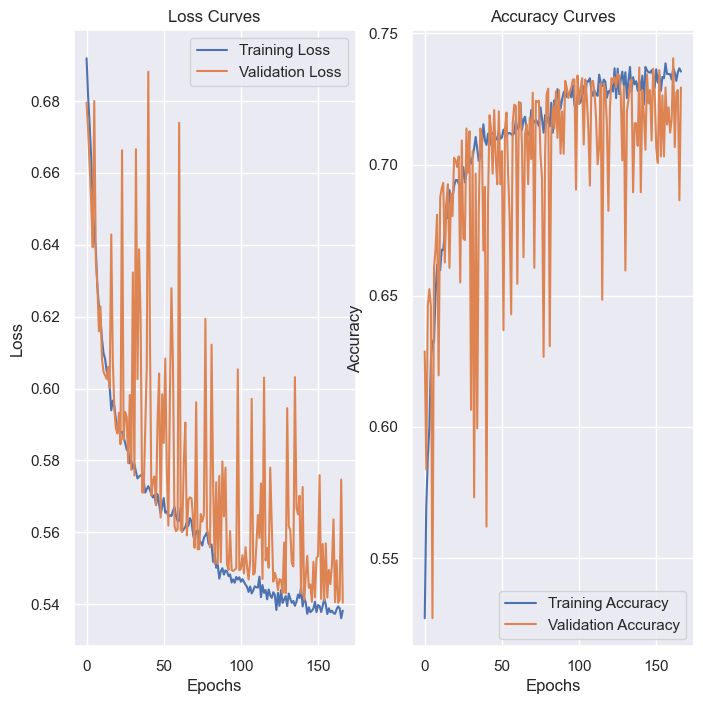

In [46]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1cWV_history = model_1cWV.fit(
    cX_train_vec, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with model's history
plot_loss_curves(model_1cWV_history)

In [47]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_1cWV.predict(cX_test_vec)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1cWV_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m1cWV_accuracy = accuracy_score(cy_test, cy_pred)
m1cWV_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1cWV_recall = recall_score(cy_test, cy_pred, average='weighted')
m1cWV_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1cWV_accuracy:.2%}", f"{m1cWV_precision:.3f}", f"{m1cWV_recall:.3f}", f"{m1cWV_f1:.3f}", f"{m1cWV_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Performance          Results
         accuracy           74.07%
        precision            0.743
           recall            0.741
         f1_score            0.740
    time/instance 0.000223 seconds


In [48]:
store_results('Model_1cWV', m1cWV_accuracy, m1cWV_precision, m1cWV_recall, m1cWV_f1, m1cWV_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3  Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4  Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds


#### FNN with raw data (Word2Vec)

In [49]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(rX_train_vec.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [50]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(rX_train_vec, ry_train, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/30


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5684 - loss: 0.6753
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6125 - loss: 0.6575
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6316 - loss: 0.6470
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6433 - loss: 0.6368
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6461 - loss: 0.6321
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6475 - loss: 0.6324
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6648 - loss: 0.6204  
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.6503 - loss: 0.6194
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6665 - loss: 0.6091
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6594 - loss: 0.6192
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6639 - loss: 0.6096  
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - ac

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5888 - loss: 0.6705
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6138 - loss: 0.6543
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6399 - loss: 0.6464
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6488 - loss: 0.6328
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6512 - loss: 0.6301
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6621 - loss: 0.6195
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6531 - loss: 0.6242
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6550 - loss: 0.6183
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6608 - loss: 0.6155
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6716 - loss: 0.5999
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6720 - loss: 0.6036
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5824 - loss: 0.6719
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6299 - loss: 0.6500
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6260 - loss: 0.6435
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6546 - loss: 0.6305
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6547 - loss: 0.6286
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6524 - loss: 0.6197
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6444 - loss: 0.6207
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6595 - loss: 0.6109
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6644 - loss: 0.6129
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6586 - loss: 0.6098
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6757 - loss: 0.5944
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5750 - loss: 0.8007
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6069 - loss: 0.7102
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6230 - loss: 0.6869
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6246 - loss: 0.6772
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6291 - loss: 0.6684
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6311 - loss: 0.6658
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6300 - loss: 0.6616
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.6252 - loss: 0.6578
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6317 - loss: 0.6558
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.6250 - loss: 0.6602
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6327 - loss: 0.6580  
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - ac

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5861 - loss: 0.8019
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.6139 - loss: 0.7133
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6275 - loss: 0.6890  
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.6389 - loss: 0.6765
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6191 - loss: 0.6751
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.6375 - loss: 0.6662
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.6266 - loss: 0.6655
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.6353 - loss: 0.6617
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6365 - loss: 0.6568
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.6291 - loss: 0.6578
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6447 - loss: 0.6483  
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 99

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5790 - loss: 0.8045
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6158 - loss: 0.7115
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.6261 - loss: 0.6909
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.6075 - loss: 0.6816
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6193 - loss: 0.6787  
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.6271 - loss: 0.6647
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.6369 - loss: 0.6548
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.6417 - loss: 0.6532
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.6278 - loss: 0.6573
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6387 - loss: 0.6517
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6285 - loss: 0.6536
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5601 - loss: 0.6762
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6345 - loss: 0.6520
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6343 - loss: 0.6425
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6370 - loss: 0.6347
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6517 - loss: 0.6276
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6525 - loss: 0.6193
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6739 - loss: 0.6095
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6589 - loss: 0.6125
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6684 - loss: 0.6090
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6590 - loss: 0.6104
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6651 - loss: 0.6024
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5688 - loss: 0.6771
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6228 - loss: 0.6561
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6254 - loss: 0.6483
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6489 - loss: 0.6337
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6518 - loss: 0.6260
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6658 - loss: 0.6175
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6629 - loss: 0.6156
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6645 - loss: 0.6082
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6747 - loss: 0.6041
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6743 - loss: 0.6026
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6738 - loss: 0.6037
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5602 - loss: 0.6790
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6220 - loss: 0.6536
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6361 - loss: 0.6426
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6455 - loss: 0.6332
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6555 - loss: 0.6242
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6641 - loss: 0.6159
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6584 - loss: 0.6113
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6560 - loss: 0.6194
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6606 - loss: 0.6065
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6743 - loss: 0.5982
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6744 - loss: 0.6018
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5621 - loss: 0.8672
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6113 - loss: 0.7357
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6172 - loss: 0.6970
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6196 - loss: 0.6814
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6191 - loss: 0.6782
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6155 - loss: 0.6756
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6370 - loss: 0.6596
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.6707
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6341 - loss: 0.6594
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6360 - loss: 0.6560
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6444 - loss: 0.6546
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5571 - loss: 0.8793
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6213 - loss: 0.7405
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6213 - loss: 0.7054
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6246 - loss: 0.6852
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6407 - loss: 0.6699
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6383 - loss: 0.6658
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6449 - loss: 0.6587
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6228 - loss: 0.6653
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6412 - loss: 0.6618
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6445 - loss: 0.6536
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6321 - loss: 0.6573
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5667 - loss: 0.8670
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6093 - loss: 0.7275
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6167 - loss: 0.6936
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6102 - loss: 0.6817
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6088 - loss: 0.6791
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6170 - loss: 0.6738
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6448 - loss: 0.6598
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6346 - loss: 0.6569
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6559 - loss: 0.6506
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6415 - loss: 0.6473
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6298 - loss: 0.6573
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6000 - loss: 0.6685
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6291 - loss: 0.6556
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6377 - loss: 0.6357
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6417 - loss: 0.6300
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6512 - loss: 0.6259
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6461 - loss: 0.6338
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6515 - loss: 0.6157
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6456 - loss: 0.6170
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6603 - loss: 0.6153
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6767 - loss: 0.6060
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6742 - loss: 0.5975
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5777 - loss: 0.6743
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6305 - loss: 0.6551
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6402 - loss: 0.6366
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6402 - loss: 0.6318
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6515 - loss: 0.6231
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6462 - loss: 0.6207
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6707 - loss: 0.6113
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6603 - loss: 0.6176
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6779 - loss: 0.6011
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6787 - loss: 0.6042
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6796 - loss: 0.5980
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5787 - loss: 0.6711
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6229 - loss: 0.6484
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6408 - loss: 0.6391
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6483 - loss: 0.6247
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6524 - loss: 0.6221
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6643 - loss: 0.6144
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6602 - loss: 0.6178
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6574 - loss: 0.6101
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6640 - loss: 0.6031
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6741 - loss: 0.6022
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6789 - loss: 0.5996
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accurac

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5676 - loss: 0.8541
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6131 - loss: 0.7134
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6186 - loss: 0.6874
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6186 - loss: 0.6762
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6246 - loss: 0.6691
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6256 - loss: 0.6683
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6304 - loss: 0.6582
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6230 - loss: 0.6624
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6333 - loss: 0.6571
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6351 - loss: 0.6572
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6335 - loss: 0.6563
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5635 - loss: 0.8624
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6249 - loss: 0.7161
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6270 - loss: 0.6888
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6213 - loss: 0.6746
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6330 - loss: 0.6670
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6304 - loss: 0.6667
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6275 - loss: 0.6602
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6302 - loss: 0.6612
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6342 - loss: 0.6572
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6351 - loss: 0.6596
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6331 - loss: 0.6557
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5669 - loss: 0.8551
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6041 - loss: 0.7195
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6040 - loss: 0.6934
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6373 - loss: 0.6690
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6309 - loss: 0.6703
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6281 - loss: 0.6662
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6299 - loss: 0.6593
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6422 - loss: 0.6545
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6404 - loss: 0.6548
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6386 - loss: 0.6480
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6306 - loss: 0.6590
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5887 - loss: 0.6726
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6227 - loss: 0.6521
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6296 - loss: 0.6478
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6277 - loss: 0.6407
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6448 - loss: 0.6229
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6625 - loss: 0.6177
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6495 - loss: 0.6209
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6597 - loss: 0.6200
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6658 - loss: 0.6097
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6664 - loss: 0.6120
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6791 - loss: 0.6063
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5721 - loss: 0.6770
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6318 - loss: 0.6485
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6308 - loss: 0.6399
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6466 - loss: 0.6310
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6518 - loss: 0.6237
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6620 - loss: 0.6145
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6579 - loss: 0.6096
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6585 - loss: 0.6115
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6654 - loss: 0.6096
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6747 - loss: 0.6054
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6710 - loss: 0.6026
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5830 - loss: 0.6716
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6356 - loss: 0.6505
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6413 - loss: 0.6329
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6448 - loss: 0.6278
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6465 - loss: 0.6240
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6614 - loss: 0.6147
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6546 - loss: 0.6128
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6777 - loss: 0.5966
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6756 - loss: 0.6030
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6741 - loss: 0.5996
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6856 - loss: 0.5945
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5666 - loss: 0.9766
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6085 - loss: 0.7476
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6243 - loss: 0.6921
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6319 - loss: 0.6777
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6440 - loss: 0.6644
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6195 - loss: 0.6652
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6436 - loss: 0.6579
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6344 - loss: 0.6575
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6310 - loss: 0.6574
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6371 - loss: 0.6535
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6413 - loss: 0.6581
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5634 - loss: 0.9724
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6139 - loss: 0.7393
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6154 - loss: 0.6979
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6271 - loss: 0.6793
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6144 - loss: 0.6779
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6210 - loss: 0.6714
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6238 - loss: 0.6640
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6384 - loss: 0.6546
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6405 - loss: 0.6617
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6337 - loss: 0.6595
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6366 - loss: 0.6579
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5751 - loss: 0.9677
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6178 - loss: 0.7422
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6270 - loss: 0.6983
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6187 - loss: 0.6849
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6342 - loss: 0.6662
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6249 - loss: 0.6630
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6244 - loss: 0.6677
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6476 - loss: 0.6541
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6306 - loss: 0.6608
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6451 - loss: 0.6562
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6454 - loss: 0.6502
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5309 - loss: 0.6911
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6052 - loss: 0.6725
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5973 - loss: 0.6649  
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.6103 - loss: 0.6635
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6061 - loss: 0.6592  
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6093 - loss: 0.6563  
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6217 - loss: 0.6527  
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6285 - loss: 0.6505  
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6265 - loss: 0.6510  
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6183 - loss: 0.6512  
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6403 - loss: 0.6473  
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 9

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5412 - loss: 0.6893
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6073 - loss: 0.6702
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6125 - loss: 0.6650  
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.6085 - loss: 0.6623
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6131 - loss: 0.6586  
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6213 - loss: 0.6546  
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.6371 - loss: 0.6516
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.6302 - loss: 0.6472
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.6395 - loss: 0.6436
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.6282 - loss: 0.6505
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.6317 - loss: 0.6508
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5315 - loss: 0.6882
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5926 - loss: 0.6734
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6099 - loss: 0.6626
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6081 - loss: 0.6610  
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.6208 - loss: 0.6575
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6135 - loss: 0.6554  
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6324 - loss: 0.6499  
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6400 - loss: 0.6450  
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6230 - loss: 0.6488  
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6274 - loss: 0.6461  
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6392 - loss: 0.6438  
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5318 - loss: 0.8527
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6094 - loss: 0.8108
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6013 - loss: 0.7856
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6081 - loss: 0.7679
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6259 - loss: 0.7519
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6301 - loss: 0.7372
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6163 - loss: 0.7365
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6280 - loss: 0.7232
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6188 - loss: 0.7176
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6191 - loss: 0.7142
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6325 - loss: 0.7090
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5268 - loss: 0.8532
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 0.8138  
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6080 - loss: 0.7867  
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.6024 - loss: 0.7739
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6182 - loss: 0.7595
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.6192 - loss: 0.7462
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.6329 - loss: 0.7350
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.6336 - loss: 0.7307
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.6237 - loss: 0.7247
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6290 - loss: 0.7210  
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6191 - loss: 0.7185
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5507 - loss: 0.8483
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.5850 - loss: 0.8119
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.5992 - loss: 0.7870
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6049 - loss: 0.7671  
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6185 - loss: 0.7554  
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.6297 - loss: 0.7411
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.6268 - loss: 0.7286
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.6243 - loss: 0.7270
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.6130 - loss: 0.7255
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.7213  
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.6231 - loss: 0.7129
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5352 - loss: 0.6922
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5793 - loss: 0.6783
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6125 - loss: 0.6651
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6057 - loss: 0.6619
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6140 - loss: 0.6557
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6290 - loss: 0.6468
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6293 - loss: 0.6484
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6337 - loss: 0.6531
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6338 - loss: 0.6511
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6272 - loss: 0.6510
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6450 - loss: 0.6389
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5162 - loss: 0.6911
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5924 - loss: 0.6760
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6103 - loss: 0.6642
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6090 - loss: 0.6647
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6215 - loss: 0.6609
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6192 - loss: 0.6574
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6254 - loss: 0.6548
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6235 - loss: 0.6555
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6375 - loss: 0.6434
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6436 - loss: 0.6467
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6473 - loss: 0.6418
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5173 - loss: 0.6924
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5920 - loss: 0.6768
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6036 - loss: 0.6632
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6115 - loss: 0.6581
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6064 - loss: 0.6595
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6187 - loss: 0.6611
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6198 - loss: 0.6520
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6346 - loss: 0.6473
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6454 - loss: 0.6427
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6309 - loss: 0.6503
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6494 - loss: 0.6383
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5184 - loss: 0.9355
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5714 - loss: 0.8879
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5966 - loss: 0.8507
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5961 - loss: 0.8225
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6096 - loss: 0.8015
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5955 - loss: 0.7941
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6179 - loss: 0.7714
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6139 - loss: 0.7608
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6137 - loss: 0.7504
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6279 - loss: 0.7374
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6403 - loss: 0.7340
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5172 - loss: 0.9386
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5945 - loss: 0.8880
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6044 - loss: 0.8509
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6101 - loss: 0.8237
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6142 - loss: 0.8007
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6051 - loss: 0.7886
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6203 - loss: 0.7726
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6251 - loss: 0.7568
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6263 - loss: 0.7536
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6212 - loss: 0.7444
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6217 - loss: 0.7388
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5285 - loss: 0.9395
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5864 - loss: 0.8899
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5901 - loss: 0.8532
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6011 - loss: 0.8227
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6032 - loss: 0.8050
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5983 - loss: 0.7915
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6184 - loss: 0.7717
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6285 - loss: 0.7575
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6224 - loss: 0.7464
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6303 - loss: 0.7438
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6212 - loss: 0.7340
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5485 - loss: 0.6862
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6068 - loss: 0.6646
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6113 - loss: 0.6609
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6128 - loss: 0.6614
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6347 - loss: 0.6466
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6258 - loss: 0.6495
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6284 - loss: 0.6499
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6332 - loss: 0.6492
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6328 - loss: 0.6458
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6415 - loss: 0.6439
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6455 - loss: 0.6413
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5538 - loss: 0.6851
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5968 - loss: 0.6677
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6186 - loss: 0.6565
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6246 - loss: 0.6527
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6209 - loss: 0.6534
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6288 - loss: 0.6519
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6312 - loss: 0.6523
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6354 - loss: 0.6472
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6367 - loss: 0.6457
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6372 - loss: 0.6487
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6586 - loss: 0.6352
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5377 - loss: 0.6883
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6007 - loss: 0.6682
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6052 - loss: 0.6567
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6125 - loss: 0.6585
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6243 - loss: 0.6545
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6349 - loss: 0.6515
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6362 - loss: 0.6459
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6241 - loss: 0.6465
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6399 - loss: 0.6409
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6494 - loss: 0.6372
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6459 - loss: 0.6479
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5493 - loss: 0.9259
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5921 - loss: 0.8636
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6043 - loss: 0.8274
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5926 - loss: 0.8099
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6097 - loss: 0.7848
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6199 - loss: 0.7655
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6272 - loss: 0.7518
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6167 - loss: 0.7435
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6266 - loss: 0.7315
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6207 - loss: 0.7286
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6209 - loss: 0.7210
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5360 - loss: 0.9335
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6058 - loss: 0.8714
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6135 - loss: 0.8309
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6170 - loss: 0.8033
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6202 - loss: 0.7833
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6121 - loss: 0.7713
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6237 - loss: 0.7550
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6261 - loss: 0.7479
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6356 - loss: 0.7348
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6307 - loss: 0.7274
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6234 - loss: 0.7248
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5072 - loss: 0.9360
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5946 - loss: 0.8697
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6015 - loss: 0.8296
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6185 - loss: 0.8000
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6125 - loss: 0.7852
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6183 - loss: 0.7663
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6232 - loss: 0.7496
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6221 - loss: 0.7422
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6195 - loss: 0.7341
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6323 - loss: 0.7225
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6225 - loss: 0.7183
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5366 - loss: 0.6894
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6023 - loss: 0.6690
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6000 - loss: 0.6588
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6271 - loss: 0.6532
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6245 - loss: 0.6546
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6184 - loss: 0.6532
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6374 - loss: 0.6455
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6392 - loss: 0.6446
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6458 - loss: 0.6406
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6465 - loss: 0.6396
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6592 - loss: 0.6273
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5368 - loss: 0.6885
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5860 - loss: 0.6717
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6157 - loss: 0.6579
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6185 - loss: 0.6575
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6226 - loss: 0.6557
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6353 - loss: 0.6559
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6252 - loss: 0.6462
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6501 - loss: 0.6375
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6425 - loss: 0.6365
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6506 - loss: 0.6357
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6614 - loss: 0.6313
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5505 - loss: 0.6870
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6028 - loss: 0.6642
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6137 - loss: 0.6599
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6154 - loss: 0.6540
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6245 - loss: 0.6524
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6304 - loss: 0.6476
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6403 - loss: 0.6376
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6531 - loss: 0.6329
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6448 - loss: 0.6383
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6360 - loss: 0.6409
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6403 - loss: 0.6362
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5203 - loss: 1.0961
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5884 - loss: 1.0097
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6039 - loss: 0.9481
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6130 - loss: 0.9019
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6180 - loss: 0.8675
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6190 - loss: 0.8410
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6137 - loss: 0.8239
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6135 - loss: 0.8068
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6208 - loss: 0.7890
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6266 - loss: 0.7743
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6358 - loss: 0.7655
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5495 - loss: 1.0886
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6020 - loss: 0.9958
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6068 - loss: 0.9285
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6107 - loss: 0.8876
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6207 - loss: 0.8453
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6189 - loss: 0.8186
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6248 - loss: 0.7988
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6197 - loss: 0.7821
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6223 - loss: 0.7645
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6405 - loss: 0.7531
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6463 - loss: 0.7349
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5487 - loss: 1.0897
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5991 - loss: 0.9978
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6123 - loss: 0.9355
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6107 - loss: 0.8867
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6160 - loss: 0.8534
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6083 - loss: 0.8338
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6267 - loss: 0.8039
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6315 - loss: 0.7903
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6270 - loss: 0.7757
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6308 - loss: 0.7595
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6309 - loss: 0.7508
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5862 - loss: 0.6692
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6297 - loss: 0.6466
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6432 - loss: 0.6317
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6572 - loss: 0.6219
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6601 - loss: 0.6181
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6727 - loss: 0.6102
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6707 - loss: 0.6075
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6637 - loss: 0.6073
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6768 - loss: 0.5966
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6678 - loss: 0.6052
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6785 - loss: 0.5989
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

In [51]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.708923 using {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.699008 (0.008754) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.659855 (0.016146) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.703054 (0.011358) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.680292 (0.007363) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.708923 (0.004991) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.654897 (0.009272) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.702146 (0.010040) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.663292 (0.018644) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.659349 (0.001421) with: {'learning_rate': 

In [52]:
# Extract the best parameters
best_params = grid_result.best_params_

In [53]:
# Create the final model using the best parameters
model_1rWV = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1rWV.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_494 (Dense)               │ (None, 256)            │        64,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_295 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_495 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,513 (252.00 KB)

 Trainable params: 64,513 (252.00 KB)

 Non-trainable params: 0 (0.00 B)

None


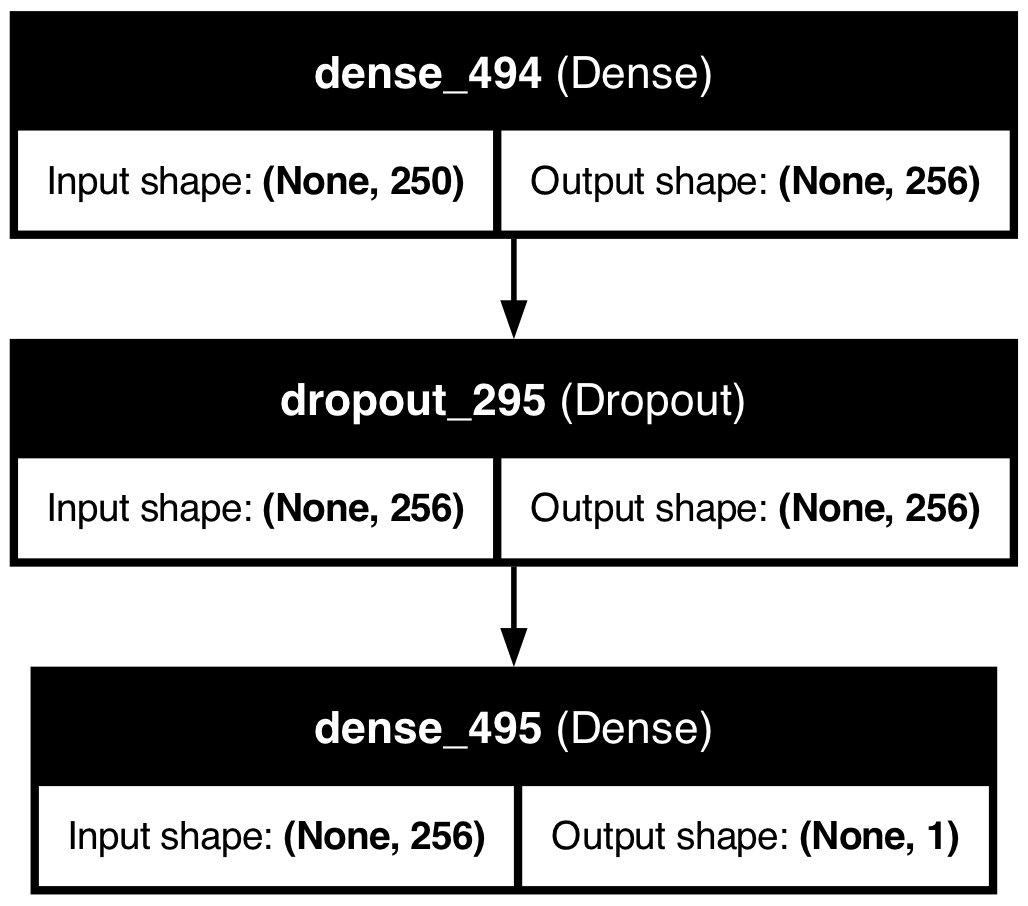

In [54]:
# Generate the plot
plot_model(model_1rWV, show_shapes=True, show_layer_names=True)

Epoch 1/300
238/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5895 - loss: 0.6710
Epoch 1: val_loss improved from inf to 0.64835, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5906 - loss: 0.6704 - val_accuracy: 0.6343 - val_loss: 0.6483 - learning_rate: 0.0010
Epoch 2/300
221/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6418 - loss: 0.6399
Epoch 2: val_loss did not improve from 0.64835
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6412 - loss: 0.6402 - val_accuracy: 0.6090 - val_loss: 0.6541 - learning_rate: 0.0010
Epoch 3/300
228/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6353 - loss: 0.6401
Epoch 3: val_loss improved from 0.64835 to 0.62641, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6359 - loss: 0.6395 - val_accuracy: 0.6545 - val_loss: 0.6264 - learning_rate: 0.0010
Epoch 4/300
222/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6367 - loss: 0.6325
Epoch 4: val_los

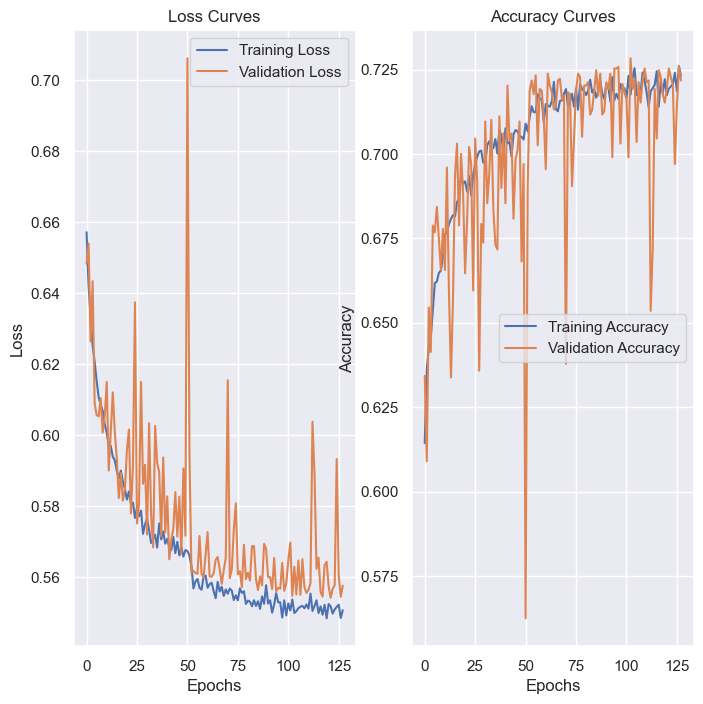

In [55]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1rWV_history = model_1rWV.fit(
    rX_train_vec, ry_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with model's history
plot_loss_curves(model_1rWV_history)

In [56]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_1rWV.predict(rX_test_vec)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1rWV_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m1rWV_accuracy = accuracy_score(ry_test, ry_pred)
m1rWV_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1rWV_recall = recall_score(ry_test, ry_pred, average='weighted')
m1rWV_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1rWV_accuracy:.2%}", f"{m1rWV_precision:.3f}", f"{m1rWV_recall:.3f}", f"{m1rWV_f1:.3f}", f"{m1rWV_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Performance          Results
         accuracy           72.37%
        precision            0.726
           recall            0.724
         f1_score            0.723
    time/instance 0.000192 seconds


In [57]:
store_results('Model_1rWV', m1rWV_accuracy, m1rWV_precision, m1rWV_recall, m1rWV_f1, m1rWV_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3  Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4  Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5  Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds


### LSTM (single layer)

My second model is a LSTM with a single layer

#### LSTM reshaping

In [58]:
# Initialize the tokenizer
tokenizer = Tokenizer()
# Fit the tokenizer on your training data
tokenizer.fit_on_texts(cX_train)
# Convert texts to sequences
cx_train_seq = tokenizer.texts_to_sequences(cX_train)
cx_test_seq = tokenizer.texts_to_sequences(cX_test)
# Get the word index
word_index = tokenizer.word_index
# Vocabulary size
vocab_sizeC = len(word_index) + 1
print("Vocab size:", vocab_sizeC)
# Determine the length of each sequence
sequence_lengths = [len(seq) for seq in cx_train_seq]
# Calculate the 95th percentile of sequence lengths
max_lengthC = int(np.percentile(sequence_lengths, 95))
print("Max length:", max_lengthC)
# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(cx_train_seq, maxlen=max_lengthC, padding='post')
padded_sequencesT = pad_sequences(cx_test_seq, maxlen=max_lengthC, padding='post')
# The training data is now padded_sequences
cX_train_pad = padded_sequences
cX_test_pad = padded_sequencesT
# Print padded sequences
print("Padded sequences:", cX_train_pad)
cX_train_lstm = cX_train_pad  # Preprocessed input data for the LSTM model
cX_test_lstm = cX_test_pad  # Preprocessed input data for the LSTM model

Vocab size: 6341
Max length: 20
Padded sequences: [[ 510  181 1620 ...    0    0    0]
 [   4    9    0 ...    0    0    0]
 [1990  179  146 ...    0    0    0]
 ...
 [ 117   60   48 ...    0    0    0]
 [  32    5    2 ...    0    0    0]
 [  53   49    0 ...    0    0    0]]


In [59]:
# Initialize the tokenizer
tokenizer = Tokenizer()
# Fit the tokenizer on your training data
tokenizer.fit_on_texts(rX_train)
# Convert texts to sequences
rx_train_seq = tokenizer.texts_to_sequences(rX_train)
rx_test_seq = tokenizer.texts_to_sequences(rX_test)
# Get the word index
word_index = tokenizer.word_index
# Vocabulary size
vocab_sizeR = len(word_index) + 1
print("Vocab size:", vocab_sizeR)  
# Determine the length of each sequence
sequence_lengths = [len(seq) for seq in rx_train_seq]
# Calculate the 95th percentile of sequence lengths
max_lengthR = int(np.percentile(sequence_lengths, 95))
print("Max length:", max_lengthR)
# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(rx_train_seq, maxlen=max_lengthR, padding='post')
padded_sequencesT = pad_sequences(rx_test_seq, maxlen=max_lengthR, padding='post')
# The training data is now padded_sequences
rX_train_pad = padded_sequences
rX_test_pad = padded_sequencesT
# Print padded sequences
print("Padded sequences:", rX_train_pad)
rX_train_lstm = rX_train_pad  # Preprocessed input data for the LSTM model
rX_test_lstm = rX_test_pad  # Preprocessed input data for the LSTM model


Vocab size: 6340
Max length: 35
Padded sequences: [[ 634  254   70 ...    0    0    0]
 [  12   23    0 ...    0    0    0]
 [2340  635  229 ...    0    0    0]
 ...
 [  25   24    2 ...    0    0    0]
 [  65   13    7 ...    0    0    0]
 [  98   95    0 ...    0    0    0]]


#### LSTM (single layer) with cleaned data

In [60]:
def create_model(input_length=max_lengthC, input_dim=vocab_sizeC, output_dim=128, lstm_units=128, dropout_rate=0.5, regularization=0.005, learning_rate=0.001):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = LSTM(units=lstm_units, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


def create_model_wrapper(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate):
    return create_model(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate)

# Wrap the model with KerasClassifier from scikeras
model = KerasClassifier(
    model=create_model_wrapper,
    input_length=max_lengthC,
    input_dim=vocab_sizeC,
    output_dim=64,
    lstm_units=128,
    dropout_rate=0.5,
    regularization=0.005,
    learning_rate=0.001,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Define the grid search parameters
param_grid = {
    'lstm_units': [256,512],  # Focused values for LSTM units
    'learning_rate': [0.001,0.0001],  # Narrow range for learning rate
    'output_dim': [128,256]  # Output dimensions of Embedding layer
}

# Fit the model directly without GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search
grid_result = grid.fit(cX_train_lstm, cy_train, callbacks=[early_stopping])

2024-05-21 05:30:37.986308: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 05:30:37.996905: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 05:30:37.997079: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 05:30:38.001146: I tensorflow/core/platform/cpu_featu

Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 186ms/step - accuracy: 0.6563 - loss: 1.0024
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 191ms/step - accuracy: 0.6755 - loss: 0.9888
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 191ms/step - accuracy: 0.6606 - loss: 0.9827
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 67s 299ms/step - accuracy: 0.6645 - loss: 1.2787
117/206 ━━━━━━━━━━━━━━━━━━━━ 17s 198ms/step - accuracy: 0.8256 - loss: 0.4080Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 67s 301ms/step - accuracy: 0.6493 - loss: 1.2845
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 67s 301ms/step - accuracy: 0.6452 - loss: 1.2855
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 189ms/step - accuracy: 0.8249 - loss: 0.4091
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.8281 - loss: 0.4117
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 192ms/step - accuracy: 0.8348 - loss: 0.4094
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 1

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 44/206 ━━━━━━━━━━━━━━━━━━━━ 33s 205ms/step - accuracy: 0.9031 - loss: 0.2470Epoch 1/10
 77/206 ━━━━━━━━━━━━━━━━━━━━ 1:05 506ms/step - accuracy: 0.8890 - loss: 0.3109Epoch 1/10
 52/206 ━━━━━━━━━━━━━━━━━━━━ 30s 196ms/step - accuracy: 0.9106 - loss: 0.2425Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 240ms/step - accuracy: 0.9005 - loss: 0.2732
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 194ms/step - accuracy: 0.9049 - loss: 0.2552
Epoch 9/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.9030 - loss: 0.2529
Epoch 9/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.8995 - loss: 0.2676
Epoch 9/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 97s 468ms/step - accuracy: 0.8694 - loss: 0.3309
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 98s 476ms/step - accuracy: 0.8795 - loss: 0.3168
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 250ms/step - accuracy: 0.9008 - loss: 0.2601
Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 250ms/step - accuracy: 0.9085 - loss: 0.2386
Epoch 10/10
206/206 ━━━━━━━━━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/stepracy: 0.8861 - loss: 0.247: 0.2937
 20/103 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/stepEpoch 1/10cy: 0.8849 - loss: 0.297
206/206 ━━━━━━━━━━━━━━━━━━━━ 117s 567ms/step - accuracy: 0.8848 - loss: 0.2977
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.6539 - loss: 1.264
 12/206 ━━━━━━━━━━━━━━━━━━━━ 1:22 423ms/step - accuracy: 0.8465 - loss: 0.3186

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 43/206 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - accuracy: 0.8560 - loss: 0.3790Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 186s 669ms/step - accuracy: 0.6586 - loss: 1.2325
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 187s 680ms/step - accuracy: 0.6173 - loss: 1.2676
Epoch 2/10
 65/206 ━━━━━━━━━━━━━━━━━━━━ 1:01 435ms/step - accuracy: 0.8508 - loss: 0.3848

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 13/206 ━━━━━━━━━━━━━━━━━━━━ 1:35 493ms/step - accuracy: 0.8201 - loss: 0.4125Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 98s 477ms/step - accuracy: 0.8337 - loss: 0.4023
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 84s 185ms/step - accuracy: 0.5329 - loss: 1.6299
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 98s 476ms/step - accuracy: 0.8917 - loss: 0.2771
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 501ms/step - accuracy: 0.8859 - loss: 0.2920
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 88s 190ms/step - accuracy: 0.5383 - loss: 1.6373
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 195ms/step - accuracy: 0.7778 - loss: 0.9112
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 135s 657ms/step - accuracy: 0.8223 - loss: 0.4209
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 194ms/step - accuracy: 0.7807 - loss: 0.9037
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 135s 658ms/step - accuracy: 0.8218 - loss: 0.4231
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - accuracy: 0.8165 - loss: 0.6465
Epoch 4/10
206/206 ━━━━━━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 126s 612ms/step - accuracy: 0.8951 - loss: 0.2830
Epoch 6/10
 37/103 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/stepEpoch 1/10racy: 0.8962 - loss: 0.289
206/206 ━━━━━━━━━━━━━━━━━━━━ 126s 613ms/step - accuracy: 0.9060 - loss: 0.2553
Epoch 10/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/stepep - accuracy: 0.9220 - loss: 0.255
 44/206 ━━━━━━━━━━━━━━━━━━━━ 1:37 602ms/step - accuracy: 0.9016 - loss: 0.2758

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 51/206 ━━━━━━━━━━━━━━━━━━━━ 1:34 613ms/step - accuracy: 0.8915 - loss: 0.2964Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 117s 565ms/step - accuracy: 0.9004 - loss: 0.2581
 44/206 ━━━━━━━━━━━━━━━━━━━━ 1:17 476ms/step - accuracy: 0.9092 - loss: 0.2394Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 147s 709ms/step - accuracy: 0.8583 - loss: 0.3518
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 86s 176ms/step - accuracy: 0.5490 - loss: 1.631069━━ 1:19 469ms/step - acc
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 108s 524ms/step - accuracy: 0.9047 - loss: 0.2671
109/206 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - accuracy: 0.7847 - loss: 0.9330Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 111s 538ms/step - accuracy: 0.9065 - loss: 0.2382
206/206 ━━━━━━━━━━━━━━━━━━━━ 134s 650ms/step - accuracy: 0.8845 - loss: 0.3062
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 182ms/step - accuracy: 0.7884 - loss: 0.8970
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 136s 658ms/step - accuracy: 0.8899 - loss: 0.2965
  5/206 ━━━━━━━━━━━━━━━━━━━━ 34s 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 96/206 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.8670 - loss: 0.4812Epoch 1/10
105/206 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.8662 - loss: 0.4822

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


129/206 ━━━━━━━━━━━━━━━━━━━━ 41s 542ms/step - accuracy: 0.9039 - loss: 0.2493Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 245ms/step - accuracy: 0.7924 - loss: 1.1922
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 32s 154ms/step - accuracy: 0.8602 - loss: 0.48799425ss: 0.48
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 109s 526ms/step - accuracy: 0.9021 - loss: 0.2570
148/206 ━━━━━━━━━━━━━━━━━━━━ 37s 648ms/step - accuracy: 0.8889 - loss: 0.2866Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 32s 154ms/step - accuracy: 0.8739 - loss: 0.4217
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 231ms/step - accuracy: 0.8320 - loss: 0.7590
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 137s 665ms/step - accuracy: 0.8888 - loss: 0.2859
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 135s 659ms/step - accuracy: 0.8905 - loss: 0.2944
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 185ms/step - accuracy: 0.8768 - loss: 0.3946
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 117s 305ms/step - accuracy: 0.5320 - loss: 2.3796
Epoch 2/10
206/206 ━━━━━━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


100/206 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - accuracy: 0.8766 - loss: 0.5599Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 124s 602ms/step - accuracy: 0.9123 - loss: 0.2417 loss: 0.391
Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 55s 265ms/step - accuracy: 0.8810 - loss: 0.3911
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 154s 749ms/step - accuracy: 0.8919 - loss: 0.2828
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 56s 270ms/step - accuracy: 0.8630 - loss: 0.5532
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 55s 264ms/step - accuracy: 0.8684 - loss: 0.5577
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 259ms/step - accuracy: 0.8969 - loss: 0.3584
Epoch 9/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 260ms/step - accuracy: 0.8618 - loss: 0.4854
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 264ms/step - accuracy: 0.8806 - loss: 0.4710
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 141s 683ms/step - accuracy: 0.8981 - loss: 0.2549- loss: 0.240
Epoch 9/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 143s 695ms/step - accuracy: 0.9023 - loss: 0.26595
Ep

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 84s 275ms/step - accuracy: 0.8863 - loss: 0.4242
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 144s 696ms/step - accuracy: 0.8974 - loss: 0.2675
Epoch 8/10
 71/206 ━━━━━━━━━━━━━━━━━━━━ 1:36 715ms/step - accuracy: 0.9075 - loss: 0.2500Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 251ms/step - accuracy: 0.9049 - loss: 0.3222
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 248ms/step - accuracy: 0.8950 - loss: 0.3786
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 188s 561ms/step - accuracy: 0.5796 - loss: 1.6125
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/stepp - accuracy: 0.9058 - loss: 0.253
134/206 ━━━━━━━━━━━━━━━━━━━━ 47s 662ms/step - accuracy: 0.9012 - loss: 0.2638

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 62/206 ━━━━━━━━━━━━━━━━━━━━ 1:23 582ms/step - accuracy: 0.9130 - loss: 0.2387Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 243ms/step - accuracy: 0.8900 - loss: 0.36808/step - accuracy: 0.8861 - loss: 0.406�━━━ 34s
Epoch 9/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 76s 244ms/step - accuracy: 0.8885 - loss: 0.3956
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 135s 656ms/step - accuracy: 0.9015 - loss: 0.2622
Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 138s 666ms/step - accuracy: 0.9023 - loss: 0.2588
Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 262ms/step - accuracy: 0.8996 - loss: 0.3461
Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 57s 278ms/step - accuracy: 0.8997 - loss: 0.3648
Epoch 9/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 134s 653ms/step - accuracy: 0.9068 - loss: 0.2516
Epoch 9/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 114s 556ms/step - accuracy: 0.7907 - loss: 0.8102
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 172s 579ms/step - accuracy: 0.5778 - loss: 1.6096
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 58s 281ms/step - accuracy:

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 49/206 ━━━━━━━━━━━━━━━━━━━━ 1:34 601ms/step - accuracy: 0.7901 - loss: 0.8599Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 147s 716ms/step - accuracy: 0.8962 - loss: 0.2601
206/206 ━━━━━━━━━━━━━━━━━━━━ 195s 600ms/step - accuracy: 0.5734 - loss: 1.6017
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 146s 708ms/step - accuracy: 0.9084 - loss: 0.2327
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 251ms/step - accuracy: 0.9071 - loss: 0.3301
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step- accuracy: 0.8196 - loss: 0.577
 76/103 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/stepp - accuracy: 0.7871 - loss: 0.827

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 118s 569ms/step - accuracy: 0.8198 - loss: 0.5764
Epoch 4/10
102/103 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/stepEpoch 1/10acy: 0.8090 - loss: 0.
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/stepp - accuracy: 0.7875 - loss: 0.8237
 52/206 ━━━━━━━━━━━━━━━━━━━━ 1:08 446ms/step - accuracy: 0.8090 - loss: 0.8462

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.7876 - loss: 0.827
162/206 ━━━━━━━━━━━━━━━━━━━━ 22s 519ms/step - accuracy: 0.7878 - loss: 0.8192Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 134s 647ms/step - accuracy: 0.9084 - loss: 0.2488
Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 102s 493ms/step - accuracy: 0.7886 - loss: 0.8033
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 92s 443ms/step - accuracy: 0.8057 - loss: 0.7928
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 96s 468ms/step - accuracy: 0.8461 - loss: 0.474618s: 
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 174s 596ms/step - accuracy: 0.5799 - loss: 2.43549ms/step - accuracy: 0.9101 - loss: 0.24
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 105s 510ms/step - accuracy: 0.8333 - loss: 0.5506
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 129s 627ms/step - accuracy: 0.9095 - loss: 0.2444
103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 196ms/step - accuracy: 0.8632 - loss: 0.414195━━━━━━━━━━━━━━━━━━ 17s 660ms/step - accuracy: 0.5511 - loss: 2.
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.5791 - loss: 1.5259
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.7967 - loss: 0.7392
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8322 - loss: 0.5254
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.8482 - loss: 0.4485
Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8567 - loss: 0.4091
Epoch 6/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8733 - loss: 0.3686
Epoch 7/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8752 - loss: 0.3497
Epoch 8/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8766 - loss: 0.3370
Epoch 9/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8892 - loss: 0.3166
Epoch 10/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8873 - loss: 0.3061


In [61]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.759004 using {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 128}
0.755260 (0.008475) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 128}
0.752225 (0.005485) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 256}
0.750505 (0.005703) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 128}
0.757081 (0.005604) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 256}
0.759004 (0.004757) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 128}
0.752934 (0.004326) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 256}
0.752124 (0.003178) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 128}
0.754248 (0.010684) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 256}


In [62]:
# Extract the best parameters
best_params = grid_result.best_params_

In [63]:
# Create the final model using the best parameters
model_2cIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    output_dim=best_params['output_dim']
)

# Model Summary
print(model_2cIT.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_795"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_201 (InputLayer)    │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 20, 128)        │       811,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_297 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_497 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,145 (4.60 MB)

 Trainable params: 1,206,145 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

None


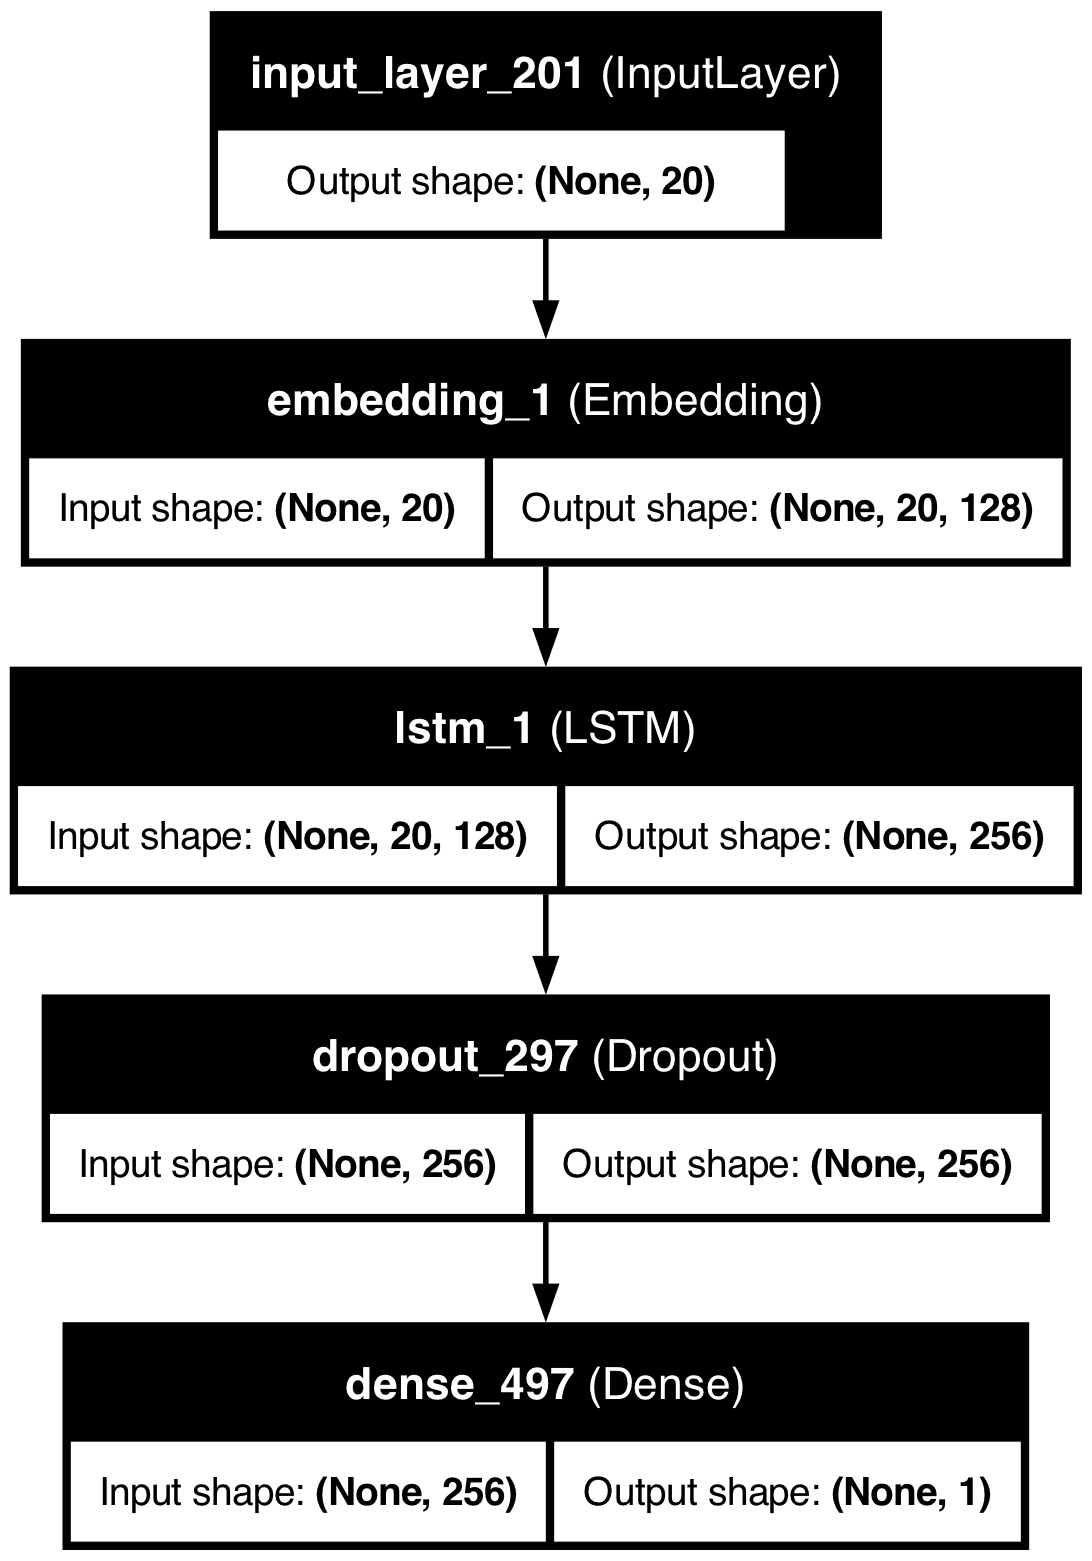

In [64]:
# Generate the plot
plot_model(model_2cIT, show_shapes=True, show_layer_names=True)

In [65]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_2cIT_history = model_2cIT.fit(
    cX_train_lstm, cy_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5507 - loss: 1.5822
Epoch 1: val_loss improved from inf to 0.93660, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.5511 - loss: 1.5812 - val_accuracy: 0.7613 - val_loss: 0.9366 - learning_rate: 1.0000e-04
Epoch 2/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7919 - loss: 0.8139
Epoch 2: val_loss improved from 0.93660 to 0.68859, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7919 - loss: 0.8136 - val_accuracy: 0.7769 - val_loss: 0.6886 - learning_rate: 1.0000e-04
Epoch 3/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8316 - loss: 0.5679
Epoch 3: val_loss improved from 0.68859 to 0.59893, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8316 - loss: 0.5678 - val_accuracy: 0.7795 - val_loss: 0.5989 - learning_rate: 1.0000e-04
Epoch 4/15
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms

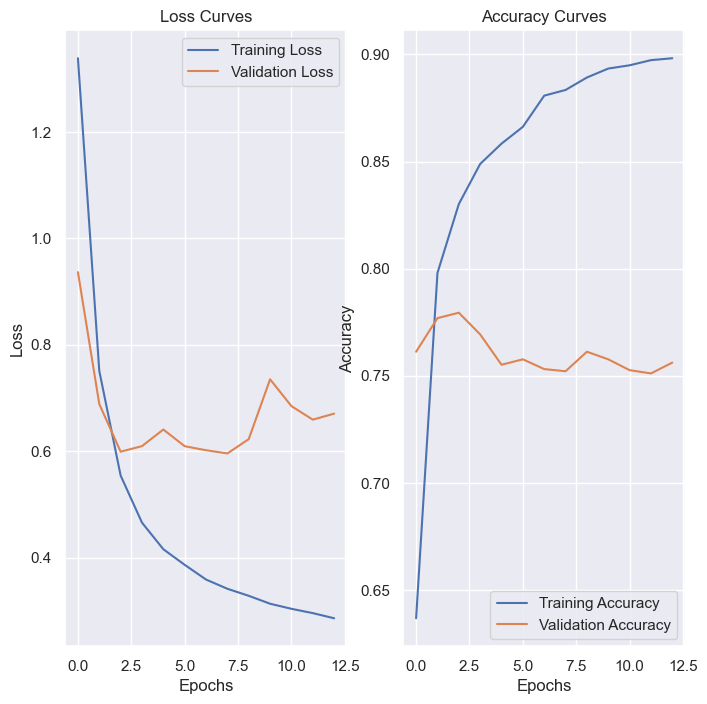

In [66]:
# Use the function with your model's history
plot_loss_curves(model_2cIT_history) 

In [67]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_2cIT.predict(cX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2cIT_time_per_instance = (end_time - start_time) / len(cX_test_lstm)

# Calculate accuracy, precision, recall, and f1 score
m2cIT_accuracy = accuracy_score(cy_test, cy_pred)
m2cIT_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m2cIT_recall = recall_score(cy_test, cy_pred, average='weighted')
m2cIT_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2cIT_accuracy:.2%}", f"{m2cIT_precision:.3f}", f"{m2cIT_recall:.3f}", f"{m2cIT_f1:.3f}", f"{m2cIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Model Performance          Results
         accuracy           75.93%
        precision            0.760
           recall            0.759
         f1_score            0.759
    time/instance 0.000928 seconds


In [68]:
store_results('Model_2c', m2cIT_accuracy, m2cIT_precision, m2cIT_recall, m2cIT_f1, m2cIT_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3  Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4  Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5  Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds
6    Model_2c   75.93%     0.760  0.759    0.759  0.000928 seconds


#### LSTM (single layer) with raw data

In [69]:
def create_model(input_length=max_lengthR, input_dim=vocab_sizeR, output_dim=128, lstm_units=128, dropout_rate=0.5, regularization=0.005, learning_rate=0.005):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = LSTM(units=lstm_units, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


def create_model_wrapper(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate):
    return create_model(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate)

# Wrap the model with KerasClassifier from scikeras
model = KerasClassifier(
    model=create_model_wrapper,
    input_length=max_lengthR,
    input_dim=vocab_sizeR,
    output_dim=64,
    lstm_units=128,
    dropout_rate=0.5,
    regularization=0.005,
    learning_rate=0.001,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Fit the model directly without GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search
#grid_result = grid.fit(rX_train_lstm, ry_train, callbacks=[early_stopping])

In [70]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.759004 using {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 128}
0.755260 (0.008475) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 128}
0.752225 (0.005485) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 256}
0.750505 (0.005703) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 128}
0.757081 (0.005604) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 256}
0.759004 (0.004757) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 128}
0.752934 (0.004326) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 256}
0.752124 (0.003178) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 128}
0.754248 (0.010684) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 256}


In [71]:
# Extract the best parameters
best_params = grid_result.best_params_

In [72]:
# Create the final model using the best parameters
model_2rIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    output_dim=best_params['output_dim']
)

# Model Summary
print(model_2rIT.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_797"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_202 (InputLayer)    │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 35, 128)        │       811,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_298 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_498 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,017 (4.60 MB)

 Trainable params: 1,206,017 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

None


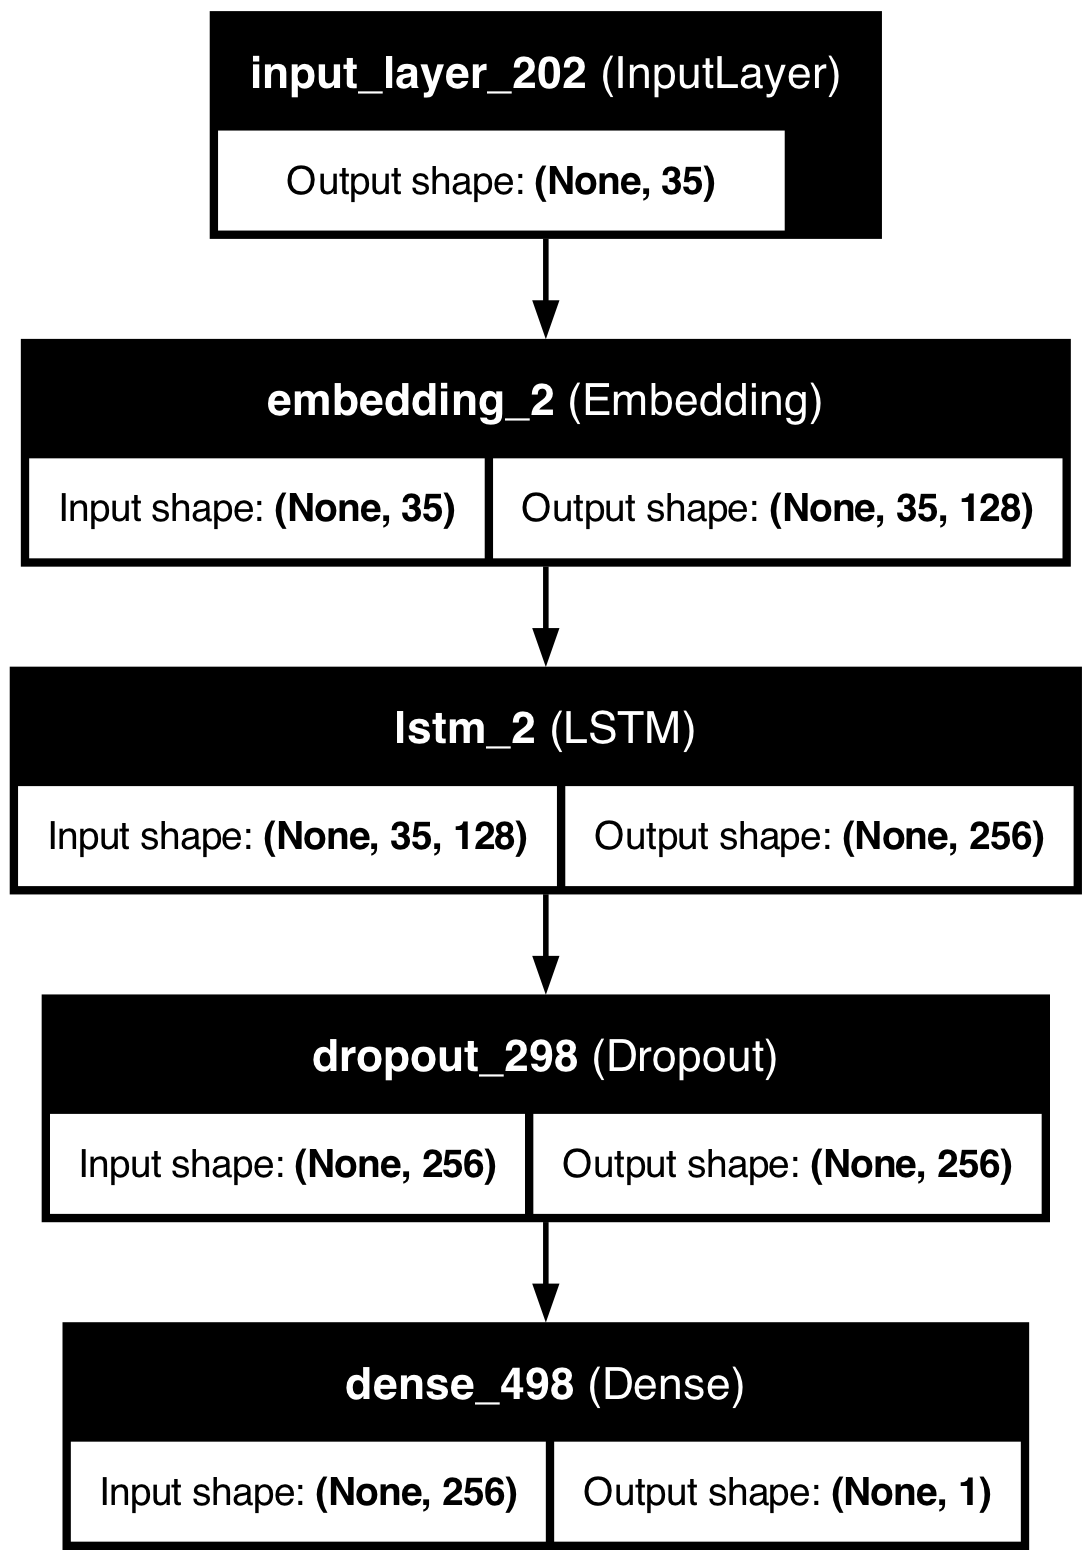

In [73]:
# Generate the plot
plot_model(model_2rIT, show_shapes=True, show_layer_names=True)

Epoch 1/15
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5286 - loss: 1.6047
Epoch 1: val_loss improved from inf to 0.95567, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.5291 - loss: 1.6029 - val_accuracy: 0.7562 - val_loss: 0.9557 - learning_rate: 1.0000e-04
Epoch 2/15
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7838 - loss: 0.8422
Epoch 2: val_loss improved from 0.95567 to 0.69722, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.7838 - loss: 0.8416 - val_accuracy: 0.7628 - val_loss: 0.6972 - learning_rate: 1.0000e-04
Epoch 3/15
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8333 - loss: 0.5715
Epoch 3: val_loss improved from 0.69722 to 0.59553, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.8333 - loss: 0.5713 - val_accuracy: 0.7749 - val_loss: 0.5955 - learning_rate: 1.0000e-04
Epoch 4/15
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms

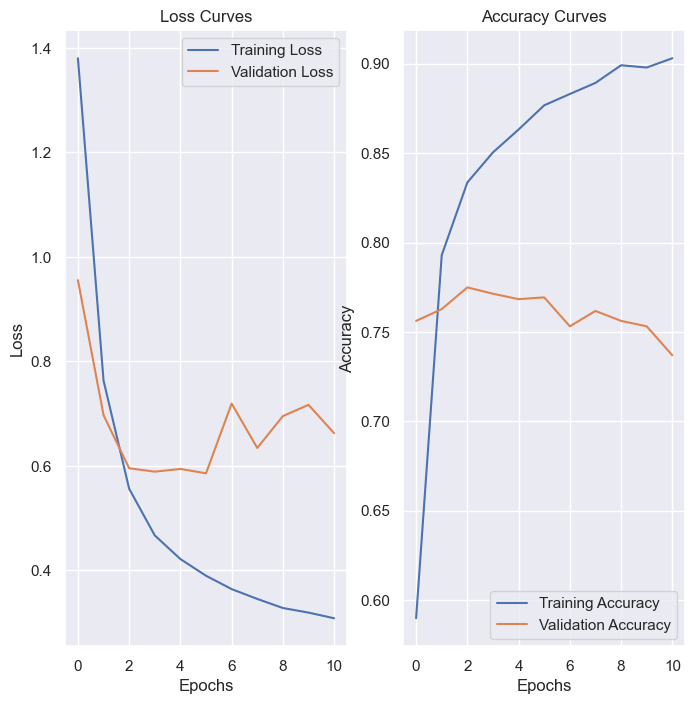

In [74]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_2rIT_history = model_2rIT.fit(
    rX_train_lstm, ry_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with the model's history
plot_loss_curves(model_2rIT_history)

In [75]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_2rIT.predict(rX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob> 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2rIT_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m2rIT_accuracy = accuracy_score(ry_test, ry_pred)
m2rIT_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m2rIT_recall = recall_score(ry_test, ry_pred, average='weighted')
m2rIT_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2rIT_accuracy:.2%}", f"{m2rIT_precision:.3f}", f"{m2rIT_recall:.3f}", f"{m2rIT_f1:.3f}", f"{m2rIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Model Performance          Results
         accuracy           76.74%
        precision            0.770
           recall            0.767
         f1_score            0.767
    time/instance 0.001405 seconds


In [76]:
store_results('Model_2r', m2rIT_accuracy, m2rIT_precision, m2rIT_recall, m2rIT_f1, m2rIT_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3  Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4  Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5  Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds
6    Model_2c   75.93%     0.760  0.759    0.759  0.000928 seconds
7    Model_2r   76.74%     0.770  0.767    0.767  0.001405 seconds


### LSTM (stacked)

Now I use another LSTM (LSTM stacked)

#### LSTM (stacked) with cleaned data

In [77]:
def create_model(input_length=max_lengthC, input_dim=vocab_sizeC, output_dim=128, lstm_units=128, dropout_rate=0.5, regularization=0.005, learning_rate=0.001):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(units=lstm_units, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model_wrapper(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate):
    return create_model(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate)

# Wrap the model with KerasClassifier from scikeras
model = KerasClassifier(
    model=create_model_wrapper,
    input_length=max_lengthC,
    input_dim=vocab_sizeC,
    output_dim=64,
    lstm_units=128,
    dropout_rate=0.5,
    regularization=0.005,
    learning_rate=0.001,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Fit the model directly without GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search
#grid_result = grid.fit(cX_train_lstm, cy_train, callbacks=[early_stopping])

In [78]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.759004 using {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 128}
0.755260 (0.008475) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 128}
0.752225 (0.005485) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 256}
0.750505 (0.005703) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 128}
0.757081 (0.005604) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 256}
0.759004 (0.004757) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 128}
0.752934 (0.004326) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 256}
0.752124 (0.003178) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 128}
0.754248 (0.010684) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 256}


In [79]:
# Extract the best parameters
best_params = grid_result.best_params_

In [80]:
# Create the final model using the best parameters
model_3cIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    output_dim=best_params['output_dim']
)

# Model Summary
print(model_3cIT.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_799"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_203 (InputLayer)    │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 20, 128)        │       811,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_299 (Dropout)           │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_300 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_499 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,457 (6.60 MB)

 Trainable params: 1,731,457 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

None


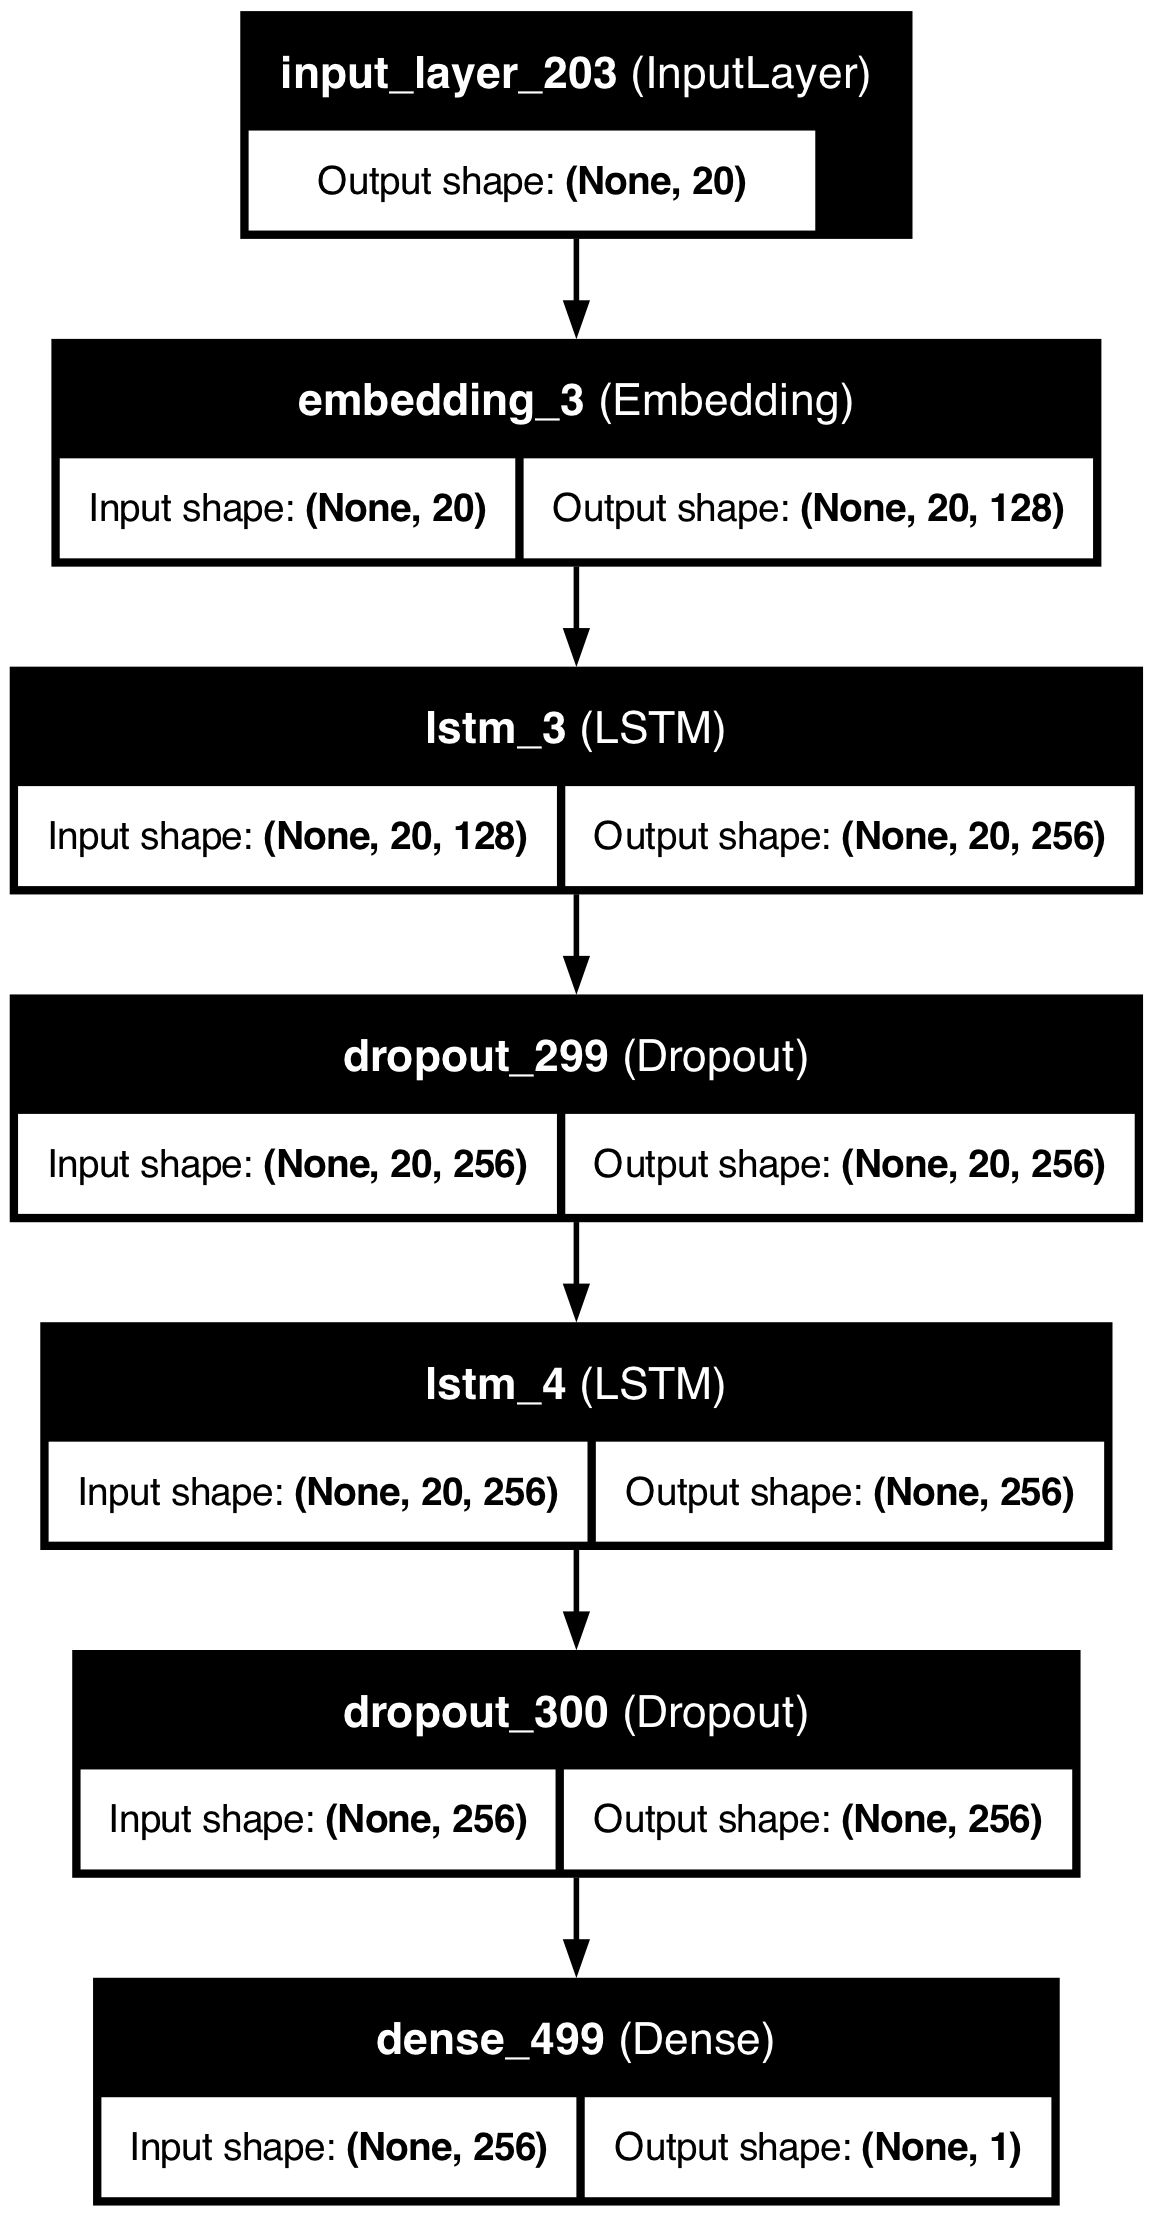

In [81]:
# Generate the plot
plot_model(model_3cIT, show_shapes=True, show_layer_names=True)

Epoch 1/15
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5638 - loss: 3.2047
Epoch 1: val_loss improved from inf to 1.63920, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.5645 - loss: 3.1998 - val_accuracy: 0.7683 - val_loss: 1.6392 - learning_rate: 1.0000e-04
Epoch 2/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7997 - loss: 1.3706
Epoch 2: val_loss improved from 1.63920 to 0.91525, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.7997 - loss: 1.3698 - val_accuracy: 0.7769 - val_loss: 0.9152 - learning_rate: 1.0000e-04
Epoch 3/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8243 - loss: 0.7516
Epoch 3: val_loss improved from 0.91525 to 0.68570, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.8243 - loss: 0.7513 - val_accuracy: 0.7704 - val_loss: 0.6857 - learning_rate: 1.0000e-04
Epoch 4/15
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms

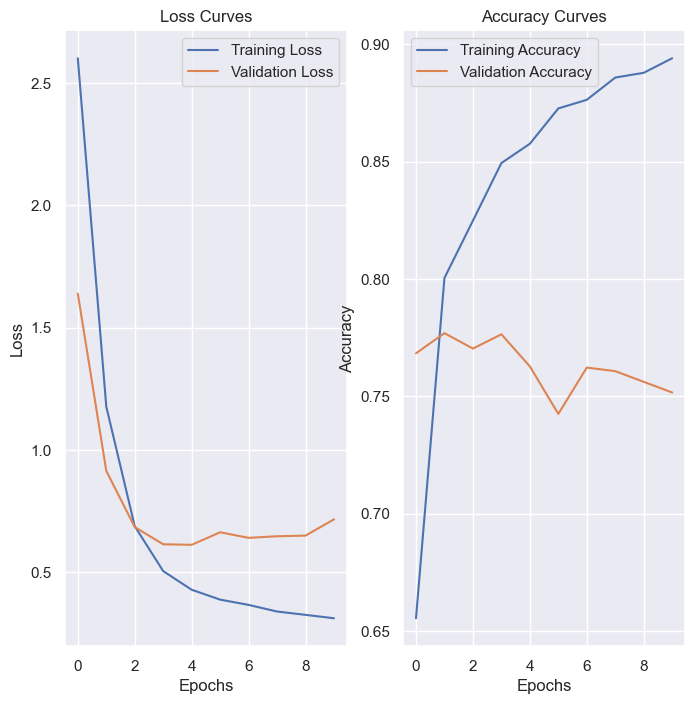

In [82]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_3cIT_history = model_3cIT.fit(
    cX_train_lstm, cy_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with the model's history
plot_loss_curves(model_3cIT_history)

In [83]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_3cIT.predict(cX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m3cIT_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m3cIT_accuracy = accuracy_score(cy_test, cy_pred)
m3cIT_precision = precision_score(cy_test, cy_pred, average='weighted')
m3cIT_recall = recall_score(cy_test, cy_pred, average='weighted')
m3cIT_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m3cIT_accuracy:.2%}", f"{m3cIT_precision:.3f}", f"{m3cIT_recall:.3f}", f"{m3cIT_f1:.3f}", f"{m3cIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step
Model Performance          Results
         accuracy           77.99%
        precision            0.785
           recall            0.780
         f1_score            0.779
    time/instance 0.001692 seconds


In [84]:
store_results('Model_3c', m3cIT_accuracy, m3cIT_precision, m3cIT_recall, m3cIT_f1, m3cIT_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3  Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4  Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5  Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds
6    Model_2c   75.93%     0.760  0.759    0.759  0.000928 seconds
7    Model_2r   76.74%     0.770  0.767    0.767  0.001405 seconds
8    Model_3c   77.99%     0.785  0.780    0.779  0.001692 seconds


#### LSTM (stacked) with raw data

In [85]:
def create_model(input_length=max_lengthR, input_dim=vocab_sizeR, output_dim=128, lstm_units=128, dropout_rate=0.5, regularization=0.005, learning_rate=0.001):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(units=lstm_units, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model_wrapper(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate):
    return create_model(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate)

# Wrap the model with KerasClassifier from scikeras
model = KerasClassifier(
    model=create_model_wrapper,
    input_length=max_lengthR,
    input_dim=vocab_sizeR,
    output_dim=64,
    lstm_units=128,
    dropout_rate=0.5,
    regularization=0.005,
    learning_rate=0.001,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Fit the model directly without GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search
grid_result = grid.fit(rX_train_lstm, ry_train, callbacks=[early_stopping])

2024-05-21 06:31:41.609088: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 06:31:41.623199: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 06:31:41.633254: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 06:31:41.649604: I tensorflow/core/platform/cpu_featu

Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 150s 690ms/step - accuracy: 0.6004 - loss: 1.7268
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 151s 688ms/step - accuracy: 0.6005 - loss: 1.7375
206/206 ━━━━━━━━━━━━━━━━━━━━ 151s 693ms/step - accuracy: 0.6261 - loss: 1.6990
Epoch 2/10
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 179s 830ms/step - accuracy: 0.5408 - loss: 2.02721ms/step - accuracy: 0.8559 - loss: 0.405━━━━ 2:16 744ms/step - accuracy: 0.8549 - loss: 0.407
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 180s 834ms/step - accuracy: 0.5820 - loss: 2.0135
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 180s 835ms/step - accuracy: 0.6201 - loss: 1.9819
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 143s 695ms/step - accuracy: 0.8231 - loss: 0.4274
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 144s 699ms/step - accuracy: 0.8162 - loss: 0.4494
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 147s 709ms/step - accuracy: 0.8234 - loss: 0.4253
Epoch 3/10
206/206 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 21/103 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/stepEpoch 1/10y: 0.9063 - loss: 0.252
 61/103 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/sttep - accuracy: 0.9065 - loss: 0.255

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 154s 747ms/step - accuracy: 0.8897 - loss: 0.3108/step - accuracy: 0.8889 - loss: 0.31�� 0s 160ms/ste
Epoch 10/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 38s 316ms/step - accuracy: 0.9072 - loss: 0.2511
103/103 ━━━━━━━━━━━━━━━━━━━━ 40s 329ms/stepacy: 0.9161 - loss: 0.26
206/206 ━━━━━━━━━━━━━━━━━━━━ 152s 739ms/step - accuracy: 0.7401 - loss: 0.5775
Epoch 10/10
 18/206 ━━━━━━━━━━━━━━━━━━━━ 1:49 584ms/step - accuracy: 0.7471 - loss: 0.5409Epoch 1/10
 29/206 ━━━━━━━━━━━━━━━━━━━━ 1:38 558ms/step - accuracy: 0.9170 - loss: 0.2659Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 177s 716ms/step - accuracy: 0.9074 - loss: 0.2509
 37/206 ━━━━━━━━━━━━━━━━━━━━ 1:34 559ms/step - accuracy: 0.9154 - loss: 0.2683Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.8482 - loss: 0.39585
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 483s 2s/step - accuracy: 0.4830 - loss: 0.6940
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 118s 571ms/step - accuracy: 0.9060 - loss: 0.2792
206/206 ━━━━━━━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 36/206 ━━━━━━━━━━━━━━━━━━━━ 7:26 3s/step - accuracy: 0.4671 - loss: 5.07496

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


147/206 ━━━━━━━━━━━━━━━━━━━━ 43s 736ms/step - accuracy: 0.9189 - loss: 0.2268Epoch 1/10
148/206 ━━━━━━━━━━━━━━━━━━━━ 42s 736ms/step - accuracy: 0.9189 - loss: 0.2269Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 201s 710ms/step - accuracy: 0.9173 - loss: 0.2310
103/103 ━━━━━━━━━━━━━━━━━━━━ 36s 287ms/step accuracy: 0.4831 - loss: 0.699
  3/206 ━━━━━━━━━━━━━━━━━━━━ 8:31 3s/step - accuracy: 0.6007 - loss: 6.8788loss: 3.841

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 93/206 ━━━━━━━━━━━━━━━━━━━━ 4:07 2s/step - accuracy: 0.8684 - loss: 0.349725Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 201s 596ms/step - accuracy: 0.5450 - loss: 3.3115
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 239s 681ms/step - accuracy: 0.5459 - loss: 3.3090━━━━━━━━━━━━━━━━ 2:07 3s/step - accuracy: 0.4874 - loss: 2.727� 46s 690ms/step - accuracy: 0.7825 - loss: 1.680 - loss: 0.34
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 542s 2s/step - accuracy: 0.5230 - loss: 2.0986625
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 143s 692ms/step - accuracy: 0.7854 - loss: 1.6076
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 0.8670 - loss: 0.349461
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.4912 - loss: 0.69358983━━━━━━━━━━━━━━━━━━━━ 4:16 3s/step - accuracy: 0.5265
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 601s 3s/step - accuracy: 0.4905 - loss: 2.36954
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 602s 3s/step - accuracy: 0.5054 - loss: 2.4529
Epoch 2/10
206/206 ━━━━━━━━━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 32s 246ms/stepp - accuracy: 0.9227 - loss: 0.29
172/206 ━━━━━━━━━━━━━━━━━━━━ 1:34 3s/step - accuracy: 0.5026 - loss: 0.693800Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 127s 619ms/step - accuracy: 0.9132 - loss: 0.3167
206/206 ━━━━━━━━━━━━━━━━━━━━ 563s 3s/step - accuracy: 0.4953 - loss: 0.6934
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 566s 3s/step - accuracy: 0.5037 - loss: 0.6938
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 181ms/step accuracy: 0.8060 - loss: 0.484
 85/206 ━━━━━━━━━━━━━━━━━━━━ 4:44 2s/step - accuracy: 0.4991 - loss: 0.7006

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  6/206 ━━━━━━━━━━━━━━━━━━━━ 1:41 507ms/step - accuracy: 0.4178 - loss: 3.8650Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 228s 585ms/step - accuracy: 0.5406 - loss: 3.3121
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - accuracy: 0.7981 - loss: 0.504094
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 139s 671ms/step - accuracy: 0.7951 - loss: 1.5785
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 278s 801ms/step - accuracy: 0.5432 - loss: 4.0586
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.5023 - loss: 0.69990
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step - accuracy: 0.8984 - loss: 0.284988
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 495s 2s/step - accuracy: 0.5012 - loss: 0.69377
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 138s 668ms/step - accuracy: 0.8295 - loss: 0.9291
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 164s 794ms/step - accuracy: 0.7834 - loss: 1.9123
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.5046 - loss: 0.693966�━━━━━━━━━━━━━━━━ 1:47 805ms/s

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 17/206 ━━━━━━━━━━━━━━━━━━━━ 7:51 2s/step - accuracy: 0.4771 - loss: 0.7017Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 524s 3s/step - accuracy: 0.4932 - loss: 0.693496
Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 157s 761ms/step - accuracy: 0.9001 - loss: 0.3976
Epoch 9/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 255s 801ms/step - accuracy: 0.5345 - loss: 4.0758━━━━━━━━━━━━━━━ 27s 814ms/step - accuracy: 0.9124 - loss: 0.355 accuracy: 0.4955 - loss: 0.699
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 554s 3s/step - accuracy: 0.4980 - loss: 0.6940
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 213s 813ms/step - accuracy: 0.9104 - loss: 0.3579 ━━━━━━━━━━━━━━━━━━━━ 2:33 806ms/step - accuracy: 0.7485 - los
Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.4847 - loss: 0.693745
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 166s 805ms/step - accuracy: 0.7834 - loss: 1.8945
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 165s 800ms/step - accuracy: 0.9116 - loss: 0.3466
197/206 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy:

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.5017 - loss: 0.698329
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step accuracy: 0.4917 - loss: 0.699128
200/206 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9224 - loss: 0.2382Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.4976 - loss: 0.74281
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.9222 - loss: 0.238718
206/206 ━━━━━━━━━━━━━━━━━━━━ 507s 2s/step - accuracy: 0.4957 - loss: 0.69370
206/206 ━━━━━━━━━━━━━━━━━━━━ 150s 727ms/step - accuracy: 0.8254 - loss: 1.0640
Epoch 4/10
 20/206 ━━━━━━━━━━━━━━━━━━━━ 2:22 765ms/step - accuracy: 0.8432 - loss: 0.7662

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 97s 869ms/stepp - accuracy: 0.8432 - loss: 0.759
 54/206 ━━━━━━━━━━━━━━━━━━━━ 1:53 748ms/step - accuracy: 0.8459 - loss: 0.7475Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 97s 868ms/stepp - accuracy: 0.8463 - loss: 0.74
140/206 ━━━━━━━━━━━━━━━━━━━━ 2:53 3s/step - accuracy: 0.4966 - loss: 0.693925

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 84/206 ━━━━━━━━━━━━━━━━━━━━ 1:25 703ms/step - accuracy: 0.8481 - loss: 0.7365Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 229s 664ms/step - accuracy: 0.5543 - loss: 4.0628
 91/206 ━━━━━━━━━━━━━━━━━━━━ 4:29 2s/step - accuracy: 0.5180 - loss: 0.6976Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 137s 665ms/step - accuracy: 0.8503 - loss: 0.7066
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 531s 3s/step - accuracy: 0.4965 - loss: 0.693929
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 533s 3s/step - accuracy: 0.5070 - loss: 0.6936
197/206 ━━━━━━━━━━━━━━━━━━━�� 7s 794ms/step - accuracy: 0.8759 - loss: 0.5463Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 164s 794ms/step - accuracy: 0.8757 - loss: 0.5457
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 165s 798ms/step - accuracy: 0.8078 - loss: 1.8956
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 493s 2s/step - accuracy: 0.5174 - loss: 0.697271
Epoch 9/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 539s 3s/step - accuracy: 0.5099 - loss: 0.69844
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 167s 809ms/step -

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


102/206 ━━━━━━━━━━━━━━━━━━━━ 4:28 3s/step - accuracy: 0.4992 - loss: 0.6970Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 523s 3s/step - accuracy: 0.7896 - loss: 1.692873
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.8015 - loss: 1.6380
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 152s 737ms/step - accuracy: 0.9077 - loss: 0.3855━━
Epoch 9/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 559s 3s/step - accuracy: 0.5136 - loss: 0.693369
Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.5001 - loss: 0.6932
Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - accuracy: 0.5011 - loss: 0.6964
206/206 ━━━━━━━━━━━━━━━━━━━━ 164s 794ms/step - accuracy: 0.9061 - loss: 0.3681
Epoch 10/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 83s 731ms/step accuracy: 0.8231 - loss: 0.85583
 98/206 ━━━━━━━━━━━━━━━━━━━━ 1:23 775ms/step - accuracy: 0.9233 - loss: 0.3338

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


117/206 ━━━━━━━━━━━━━━━━━━━━ 3:43 3s/step - accuracy: 0.8240 - loss: 0.8103Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 155s 749ms/step - accuracy: 0.9183 - loss: 0.3401
206/206 ━━━━━━━━━━━━━━━━━━━━ 547s 3s/step - accuracy: 0.7398 - loss: 0.7547
Epoch 10/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 31s 227ms/step accuracy: 0.5021 - loss: 0.69
163/206 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.8247 - loss: 0.7903

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


112/206 ━━━━━━━━━━━━━━━━━━━━ 4:06 3s/step - accuracy: 0.4917 - loss: 0.6950Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.8224 - loss: 0.8277
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.8257 - loss: 0.7728
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.5711 - loss: 4.7598
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 547s 3s/step - accuracy: 0.4930 - loss: 0.6945
206/206 ━━━━━━━━━━━━━━━━━━━━ 538s 3s/step - accuracy: 0.4993 - loss: 0.6939
103/103 ━━━━━━━━━━━━━━━━━━━━ 89s 779ms/step accuracy: 0.8015 - loss: 1.877
 24/103 ━━━━━━━━━━━━━━━━━━━━ 50s 644ms/step accuracy: 0.5017 - loss: 6.462

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


132/206 ━━━━━━━━━━━━━━━━━━━━ 3:18 3s/step - accuracy: 0.5522 - loss: 6.0749Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 80s 692ms/step accuracy: 0.8490 - loss: 0.568
206/206 ━━━━━━━━━━━━━━━━━━━━ 526s 3s/step - accuracy: 0.7765 - loss: 0.6609
206/206 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 0.8484 - loss: 0.5593
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 641s 3s/step - accuracy: 0.5858 - loss: 5.5893
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 69s 605ms/step accuracy: 0.8014 - loss: 1.70
206/206 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - accuracy: 0.8530 - loss: 0.5227
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 463s 2s/step - accuracy: 0.8012 - loss: 1.6608
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 631s 2s/step - accuracy: 0.5669 - loss: 5.5861
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - accuracy: 0.5640 - loss: 5.5921
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.8704 - loss: 0.4559
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.8766 - loss: 0.4269
Epoc

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 159s 473ms/step - accuracy: 0.6049 - loss: 5.0326
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 141s 458ms/step - accuracy: 0.8005 - loss: 1.2209
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 137s 442ms/step - accuracy: 0.8337 - loss: 0.6295
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 139s 451ms/step - accuracy: 0.8535 - loss: 0.5003
Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 138s 448ms/step - accuracy: 0.8627 - loss: 0.4401
Epoch 6/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 140s 454ms/step - accuracy: 0.8788 - loss: 0.3888
Epoch 7/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 143s 462ms/step - accuracy: 0.8823 - loss: 0.3656
Epoch 8/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 140s 453ms/step - accuracy: 0.8958 - loss: 0.3398
Epoch 9/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 141s 456ms/step - accuracy: 0.8980 - loss: 0.3265
Epoch 10/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 142s 458ms/step - accuracy: 0.9000 - loss: 0.3063


In [86]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.769323 using {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 256}
0.760623 (0.009434) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 128}
0.735636 (0.021418) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 256}
0.592868 (0.131442) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 128}
0.583991 (0.118781) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 256}
0.762444 (0.010933) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 128}
0.766793 (0.016248) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 256}
0.765478 (0.011728) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 128}
0.769323 (0.010629) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 256}


In [87]:
# Extract the best parameters
best_params = grid_result.best_params_

In [89]:
# Create the final model using the best parameters
model_3rIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    output_dim=best_params['output_dim']
)

# Model Summary
print(model_3rIT.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_803"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_205 (InputLayer)    │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 35, 256)        │     1,623,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 35, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_303 (Dropout)           │ (None, 35, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_304 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_501 (Dense)               │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,297,665 (20.21 MB)

 Trainable params: 5,297,665 (20.21 MB)

 Non-trainable params: 0 (0.00 B)

None


python(51790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51791) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


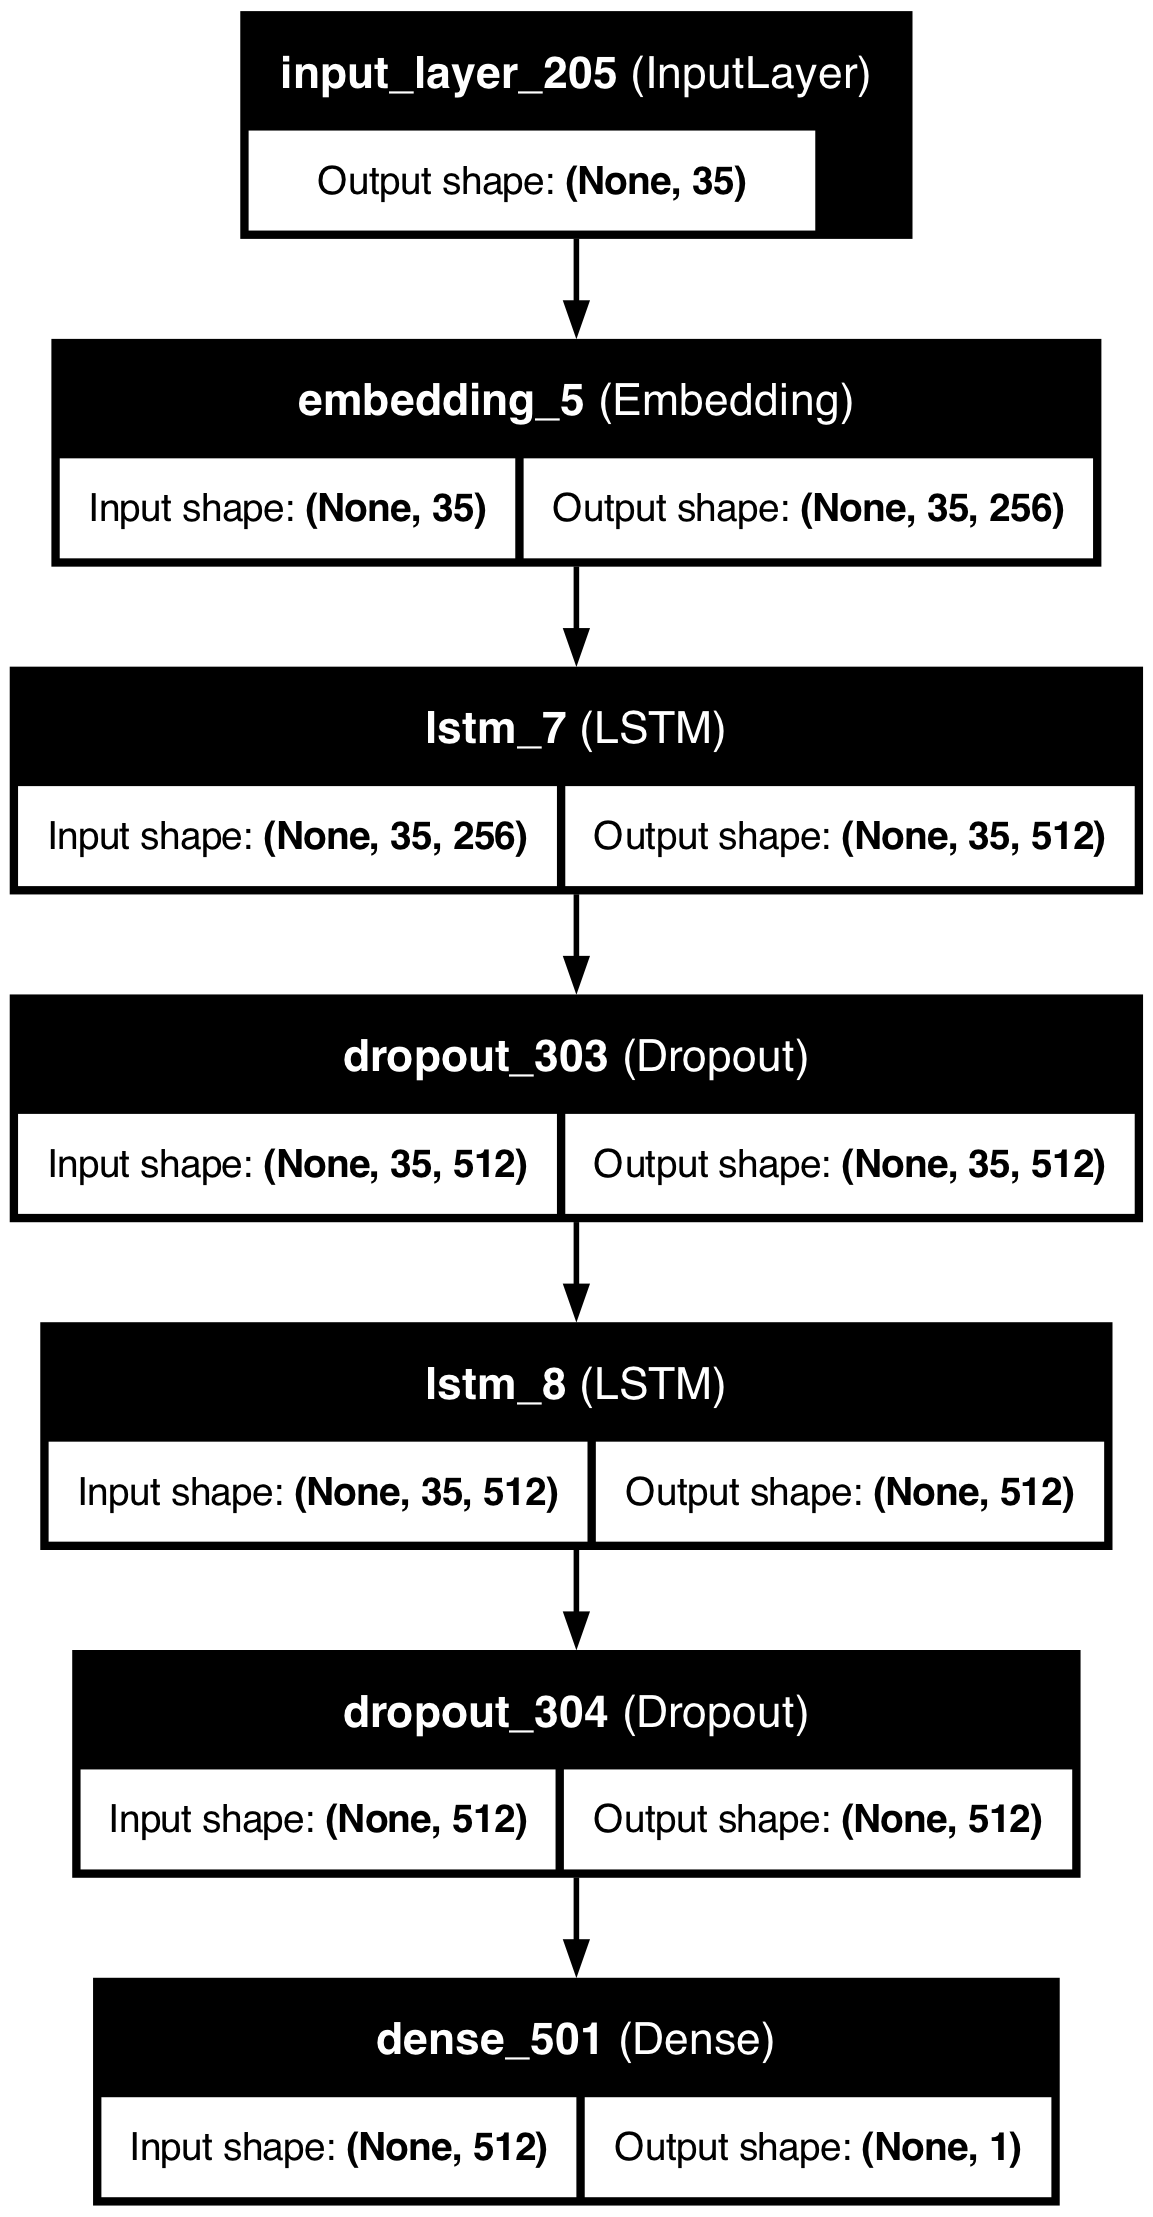

In [90]:
# Generate the plot
plot_model(model_3rIT, show_shapes=True, show_layer_names=True)

Epoch 1/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.5827 - loss: 5.3500
Epoch 1: val_loss improved from inf to 2.00088, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 136s 488ms/step - accuracy: 0.5830 - loss: 5.3445 - val_accuracy: 0.7699 - val_loss: 2.0009 - learning_rate: 1.0000e-04
Epoch 2/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8152 - loss: 1.5658
Epoch 2: val_loss improved from 2.00088 to 1.07728, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 118s 477ms/step - accuracy: 0.8152 - loss: 1.5647 - val_accuracy: 0.6626 - val_loss: 1.0773 - learning_rate: 1.0000e-04
Epoch 3/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.8223 - loss: 0.7648
Epoch 3: val_loss improved from 1.07728 to 0.73358, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 118s 474ms/step - accuracy: 0.8223 - loss: 0.7645 - val_accuracy: 0.7769 - val_loss: 0.7336 - learning_rate: 1.0000e-04
Epoch 4/15
248/248 ━━━━━━━━━━━━━━━━━━━

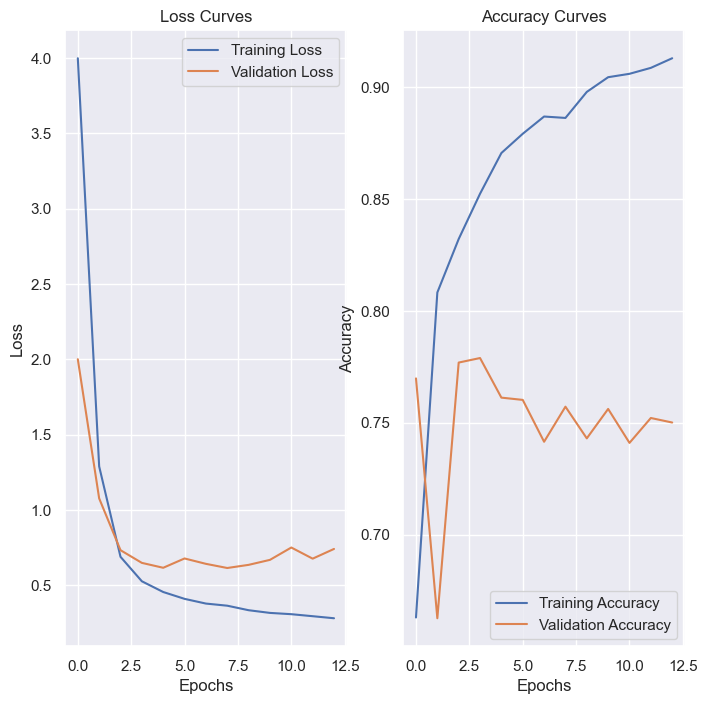

In [91]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_3rIT_history = model_3rIT.fit(
    rX_train_lstm, ry_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with the model's history
plot_loss_curves(model_3rIT_history)

In [92]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_3rIT.predict(rX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m3rIT_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m3rIT_accuracy = accuracy_score(ry_test, ry_pred)
m3rIT_precision = precision_score(ry_test, ry_pred, average='weighted')
m3rIT_recall = recall_score(ry_test, ry_pred, average='weighted')
m3rIT_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m3rIT_accuracy:.2%}", f"{m3rIT_precision:.3f}", f"{m3rIT_recall:.3f}", f"{m3rIT_f1:.3f}", f"{m3rIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step
Model Performance          Results
         accuracy           76.05%
        precision            0.763
           recall            0.761
         f1_score            0.760
    time/instance 0.004188 seconds


In [93]:
store_results('Model_3r', m3rIT_accuracy, m3rIT_precision, m3rIT_recall, m3rIT_f1, m3rIT_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3  Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4  Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5  Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds
6    Model_2c   75.93%     0.760  0.759    0.759  0.000928 seconds
7    Model_2r   76.74%     0.770  0.767    0.767  0.001405 seconds
8    Model_3c   77.99%     0.785  0.780    0.779  0.001692 seconds
9    Model_3r   76.05%     0.763  0.761    0.760  0.004188 seconds


### USE (Universal Sentence Encoder)

In [94]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

#### USE with clean data

In [95]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

# Precompute the embeddings for the training and test sets
cX_train_embeddings = np.array(USE_embedding(cX_train))
cX_test_embeddings = np.array(USE_embedding(cX_test))

2024-05-21 12:36:37.500994: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


In [96]:
print(cX_train_embeddings.shape[0])

9884


In [97]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(cX_train_embeddings.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [98]:
param_grid = {
    'neurons': [128, 256],  # Starting neurons for the first layer
    'num_layers': [1, 2],  # Varying numbers of layers
    'learning_rate': [0.001, 0.0001],
    'regularization': [0, 0.001]  # Adding regularization to the grid search
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Execute the grid search with early stopping and learning rate reduction
grid_result = grid.fit(cX_train_embeddings, cy_train, callbacks=[early_stopping])

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7013 - loss: 0.5929
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7798 - loss: 0.4638
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7853 - loss: 0.4580
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7809 - loss: 0.4652
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7864 - loss: 0.4432
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7774 - loss: 0.4576
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7773 - loss: 0.4599
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7854 - loss: 0.4452
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7915 - loss: 0.4483
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7933 - loss: 0.4369
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7909 - loss: 0.4397
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7181 - loss: 0.5822
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7732 - loss: 0.4646
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7870 - loss: 0.4511
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7908 - loss: 0.4472
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7967 - loss: 0.4360
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8046 - loss: 0.4286
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7953 - loss: 0.4341
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7966 - loss: 0.4273
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7918 - loss: 0.4334
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8020 - loss: 0.4318
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7984 - loss: 0.4262
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7065 - loss: 0.5832
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7814 - loss: 0.4661
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7776 - loss: 0.4675
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7999 - loss: 0.4434
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7899 - loss: 0.4370
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7908 - loss: 0.4490
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7878 - loss: 0.4411
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7943 - loss: 0.4287
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7985 - loss: 0.4273
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8006 - loss: 0.4337
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7964 - loss: 0.4307
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6965 - loss: 0.7366
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7725 - loss: 0.5315
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7708 - loss: 0.5146
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7694 - loss: 0.5076
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7791 - loss: 0.5014
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7827 - loss: 0.4908
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7766 - loss: 0.4959
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7772 - loss: 0.4966
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7765 - loss: 0.4949
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7737 - loss: 0.4963
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7801 - loss: 0.4924
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7052 - loss: 0.7305
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7723 - loss: 0.5344
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7795 - loss: 0.5017
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7783 - loss: 0.5020
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7897 - loss: 0.4777
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7734 - loss: 0.4855
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7765 - loss: 0.4907
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7767 - loss: 0.4897
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7926 - loss: 0.4794
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7815 - loss: 0.4890
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7877 - loss: 0.4746
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7040 - loss: 0.7315
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7650 - loss: 0.5344
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7881 - loss: 0.4911
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7773 - loss: 0.4974
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7750 - loss: 0.4970
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7840 - loss: 0.4877
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7847 - loss: 0.4917
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7864 - loss: 0.4874
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7789 - loss: 0.4925
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7799 - loss: 0.4940
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7783 - loss: 0.4841
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7195 - loss: 0.5822
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7670 - loss: 0.4709
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7765 - loss: 0.4634
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7843 - loss: 0.4527
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7862 - loss: 0.4451
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7879 - loss: 0.4489
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7851 - loss: 0.4419
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8023 - loss: 0.4330
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7867 - loss: 0.4464
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7926 - loss: 0.4352
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7967 - loss: 0.4282
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7162 - loss: 0.5803
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7836 - loss: 0.4648
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7861 - loss: 0.4505
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7941 - loss: 0.4422
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7955 - loss: 0.4379
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7952 - loss: 0.4315
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8033 - loss: 0.4340
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7872 - loss: 0.4430
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7936 - loss: 0.4310
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7996 - loss: 0.4244
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7962 - loss: 0.4346
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7171 - loss: 0.5762
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7816 - loss: 0.4633
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7875 - loss: 0.4493
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7871 - loss: 0.4432
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7900 - loss: 0.4530
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8020 - loss: 0.4306
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7904 - loss: 0.4451
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8025 - loss: 0.4302
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8062 - loss: 0.4228
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7955 - loss: 0.4306
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8049 - loss: 0.4205
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.7013 - loss: 0.7811
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7876 - loss: 0.5279
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7881 - loss: 0.5078
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7792 - loss: 0.5078
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7833 - loss: 0.4983
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7793 - loss: 0.5005
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7793 - loss: 0.5027
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7827 - loss: 0.4956
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7761 - loss: 0.4968
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7809 - loss: 0.4978
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7792 - loss: 0.5041
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accurac

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6807 - loss: 0.7797
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7778 - loss: 0.5322
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7871 - loss: 0.5018
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7862 - loss: 0.5016
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7926 - loss: 0.4850
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7908 - loss: 0.4875
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7820 - loss: 0.4960
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7902 - loss: 0.4834
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7886 - loss: 0.4795
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7835 - loss: 0.4863
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7816 - loss: 0.4862
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7050 - loss: 0.7756
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7795 - loss: 0.5356
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7765 - loss: 0.5159
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7822 - loss: 0.5035
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7887 - loss: 0.4896
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7823 - loss: 0.4943
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7851 - loss: 0.4887
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7817 - loss: 0.4902
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7871 - loss: 0.4855
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7857 - loss: 0.4856
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7881 - loss: 0.4829
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7100 - loss: 0.5720
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7751 - loss: 0.4721
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7808 - loss: 0.4560
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7831 - loss: 0.4547
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7954 - loss: 0.4409
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7950 - loss: 0.4354
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7997 - loss: 0.4426
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7975 - loss: 0.4414
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7895 - loss: 0.4396
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7982 - loss: 0.4401
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7853 - loss: 0.4462
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7180 - loss: 0.5722
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7729 - loss: 0.4658
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7917 - loss: 0.4460
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7891 - loss: 0.4394
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7841 - loss: 0.4479
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7830 - loss: 0.4510
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7934 - loss: 0.4452
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7974 - loss: 0.4294
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8065 - loss: 0.4168
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8004 - loss: 0.4307
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7973 - loss: 0.4278
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7367 - loss: 0.5663
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7882 - loss: 0.4518
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7860 - loss: 0.4469
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7868 - loss: 0.4530
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8015 - loss: 0.4312
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7968 - loss: 0.4355
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7984 - loss: 0.4338
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8048 - loss: 0.4254
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8040 - loss: 0.4270
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8130 - loss: 0.4136
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8050 - loss: 0.4326
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7189 - loss: 0.7833
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7764 - loss: 0.5210
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7698 - loss: 0.5192
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7754 - loss: 0.5041
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7716 - loss: 0.5026
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7648 - loss: 0.5024
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7620 - loss: 0.5161
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7828 - loss: 0.4945
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7824 - loss: 0.4903
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7772 - loss: 0.4975
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7685 - loss: 0.4987
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7082 - loss: 0.7769
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7668 - loss: 0.5311
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7775 - loss: 0.4983
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7768 - loss: 0.4980
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7760 - loss: 0.5016
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7853 - loss: 0.4931
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7816 - loss: 0.4886
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7835 - loss: 0.4861
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7869 - loss: 0.4801
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7910 - loss: 0.4798
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7863 - loss: 0.4860
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7126 - loss: 0.7797
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7777 - loss: 0.5213
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7822 - loss: 0.5009
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7828 - loss: 0.4953
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7819 - loss: 0.5001
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7807 - loss: 0.4942
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7816 - loss: 0.4882
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7881 - loss: 0.4729
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7849 - loss: 0.4892
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7811 - loss: 0.4935
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7924 - loss: 0.4763
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7150 - loss: 0.5623
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7733 - loss: 0.4666
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7718 - loss: 0.4688
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7835 - loss: 0.4580
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7898 - loss: 0.4429
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7847 - loss: 0.4518
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7898 - loss: 0.4496
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7817 - loss: 0.4400
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7872 - loss: 0.4395
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7958 - loss: 0.4216
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7960 - loss: 0.4153
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7176 - loss: 0.5613
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7915 - loss: 0.4430
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7929 - loss: 0.4477
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7829 - loss: 0.4489
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7870 - loss: 0.4432
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7888 - loss: 0.4416
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7976 - loss: 0.4319
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7967 - loss: 0.4303
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8025 - loss: 0.4169
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7971 - loss: 0.4337
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8036 - loss: 0.4266
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7159 - loss: 0.5604
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7796 - loss: 0.4626
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7925 - loss: 0.4469
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7868 - loss: 0.4461
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8055 - loss: 0.4218
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7910 - loss: 0.4286
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7955 - loss: 0.4300
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7982 - loss: 0.4261
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8106 - loss: 0.4116
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7966 - loss: 0.4219
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7921 - loss: 0.4255
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7241 - loss: 0.8683
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7678 - loss: 0.5456
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7780 - loss: 0.5234
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7755 - loss: 0.5164
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7785 - loss: 0.4952
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7835 - loss: 0.4964
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7727 - loss: 0.5038
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7823 - loss: 0.4964
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7852 - loss: 0.4912
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7758 - loss: 0.4949
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7819 - loss: 0.4971
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7078 - loss: 0.8666
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7729 - loss: 0.5362
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7877 - loss: 0.5044
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7864 - loss: 0.5008
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7867 - loss: 0.4939
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7844 - loss: 0.4911
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7824 - loss: 0.5009
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7832 - loss: 0.4940
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7970 - loss: 0.4764
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7839 - loss: 0.4979
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7818 - loss: 0.4872
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7172 - loss: 0.8650
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7714 - loss: 0.5346
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7858 - loss: 0.5094
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7837 - loss: 0.5030
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7813 - loss: 0.4937
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7991 - loss: 0.4863
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7818 - loss: 0.4867
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7928 - loss: 0.4776
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7766 - loss: 0.4886
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7993 - loss: 0.4714
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7901 - loss: 0.4807
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6317 - loss: 0.6764
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7263 - loss: 0.6090
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7336 - loss: 0.5691
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7414 - loss: 0.5348
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7575 - loss: 0.5155
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7712 - loss: 0.4917
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7673 - loss: 0.4862
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7772 - loss: 0.4789
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7725 - loss: 0.4792
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7685 - loss: 0.4802
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7776 - loss: 0.4673
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6198 - loss: 0.6770
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7192 - loss: 0.6091
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7413 - loss: 0.5598
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7595 - loss: 0.5221
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7663 - loss: 0.5012
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7787 - loss: 0.4852
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7627 - loss: 0.4877
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7714 - loss: 0.4802
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7738 - loss: 0.4736
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7809 - loss: 0.4636
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7772 - loss: 0.4682
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6355 - loss: 0.6749
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7211 - loss: 0.6055
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7432 - loss: 0.5573
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7508 - loss: 0.5230
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7629 - loss: 0.5034
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7761 - loss: 0.4889
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7685 - loss: 0.4799
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7787 - loss: 0.4700
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7831 - loss: 0.4671
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7774 - loss: 0.4704
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7796 - loss: 0.4614
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6185 - loss: 0.8701
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7089 - loss: 0.7700
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7325 - loss: 0.7017
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7494 - loss: 0.6448
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7522 - loss: 0.6128
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7604 - loss: 0.5903
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7659 - loss: 0.5716
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7695 - loss: 0.5615
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7654 - loss: 0.5507
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7696 - loss: 0.5435
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7761 - loss: 0.5357
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6255 - loss: 0.8692
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7234 - loss: 0.7680
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7359 - loss: 0.6960
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7574 - loss: 0.6443
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7616 - loss: 0.6105
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7644 - loss: 0.5924
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7732 - loss: 0.5692
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7716 - loss: 0.5553
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7717 - loss: 0.5514
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7670 - loss: 0.5467
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7720 - loss: 0.5322
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6501 - loss: 0.8678
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7345 - loss: 0.7636
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7357 - loss: 0.6960
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7504 - loss: 0.6450
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7520 - loss: 0.6085
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7739 - loss: 0.5763
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7800 - loss: 0.5580
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7795 - loss: 0.5509
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7784 - loss: 0.5410
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7763 - loss: 0.5382
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7689 - loss: 0.5343
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6053 - loss: 0.6829
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7220 - loss: 0.6041
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7458 - loss: 0.5264
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7631 - loss: 0.4938
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7729 - loss: 0.4869
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7769 - loss: 0.4737
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7701 - loss: 0.4769
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7758 - loss: 0.4690
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7893 - loss: 0.4618
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7846 - loss: 0.4594
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7851 - loss: 0.4524
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6167 - loss: 0.6820
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7081 - loss: 0.6054
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7460 - loss: 0.5163
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7727 - loss: 0.4837
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7715 - loss: 0.4730
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7738 - loss: 0.4705
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7793 - loss: 0.4599
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7884 - loss: 0.4483
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7798 - loss: 0.4532
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7891 - loss: 0.4476
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7805 - loss: 0.4525
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6210 - loss: 0.6798
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7301 - loss: 0.5946
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7484 - loss: 0.5241
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7701 - loss: 0.4872
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7713 - loss: 0.4681
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7728 - loss: 0.4716
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7831 - loss: 0.4631
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7804 - loss: 0.4601
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7917 - loss: 0.4520
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7856 - loss: 0.4524
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7932 - loss: 0.4351
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6301 - loss: 0.9545
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7242 - loss: 0.8312
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7350 - loss: 0.7274
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7557 - loss: 0.6607
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7593 - loss: 0.6307
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7750 - loss: 0.5979
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7642 - loss: 0.5906
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7721 - loss: 0.5755
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7836 - loss: 0.5508
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7767 - loss: 0.5462
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7750 - loss: 0.5444
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6050 - loss: 0.9570
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7132 - loss: 0.8348
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7408 - loss: 0.7179
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7705 - loss: 0.6481
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7752 - loss: 0.6080
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7822 - loss: 0.5883
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7739 - loss: 0.5898
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7750 - loss: 0.5701
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7803 - loss: 0.5577
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7871 - loss: 0.5347
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7858 - loss: 0.5307
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5849 - loss: 0.9561
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7193 - loss: 0.8343
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7409 - loss: 0.7217
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7495 - loss: 0.6681
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7718 - loss: 0.6179
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7710 - loss: 0.5945
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7871 - loss: 0.5729
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7775 - loss: 0.5679
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7904 - loss: 0.5485
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7733 - loss: 0.5514
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7775 - loss: 0.5437
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6577 - loss: 0.6679
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7311 - loss: 0.5905
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7480 - loss: 0.5419
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7614 - loss: 0.5129
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7708 - loss: 0.4926
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7706 - loss: 0.4822
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7723 - loss: 0.4817
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7750 - loss: 0.4717
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7792 - loss: 0.4664
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7849 - loss: 0.4681
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7784 - loss: 0.4597
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6353 - loss: 0.6712
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7353 - loss: 0.5879
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7517 - loss: 0.5356
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7660 - loss: 0.5028
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7658 - loss: 0.4892
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7735 - loss: 0.4759
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7738 - loss: 0.4781
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7863 - loss: 0.4568
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7873 - loss: 0.4497
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7868 - loss: 0.4440
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7806 - loss: 0.4633
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6711 - loss: 0.6660
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7343 - loss: 0.5782
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7466 - loss: 0.5284
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7607 - loss: 0.5068
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7705 - loss: 0.4843
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7692 - loss: 0.4794
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7789 - loss: 0.4674
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7821 - loss: 0.4627
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7801 - loss: 0.4614
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7947 - loss: 0.4493
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7767 - loss: 0.4669
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6689 - loss: 0.9826
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7293 - loss: 0.8225
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7418 - loss: 0.7193
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7550 - loss: 0.6594
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7560 - loss: 0.6208
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7698 - loss: 0.5838
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7695 - loss: 0.5689
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7809 - loss: 0.5488
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7838 - loss: 0.5390
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7815 - loss: 0.5259
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7845 - loss: 0.5156
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6476 - loss: 0.9870
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7276 - loss: 0.8227
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7469 - loss: 0.7217
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7605 - loss: 0.6549
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7695 - loss: 0.6103
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7786 - loss: 0.5803
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7769 - loss: 0.5566
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7775 - loss: 0.5447
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7887 - loss: 0.5249
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7882 - loss: 0.5194
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7757 - loss: 0.5239
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6600 - loss: 0.9842
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7268 - loss: 0.8252
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7446 - loss: 0.7218
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7678 - loss: 0.6573
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7648 - loss: 0.6098
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7741 - loss: 0.5787
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7826 - loss: 0.5563
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7750 - loss: 0.5490
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7743 - loss: 0.5351
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7839 - loss: 0.5193
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7841 - loss: 0.5175
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6583 - loss: 0.6709
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7420 - loss: 0.5451
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7690 - loss: 0.4819
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7736 - loss: 0.4831
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7781 - loss: 0.4743
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7800 - loss: 0.4612
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7800 - loss: 0.4630
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7893 - loss: 0.4622
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7884 - loss: 0.4569
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7902 - loss: 0.4456
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7821 - loss: 0.4557
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accurac

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6566 - loss: 0.6731
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7427 - loss: 0.5464
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7745 - loss: 0.4817
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7699 - loss: 0.4775
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7816 - loss: 0.4599
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7817 - loss: 0.4623
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7873 - loss: 0.4469
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7825 - loss: 0.4534
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7906 - loss: 0.4432
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7868 - loss: 0.4469
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7932 - loss: 0.4474
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6596 - loss: 0.6700
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7438 - loss: 0.5371
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7724 - loss: 0.4772
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7851 - loss: 0.4658
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7841 - loss: 0.4603
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7892 - loss: 0.4488
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7861 - loss: 0.4452
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7890 - loss: 0.4494
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7989 - loss: 0.4326
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7936 - loss: 0.4432
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7919 - loss: 0.4359
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6441 - loss: 1.1486
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7254 - loss: 0.9152
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7498 - loss: 0.7769
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7646 - loss: 0.7014
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7788 - loss: 0.6414
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7850 - loss: 0.6112
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7726 - loss: 0.5972
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7848 - loss: 0.5691
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7844 - loss: 0.5571
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7825 - loss: 0.5405
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7740 - loss: 0.5492
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6446 - loss: 1.1457
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7369 - loss: 0.9122
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7509 - loss: 0.7586
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7683 - loss: 0.6842
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7810 - loss: 0.6281
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7902 - loss: 0.5914
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7939 - loss: 0.5686
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7789 - loss: 0.5655
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7909 - loss: 0.5460
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7890 - loss: 0.5366
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7896 - loss: 0.5267
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6550 - loss: 1.1463
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7370 - loss: 0.9147
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7701 - loss: 0.7587
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7668 - loss: 0.6955
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7818 - loss: 0.6348
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7875 - loss: 0.6052
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7836 - loss: 0.5814
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7821 - loss: 0.5695
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7894 - loss: 0.5520
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7899 - loss: 0.5326
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7822 - loss: 0.5352
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7230 - loss: 0.6930
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7652 - loss: 0.5165
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7808 - loss: 0.4960
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7718 - loss: 0.4959
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7848 - loss: 0.4912
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7806 - loss: 0.4825
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7787 - loss: 0.4944
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7749 - loss: 0.4900
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7793 - loss: 0.4855
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7824 - loss: 0.4816
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7783 - loss: 0.4806
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

In [99]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.778530 using {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.772156 (0.008203) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.778530 (0.003825) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.771448 (0.009239) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.774888 (0.004028) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.775394 (0.006847) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.777215 (0.007264) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.767704 (0.009888) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.772157 (0.006640) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.776305 (0.005266) with: {'learning_rat

In [100]:
# Extract the best parameters
best_params = grid_result.best_params_

In [101]:
# Create the final model using the best parameters
model_4cUST = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_4cUST.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_249"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_624 (Dense)               │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_378 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_625 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,793 (257.00 KB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 0 (0.00 B)

None


python(53071) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53072) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


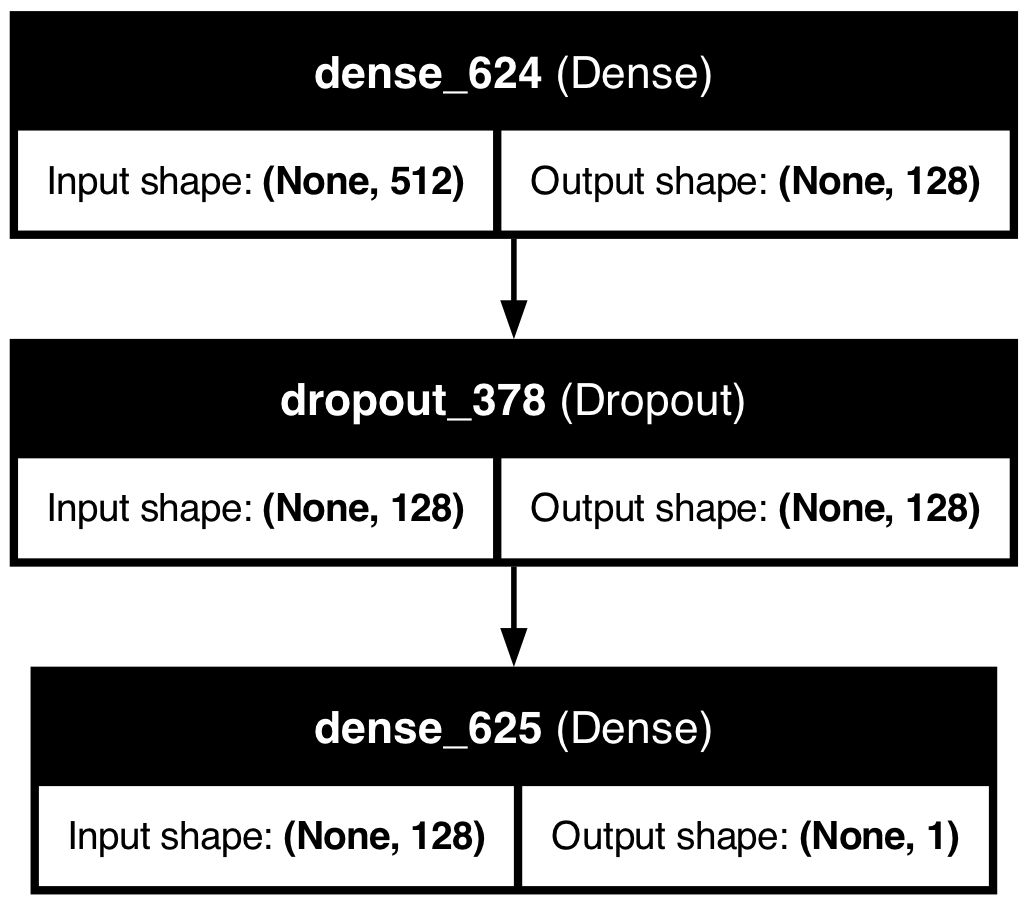

In [102]:
# Generate the plot
plot_model(model_4cUST, show_shapes=True, show_layer_names=True)

Epoch 1/300
221/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7106 - loss: 0.7263
Epoch 1: val_loss improved from inf to 0.53578, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7147 - loss: 0.7150 - val_accuracy: 0.7653 - val_loss: 0.5358 - learning_rate: 0.0010
Epoch 2/300
232/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7716 - loss: 0.5259
Epoch 2: val_loss improved from 0.53578 to 0.52113, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7718 - loss: 0.5253 - val_accuracy: 0.7527 - val_loss: 0.5211 - learning_rate: 0.0010
Epoch 3/300
228/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7803 - loss: 0.4970
Epoch 3: val_loss improved from 0.52113 to 0.51228, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7801 - loss: 0.4974 - val_accuracy: 0.7623 - val_loss: 0.5123 - learning_rate: 0.0010
Epoch 4/300
220/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

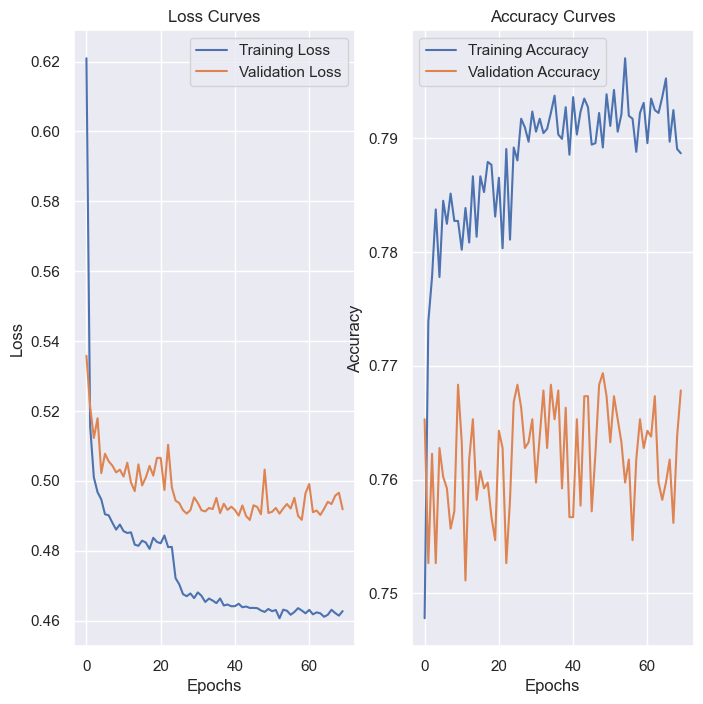

In [103]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_4cUST_history = model_4cUST.fit(
    cX_train_embeddings, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_4cUST_history)

In [104]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_4cUST.predict(cX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4cUST_time_per_instance = (end_time - start_time) / len(cX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4cUST_accuracy = accuracy_score(cy_test, cy_pred)
m4cUST_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4cUST_recall = recall_score(cy_test, cy_pred, average='weighted')
m4cUST_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4cUST_accuracy:.2%}", f"{m4cUST_precision:.3f}", f"{m4cUST_recall:.3f}", f"{m4cUST_f1:.3f}", f"{m4cUST_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Performance          Results
         accuracy           76.94%
        precision            0.771
           recall            0.769
         f1_score            0.769
    time/instance 0.000271 seconds


In [105]:
store_results('Model_1cUSE', m4cUST_accuracy, m4cUST_precision, m4cUST_recall, m4cUST_f1, m4cUST_time_per_instance)

# View the consolidated results
print(results_df)

          Model Accuracy Precision Recall F1 Score Time per Instance
0    Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1    Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2    Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3    Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4    Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5    Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds
6      Model_2c   75.93%     0.760  0.759    0.759  0.000928 seconds
7      Model_2r   76.74%     0.770  0.767    0.767  0.001405 seconds
8      Model_3c   77.99%     0.785  0.780    0.779  0.001692 seconds
9      Model_3r   76.05%     0.763  0.761    0.760  0.004188 seconds
10  Model_1cUSE   76.94%     0.771  0.769    0.769  0.000271 seconds


#### USE with raw data

In [106]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

# Precompute the embeddings for the training and test sets
rX_train_embeddings = np.array(USE_embedding(rX_train))
rX_test_embeddings = np.array(USE_embedding(rX_test))

In [107]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(rX_train_embeddings.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [108]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Execute the grid search with early stopping and learning rate reduction
grid_result = grid.fit(rX_train_embeddings, ry_train, callbacks=[early_stopping])

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6995 - loss: 0.5851
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7843 - loss: 0.4481
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7908 - loss: 0.4454
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7938 - loss: 0.4328
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8104 - loss: 0.4096
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7962 - loss: 0.4251
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8095 - loss: 0.4083
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8074 - loss: 0.4178
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8044 - loss: 0.4163
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8019 - loss: 0.4236
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8161 - loss: 0.4110
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7084 - loss: 0.5860
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7892 - loss: 0.4374
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8013 - loss: 0.4262
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7985 - loss: 0.4225
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8160 - loss: 0.3968
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8115 - loss: 0.4060
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8073 - loss: 0.4151
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8079 - loss: 0.4145
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8114 - loss: 0.4113
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8144 - loss: 0.4008
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8200 - loss: 0.3934
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7274 - loss: 0.5816
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8001 - loss: 0.4416
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7961 - loss: 0.4365
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7994 - loss: 0.4401
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8063 - loss: 0.4201
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8098 - loss: 0.4214
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8045 - loss: 0.4168
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8089 - loss: 0.4137
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8031 - loss: 0.4158
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8101 - loss: 0.4158
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8113 - loss: 0.4105
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7168 - loss: 0.7257
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7815 - loss: 0.5168
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7976 - loss: 0.4849
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7791 - loss: 0.4848
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7885 - loss: 0.4814
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7984 - loss: 0.4686
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7942 - loss: 0.4702
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7956 - loss: 0.4670
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7946 - loss: 0.4736
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7981 - loss: 0.4688
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8076 - loss: 0.4523
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7065 - loss: 0.7253
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7892 - loss: 0.5084
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7976 - loss: 0.4828
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8059 - loss: 0.4636
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7886 - loss: 0.4745
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7977 - loss: 0.4725
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7987 - loss: 0.4601
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8053 - loss: 0.4538
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7965 - loss: 0.4628
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7983 - loss: 0.4583
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8052 - loss: 0.4565
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7014 - loss: 0.7284
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7953 - loss: 0.5061
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8053 - loss: 0.4801
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8001 - loss: 0.4654
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7917 - loss: 0.4724
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8017 - loss: 0.4652
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8023 - loss: 0.4668
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7982 - loss: 0.4625
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7924 - loss: 0.4644
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7949 - loss: 0.4638
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7980 - loss: 0.4664
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7313 - loss: 0.5680
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7946 - loss: 0.4418
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7981 - loss: 0.4331
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7945 - loss: 0.4326
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8037 - loss: 0.4316
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7941 - loss: 0.4242
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8006 - loss: 0.4182
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8025 - loss: 0.4188
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8117 - loss: 0.4082
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8091 - loss: 0.4082
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8088 - loss: 0.3999
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7098 - loss: 0.5753
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7988 - loss: 0.4286
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8042 - loss: 0.4172
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8063 - loss: 0.4137
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8034 - loss: 0.4266
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8095 - loss: 0.4075
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8051 - loss: 0.4184
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8058 - loss: 0.4068
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8116 - loss: 0.3967
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8148 - loss: 0.4004
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8099 - loss: 0.3907
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7197 - loss: 0.5723
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7944 - loss: 0.4353
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8119 - loss: 0.4134
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8094 - loss: 0.4144
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8055 - loss: 0.4287
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8155 - loss: 0.4102
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8018 - loss: 0.4264
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8032 - loss: 0.4243
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8147 - loss: 0.3975
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8140 - loss: 0.4003
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8148 - loss: 0.3976
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7089 - loss: 0.7759
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7844 - loss: 0.5221
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7922 - loss: 0.4980
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7894 - loss: 0.4892
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7925 - loss: 0.4776
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7950 - loss: 0.4812
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8046 - loss: 0.4706
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7928 - loss: 0.4697
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7948 - loss: 0.4717
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7965 - loss: 0.4727
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8000 - loss: 0.4756
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7121 - loss: 0.7764
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7949 - loss: 0.5168
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7951 - loss: 0.4889
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8073 - loss: 0.4678
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8008 - loss: 0.4706
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8010 - loss: 0.4655
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8038 - loss: 0.4660
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8026 - loss: 0.4618
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8070 - loss: 0.4546
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8063 - loss: 0.4513
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7977 - loss: 0.4591
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7187 - loss: 0.7767
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7995 - loss: 0.5165
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7900 - loss: 0.5026
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8065 - loss: 0.4783
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8041 - loss: 0.4766
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7988 - loss: 0.4733
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8022 - loss: 0.4727
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7986 - loss: 0.4762
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7986 - loss: 0.4683
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8021 - loss: 0.4665
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8015 - loss: 0.4696
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7186 - loss: 0.5704
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7906 - loss: 0.4425
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7931 - loss: 0.4371
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7994 - loss: 0.4324
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7996 - loss: 0.4299
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8139 - loss: 0.4062
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8050 - loss: 0.4225
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8009 - loss: 0.4283
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8071 - loss: 0.4213
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8070 - loss: 0.4163
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8086 - loss: 0.4141
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7277 - loss: 0.5622
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7949 - loss: 0.4299
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8012 - loss: 0.4191
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8050 - loss: 0.4173
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8157 - loss: 0.4090
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7926 - loss: 0.4273
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8101 - loss: 0.4109
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8033 - loss: 0.4186
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8140 - loss: 0.4011
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8119 - loss: 0.4101
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8116 - loss: 0.4065
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7377 - loss: 0.5604
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7899 - loss: 0.4404
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8062 - loss: 0.4265
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8070 - loss: 0.4259
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8045 - loss: 0.4159
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8000 - loss: 0.4265
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8150 - loss: 0.4076
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8086 - loss: 0.4218
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8100 - loss: 0.4092
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8069 - loss: 0.4069
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8114 - loss: 0.4078
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7124 - loss: 0.7794
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7896 - loss: 0.5033
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7945 - loss: 0.4846
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7823 - loss: 0.4914
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7892 - loss: 0.4798
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7919 - loss: 0.4714
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7875 - loss: 0.4823
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8019 - loss: 0.4657
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7906 - loss: 0.4735
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7926 - loss: 0.4701
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8013 - loss: 0.4605
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7178 - loss: 0.7743
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7966 - loss: 0.4928
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7927 - loss: 0.4759
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7891 - loss: 0.4876
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8049 - loss: 0.4721
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7929 - loss: 0.4673
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8006 - loss: 0.4658
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7973 - loss: 0.4619
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8061 - loss: 0.4540
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7891 - loss: 0.4706
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8067 - loss: 0.4547
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7304 - loss: 0.7731
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7876 - loss: 0.5088
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7891 - loss: 0.4888
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8069 - loss: 0.4634
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8065 - loss: 0.4687
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7952 - loss: 0.4693
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7969 - loss: 0.4703
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7961 - loss: 0.4710
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7974 - loss: 0.4692
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7904 - loss: 0.4679
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7985 - loss: 0.4707
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7287 - loss: 0.5519
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7876 - loss: 0.4459
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8012 - loss: 0.4402
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8041 - loss: 0.4192
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7901 - loss: 0.4205
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8161 - loss: 0.4010
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8063 - loss: 0.4099
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7968 - loss: 0.4192
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8030 - loss: 0.4114
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8058 - loss: 0.3991
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8061 - loss: 0.4017
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7411 - loss: 0.5428
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8024 - loss: 0.4257
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7987 - loss: 0.4190
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8133 - loss: 0.4035
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8068 - loss: 0.4136
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8006 - loss: 0.4118
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8118 - loss: 0.4086
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8130 - loss: 0.4007
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8109 - loss: 0.4045
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8140 - loss: 0.3936
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8149 - loss: 0.3875
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7440 - loss: 0.5438
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7872 - loss: 0.4433
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8071 - loss: 0.4209
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8017 - loss: 0.4266
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8001 - loss: 0.4297
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8058 - loss: 0.4115
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8078 - loss: 0.4004
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8065 - loss: 0.4067
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7991 - loss: 0.4077
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8020 - loss: 0.4085
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8151 - loss: 0.3884
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7235 - loss: 0.8564
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7872 - loss: 0.5239
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7874 - loss: 0.4896
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7924 - loss: 0.4869
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8007 - loss: 0.4778
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7947 - loss: 0.4735
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7958 - loss: 0.4690
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8016 - loss: 0.4768
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7923 - loss: 0.4746
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7810 - loss: 0.4917
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8004 - loss: 0.4700
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7322 - loss: 0.8545
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7992 - loss: 0.5033
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8026 - loss: 0.4756
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7949 - loss: 0.4790
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7977 - loss: 0.4805
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7952 - loss: 0.4673
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7971 - loss: 0.4759
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8080 - loss: 0.4640
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8014 - loss: 0.4723
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8051 - loss: 0.4605
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7995 - loss: 0.4636
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7252 - loss: 0.8581
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7949 - loss: 0.5139
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7950 - loss: 0.4911
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7967 - loss: 0.4855
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8060 - loss: 0.4728
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8025 - loss: 0.4734
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7964 - loss: 0.4759
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8069 - loss: 0.4654
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7944 - loss: 0.4761
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8030 - loss: 0.4713
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8016 - loss: 0.4679
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6521 - loss: 0.6737
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7300 - loss: 0.6063
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7550 - loss: 0.5509
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7531 - loss: 0.5249
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7669 - loss: 0.4926
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7736 - loss: 0.4740
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7775 - loss: 0.4678
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7879 - loss: 0.4579
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7912 - loss: 0.4527
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7874 - loss: 0.4509
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8000 - loss: 0.4365
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6393 - loss: 0.6753
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7355 - loss: 0.6080
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7508 - loss: 0.5506
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7741 - loss: 0.5124
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7768 - loss: 0.4887
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7765 - loss: 0.4798
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7853 - loss: 0.4547
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7960 - loss: 0.4481
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7940 - loss: 0.4392
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7934 - loss: 0.4429
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7851 - loss: 0.4433
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6716 - loss: 0.6697
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7291 - loss: 0.6019
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7483 - loss: 0.5516
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7661 - loss: 0.5133
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7823 - loss: 0.4854
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7838 - loss: 0.4734
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7822 - loss: 0.4669
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7921 - loss: 0.4559
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7941 - loss: 0.4511
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7935 - loss: 0.4433
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7948 - loss: 0.4419
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6151 - loss: 0.8725
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7283 - loss: 0.7700
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7435 - loss: 0.6927
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7541 - loss: 0.6423
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7621 - loss: 0.6058
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7652 - loss: 0.5798
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7794 - loss: 0.5608
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7805 - loss: 0.5436
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7928 - loss: 0.5252
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7937 - loss: 0.5092
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7973 - loss: 0.5089
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6546 - loss: 0.8681
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7269 - loss: 0.7647
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7428 - loss: 0.6931
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7640 - loss: 0.6354
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7761 - loss: 0.5954
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7739 - loss: 0.5755
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7796 - loss: 0.5548
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7807 - loss: 0.5402
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7844 - loss: 0.5258
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7919 - loss: 0.5160
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7992 - loss: 0.5063
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6436 - loss: 0.8677
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7277 - loss: 0.7669
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7467 - loss: 0.6908
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7511 - loss: 0.6442
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7636 - loss: 0.6012
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7860 - loss: 0.5683
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7969 - loss: 0.5517
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7933 - loss: 0.5408
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7964 - loss: 0.5240
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7909 - loss: 0.5208
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7872 - loss: 0.5210
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6241 - loss: 0.6818
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7271 - loss: 0.6035
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7597 - loss: 0.5103
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7814 - loss: 0.4683
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7887 - loss: 0.4565
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7876 - loss: 0.4452
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7880 - loss: 0.4441
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7951 - loss: 0.4418
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8036 - loss: 0.4333
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8026 - loss: 0.4261
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7907 - loss: 0.4386
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6101 - loss: 0.6826
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7305 - loss: 0.5946
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7599 - loss: 0.5139
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7941 - loss: 0.4629
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7818 - loss: 0.4599
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7979 - loss: 0.4359
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7950 - loss: 0.4259
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7991 - loss: 0.4270
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7946 - loss: 0.4328
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7987 - loss: 0.4291
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8049 - loss: 0.4198
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6567 - loss: 0.6794
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7429 - loss: 0.5867
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7683 - loss: 0.5038
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7879 - loss: 0.4697
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7946 - loss: 0.4425
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7991 - loss: 0.4404
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7982 - loss: 0.4422
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8020 - loss: 0.4295
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8029 - loss: 0.4358
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8066 - loss: 0.4293
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8010 - loss: 0.4293
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6485 - loss: 0.9507
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7233 - loss: 0.8264
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7450 - loss: 0.7146
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7652 - loss: 0.6434
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7823 - loss: 0.5980
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7926 - loss: 0.5744
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7779 - loss: 0.5718
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7915 - loss: 0.5469
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8006 - loss: 0.5255
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7844 - loss: 0.5353
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7986 - loss: 0.5095
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6213 - loss: 0.9557
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7297 - loss: 0.8326
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7528 - loss: 0.7138
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7761 - loss: 0.6393
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7871 - loss: 0.5940
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7857 - loss: 0.5730
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7854 - loss: 0.5600
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7985 - loss: 0.5368
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7911 - loss: 0.5281
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7945 - loss: 0.5247
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7966 - loss: 0.5149
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6178 - loss: 0.9535
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7303 - loss: 0.8284
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7626 - loss: 0.7077
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7731 - loss: 0.6462
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7912 - loss: 0.5983
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8037 - loss: 0.5723
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7967 - loss: 0.5602
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8045 - loss: 0.5426
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8005 - loss: 0.5337
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8019 - loss: 0.5268
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7989 - loss: 0.5243
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6399 - loss: 0.6702
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7393 - loss: 0.5832
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7532 - loss: 0.5308
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7660 - loss: 0.4973
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7769 - loss: 0.4766
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7855 - loss: 0.4627
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7862 - loss: 0.4488
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8002 - loss: 0.4425
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7962 - loss: 0.4424
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7867 - loss: 0.4491
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7855 - loss: 0.4538
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6539 - loss: 0.6683
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7359 - loss: 0.5846
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7580 - loss: 0.5231
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7728 - loss: 0.4849
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7817 - loss: 0.4696
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7843 - loss: 0.4625
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7951 - loss: 0.4411
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7861 - loss: 0.4430
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7977 - loss: 0.4392
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7972 - loss: 0.4313
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7966 - loss: 0.4267
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6394 - loss: 0.6693
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7315 - loss: 0.5828
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7527 - loss: 0.5290
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7766 - loss: 0.4818
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7807 - loss: 0.4762
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7920 - loss: 0.4566
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7908 - loss: 0.4479
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7917 - loss: 0.4456
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8031 - loss: 0.4267
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8047 - loss: 0.4307
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8076 - loss: 0.4272
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6260 - loss: 0.9883
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7297 - loss: 0.8242
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7505 - loss: 0.7172
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7530 - loss: 0.6487
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7687 - loss: 0.6002
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7790 - loss: 0.5679
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7901 - loss: 0.5447
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7837 - loss: 0.5397
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7844 - loss: 0.5165
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7916 - loss: 0.5114
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7919 - loss: 0.5038
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6292 - loss: 0.9878
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7450 - loss: 0.8205
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7471 - loss: 0.7137
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7704 - loss: 0.6430
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7843 - loss: 0.5897
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7806 - loss: 0.5676
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8017 - loss: 0.5323
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7820 - loss: 0.5305
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7871 - loss: 0.5134
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7936 - loss: 0.5046
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7934 - loss: 0.4962
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6433 - loss: 0.9878
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7489 - loss: 0.8187
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7606 - loss: 0.7099
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7631 - loss: 0.6458
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7841 - loss: 0.5947
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7914 - loss: 0.5628
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7956 - loss: 0.5394
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7949 - loss: 0.5271
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7971 - loss: 0.5151
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7958 - loss: 0.5088
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7901 - loss: 0.5100
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6803 - loss: 0.6707
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7428 - loss: 0.5423
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7796 - loss: 0.4666
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7782 - loss: 0.4563
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7813 - loss: 0.4533
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8000 - loss: 0.4297
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7936 - loss: 0.4317
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8010 - loss: 0.4294
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8039 - loss: 0.4259
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7991 - loss: 0.4365
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8022 - loss: 0.4230
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6582 - loss: 0.6713
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7552 - loss: 0.5271
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7760 - loss: 0.4683
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7908 - loss: 0.4404
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7970 - loss: 0.4426
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7945 - loss: 0.4317
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7978 - loss: 0.4357
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8067 - loss: 0.4162
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7978 - loss: 0.4329
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7998 - loss: 0.4130
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8008 - loss: 0.4180
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6758 - loss: 0.6671
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7617 - loss: 0.5295
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7796 - loss: 0.4686
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7952 - loss: 0.4426
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7981 - loss: 0.4417
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8036 - loss: 0.4170
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8109 - loss: 0.4254
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8021 - loss: 0.4281
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8063 - loss: 0.4221
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8055 - loss: 0.4238
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8162 - loss: 0.4138
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6233 - loss: 1.1461
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7333 - loss: 0.9103
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7698 - loss: 0.7519
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7734 - loss: 0.6815
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7846 - loss: 0.6245
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7882 - loss: 0.5971
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7893 - loss: 0.5792
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7970 - loss: 0.5470
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7919 - loss: 0.5408
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8007 - loss: 0.5233
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7962 - loss: 0.5147
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6497 - loss: 1.1454
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7434 - loss: 0.9059
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7747 - loss: 0.7415
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7883 - loss: 0.6617
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7942 - loss: 0.6115
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8096 - loss: 0.5739
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7946 - loss: 0.5527
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7946 - loss: 0.5364
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7926 - loss: 0.5325
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7932 - loss: 0.5220
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8042 - loss: 0.5129
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6198 - loss: 1.1464
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7391 - loss: 0.9076
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7709 - loss: 0.7527
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8028 - loss: 0.6612
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7985 - loss: 0.6215
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7987 - loss: 0.5869
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8052 - loss: 0.5623
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8062 - loss: 0.5411
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8063 - loss: 0.5270
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8068 - loss: 0.5194
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8060 - loss: 0.5059
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7345 - loss: 0.7924
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7871 - loss: 0.5018
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7907 - loss: 0.4859
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8016 - loss: 0.4662
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7927 - loss: 0.4821
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7968 - loss: 0.4665
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7976 - loss: 0.4726
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7978 - loss: 0.4641
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8024 - loss: 0.4668
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7981 - loss: 0.4672
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7965 - loss: 0.4648
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

In [109]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.793403 using {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.790671 (0.006209) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.789255 (0.003143) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.788446 (0.009665) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.790064 (0.004702) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.789154 (0.007264) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.786624 (0.006765) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.784096 (0.002061) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.793403 (0.003807) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.792998 (0.005478) with: {'learning_rat

In [110]:
# Extract the best parameters
best_params = grid_result.best_params_

In [111]:
# Create the final model using the best parameters
model_4rUSF = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_4rUSF.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_299"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_749 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_453 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_750 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_454 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_751 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,353 (642.00 KB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 0 (0.00 B)

None


python(53678) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53679) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


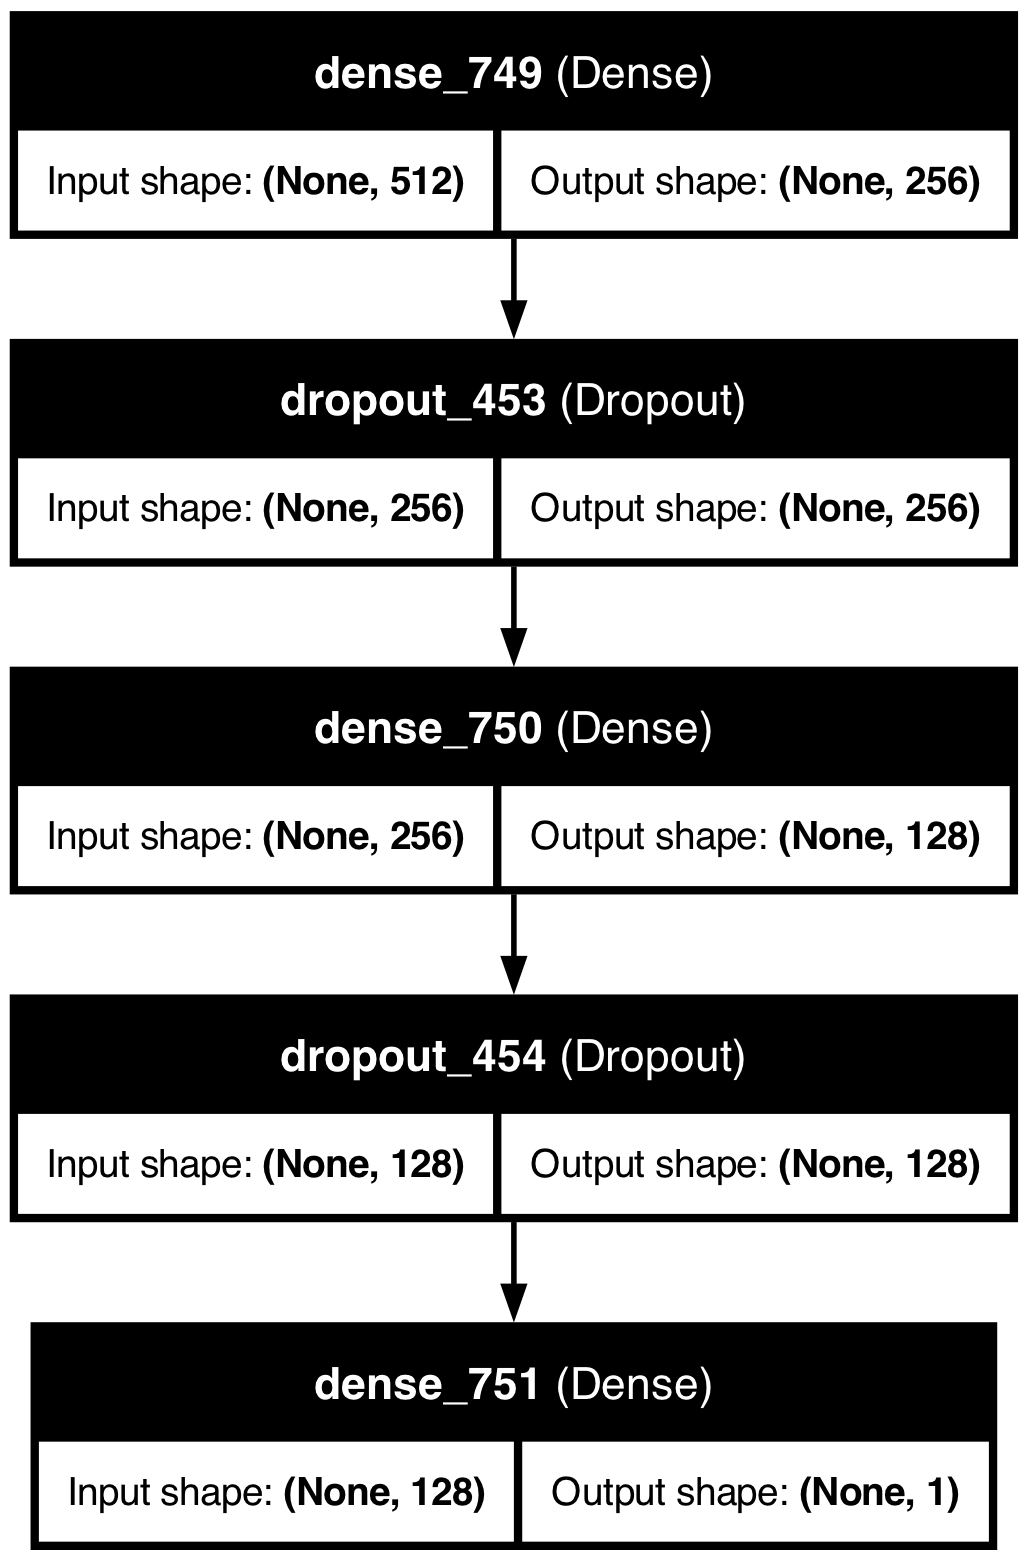

In [112]:
# Generate the plot
plot_model(model_4rUSF, show_shapes=True, show_layer_names=True)

Epoch 1/300
239/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7201 - loss: 0.8381
Epoch 1: val_loss improved from inf to 0.55225, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7214 - loss: 0.8313 - val_accuracy: 0.7516 - val_loss: 0.5523 - learning_rate: 0.0010
Epoch 2/300
241/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7782 - loss: 0.5256
Epoch 2: val_loss improved from 0.55225 to 0.52454, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7782 - loss: 0.5255 - val_accuracy: 0.7734 - val_loss: 0.5245 - learning_rate: 0.0010
Epoch 3/300
239/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7848 - loss: 0.5047
Epoch 3: val_loss improved from 0.52454 to 0.52046, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7845 - loss: 0.5048 - val_accuracy: 0.7577 - val_loss: 0.5205 - learning_rate: 0.0010
Epoch 4/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 

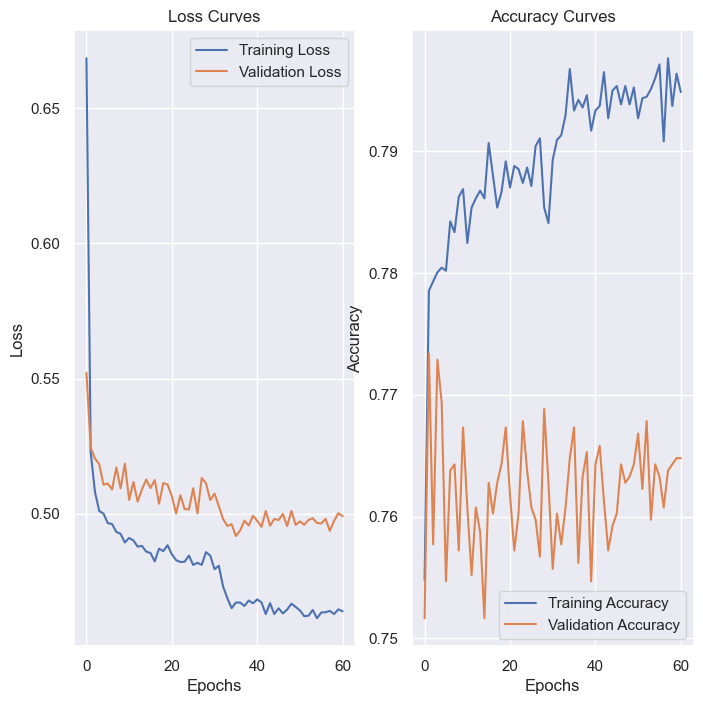

In [113]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_4rUSF_history = model_4rUSF.fit(
    cX_train_embeddings, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_4rUSF_history)

In [114]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_4rUSF.predict(rX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4rUSF_time_per_instance = (end_time - start_time) / len(rX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4rUSF_accuracy = accuracy_score(ry_test, ry_pred)
m4rUSF_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4rUSF_recall = recall_score(ry_test, ry_pred, average='weighted')
m4rUSF_f1 = f1_score(ry_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4rUSF_accuracy:.2%}", f"{m4rUSF_precision:.3f}", f"{m4rUSF_recall:.3f}", f"{m4rUSF_f1:.3f}", f"{m4rUSF_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Model Performance          Results
         accuracy           76.25%
        precision            0.767
           recall            0.763
         f1_score            0.769
    time/instance 0.000630 seconds


In [115]:
store_results('Model_1rUSE', m4rUSF_accuracy, m4rUSF_precision, m4rUSF_recall, m4rUSF_f1, m4rUSF_time_per_instance)

# View the consolidated results
print(results_df)

          Model Accuracy Precision Recall F1 Score Time per Instance
0    Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1    Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2    Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3    Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4    Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5    Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds
6      Model_2c   75.93%     0.760  0.759    0.759  0.000928 seconds
7      Model_2r   76.74%     0.770  0.767    0.767  0.001405 seconds
8      Model_3c   77.99%     0.785  0.780    0.779  0.001692 seconds
9      Model_3r   76.05%     0.763  0.761    0.760  0.004188 seconds
10  Model_1cUSE   76.94%     0.771  0.769    0.769  0.000271 seconds
11  Model_1rUSE   76.25%     0.767  0.763    0.769  0.000630 seconds


## Model not use

### DistilBERT

In [116]:
# from transformers import DistilBertTokenizer, TFDistilBertModel

In [117]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [118]:
#def get_distilbert_embeddings(texts):
#    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=512)
#    outputs = distilbert_model(encoded_inputs)
#    # Take the mean of the output embeddings to use as sentence embeddings
#    return tf.reduce_mean(outputs.last_hidden_state, axis=1)

In [119]:
# Convert texts to embeddings
#cX_train_embeddingsDBert = get_distilbert_embeddings(cX_train.tolist())
#cX_test_embeddingsDBert = get_distilbert_embeddings(cX_test.tolist())
#rX_train_embeddingsDBert = get_distilbert_embeddings(rX_train.tolist())
#rX_test_embeddingsDBert = get_distilbert_embeddings(rX_test.tolist())

In [120]:
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddingsDBert.shape[1],)),
#    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

# Using an optimizer with adaptive learning rate
#optimizerDB = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
#model.compile(optimizer=optimizerDB, loss='binary_crossentropy', metrics=['accuracy'])

# Callback for early stopping
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Number of epochs
#epochs = 300

# Train the model
#model_history = model.fit(
#    cX_train_embeddingsDBert, 
#    ry_train, 
#    batch_size=32, 
#    epochs=epochs, 
#    validation_split=0.2, 
#    callbacks=[callback_es]
#)

# Model Summary
#print(model.summary())

In [121]:
# Use the function with model's history
# plot_loss_curves(model_history)

### RoBERTa

In [122]:
#from transformers import RobertaTokenizer, TFRobertaModel
#from tensorflow.keras.models import Model

In [123]:
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
#roberta_model = TFRobertaModel.from_pretrained('roberta-base')

In [124]:
#def get_roberta_embeddings(texts):
#    # Tokenize the texts
#    encoded_input = tokenizer(texts, return_tensors='tf', padding=True, truncation=True, max_length=512)
#    # Get embeddings from RoBERTa model
#    outputs = roberta_model(encoded_input)
#    # Use the pooled output for classification tasks (similar to [CLS] in BERT)
#    return outputs.pooler_output

# Convert texts to embeddings
#cX_train_embeddingsBERT = get_roberta_embeddings(cX_train.tolist())
#cX_test_embeddingsBERT = get_roberta_embeddings(cX_test.tolist())
#rX_train_embeddingsBERT = get_roberta_embeddings(rX_train.tolist())
#rX_test_embeddingsBERT = get_roberta_embeddings(rX_test.tolist())

In [125]:
# Define the model
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddingsBERT.shape[1],)),
#    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

# Using an optimizer with adaptive learning rate
#optimizerB = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
#model.compile(optimizer=optimizerB, loss='binary_crossentropy', metrics=['accuracy'])

# Generate the plot
#plot_model(model, show_shapes=True, show_layer_names=True)

In [126]:
# Callback for early stopping
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Number of epochs
#epochs = 300

# Fit the model
#model_history = model.fit(
#    cX_train_embeddings, 
#    cy_train, 
#    batch_size=64, 
#    epochs=epochs, 
#    validation_split=0.2, 
#    callbacks=[callback_es]
#)

# Model Summary
#print(model.summary())

In [127]:
# Use the function with model's history
#plot_loss_curves(model_history)

### GPT2

In [128]:
#from transformers import TFAutoModel, AutoTokenizer, GPT2Tokenizer

In [129]:
#tokenizer = AutoTokenizer.from_pretrained('gpt2')
#model_gpt = TFAutoModel.from_pretrained('gpt2')

In [130]:
#if tokenizer.pad_token is None:
#    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Resize model embeddings
#model_gpt.resize_token_embeddings(len(tokenizer))

#def get_gpt_embeddings(texts):
#    # Ensure input is a list of strings
#    if isinstance(texts, pd.Series):
#        texts = texts.tolist()
#    elif not isinstance(texts, list):
#        raise ValueError("Input must be a list of strings.")
    
    # Tokenize and align to the maximum sequence length expected by GPT-2
#    inputs = tokenizer(texts, truncation=True, padding="max_length", max_length=512, return_tensors="tf")
    
    # Extract last hidden states
#    outputs = model_gpt(**inputs)
#    embeddings = outputs.last_hidden_state[:, 0, :]  # Extracting embeddings from the first token
#    return embeddings


In [131]:
#cX_train_embeddingsGPT = get_gpt_embeddings(cX_train.astype(str))
#cX_test_embeddingsGPT = get_gpt_embeddings(cX_test.astype(str))

In [132]:
# Define the model
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddingsGPT.shape[1],)),
#    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

# Using an optimizer with adaptive learning rate
#optimizerC = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
#model.compile(optimizer=optimizerC, loss='binary_crossentropy', metrics=['accuracy'])

# Generate the plot
#plot_model(model, show_shapes=True, show_layer_names=True)

In [133]:
# Callback for early stopping
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Number of epochs
#epochs = 300

# Fit the model
#model_history = model.fit(
#    cX_train_embeddings, 
#    cy_train, 
#    batch_size=64, 
#    epochs=epochs, 
#    validation_split=0.2, 
#    callbacks=[callback_es]
#)

# Model Summary
#print(model.summary())

In [134]:
# Use the function with model's history
#plot_loss_curves(model_history)

## Summary of all models

In [135]:
print(results_df)

          Model Accuracy Precision Recall F1 Score Time per Instance
0    Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1    Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2    Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3    Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4    Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5    Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds
6      Model_2c   75.93%     0.760  0.759    0.759  0.000928 seconds
7      Model_2r   76.74%     0.770  0.767    0.767  0.001405 seconds
8      Model_3c   77.99%     0.785  0.780    0.779  0.001692 seconds
9      Model_3r   76.05%     0.763  0.761    0.760  0.004188 seconds
10  Model_1cUSE   76.94%     0.771  0.769    0.769  0.000271 seconds
11  Model_1rUSE   76.25%     0.767  0.763    0.769  0.000630 seconds


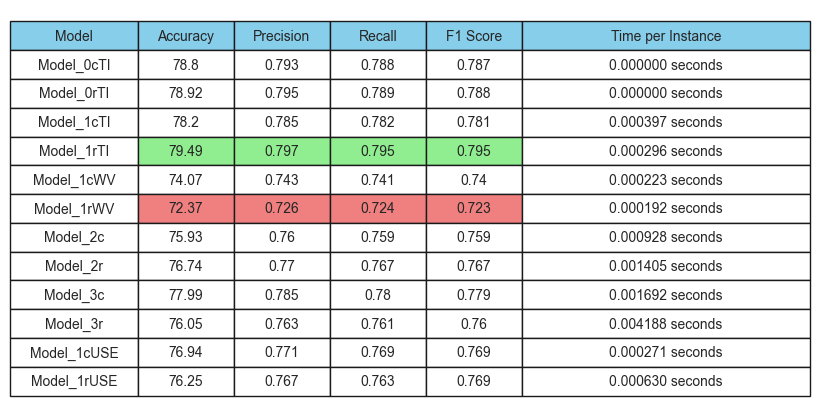

In [136]:
# Convert relevant columns to float for comparison
results_df['Precision'] = results_df['Precision'].astype('float')
results_df['Recall'] = results_df['Recall'].astype('float')
results_df['F1 Score'] = results_df['F1 Score'].astype('float')
results_df['Accuracy'] = results_df['Accuracy'].str.rstrip('%').astype('float')

# Find the best and worst values
best_values = results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].max()
worst_values = results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].min()

# Create a figure and a subplot
fig, ax = plt.subplots(figsize=(10, 0.6 + 0.3 * len(results_df)))  # Smaller height factor to reduce vertical space
ax.axis('off')  # Hide the axes

# Convert DataFrame to a list of lists for cellText
data = results_df.values.tolist()

# Table
table = ax.table(
    cellText=data,
    colLabels=results_df.columns,
    cellLoc='center',
    loc='center',
    colColours=["skyblue"]*len(results_df.columns),  # Color for the column headers
    colWidths=[0.16, 0.12, 0.12, 0.12, 0.12, 0.36]  # Adjust column widths to fit your content
)

# Highlight best and worst values
for row in range(1, len(data) + 1):  # Skip the header row
    for col, col_name in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
        if results_df.at[row-1, col_name] == best_values[col_name]:
            table[(row, col + 1)].set_facecolor('lightgreen')
        elif results_df.at[row-1, col_name] == worst_values[col_name]:
            table[(row, col + 1)].set_facecolor('lightcoral')

table.auto_set_font_size(False)
table.set_fontsize(10)  # Adjust font size if necessary
table.scale(1, 1.4)  # Scale table size, reduce x-scaling to minimize horizontal space

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.1, right=0.9, top=1, bottom=0.05)  # Minimize margins as much as possible

plt.show()

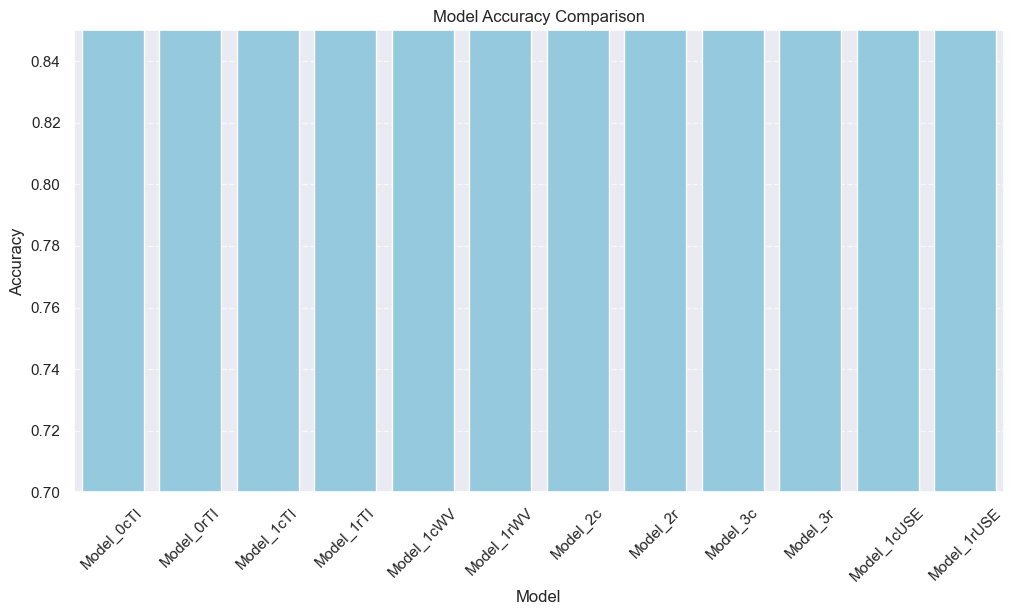

In [137]:
# Creating a bar plot for model accuracy comparison with seaborn in sky blue, without error bars
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, color='skyblue', ci=None)

# Adjusting the aesthetics
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0.70, 0.85)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()